## Importing Necessary Packages

In [1]:
import os
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from torchvision.utils import make_grid
import torchvision.transforms.functional as TF

## CUDA(GPU) supported

In [2]:
global device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Sparse AutoEncoder with Residual Neural Net

In [3]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=2):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)
        
    def forward(self, x):
        identity = x
        x = self.conv2(self.relu(self.conv1(x)))
        x += identity
        
        return x
    
class ResNetEncoder(nn.Module):
    # layers is the list of repetations of each ResBlock
    def __init__(self, ResBlock, image_channels, layers):
        super(ResNetEncoder,self).__init__()
        
        # .... INPUT LAYER .... DWONSAMPLING
        self.encoder = nn.Sequential(nn.Conv2d(image_channels, 8, kernel_size=5, stride=2, padding=0),
        self._make_layer(ResBlock, layers[0], out_channels=8, kernel_size=5, stride=1, padding=2),
        nn.Conv2d(8, 16, kernel_size=5, stride=2, padding=2),
        self._make_layer(ResBlock, layers[1], out_channels=16, kernel_size=5, stride=1, padding=2),
        nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
        self._make_layer(ResBlock, layers[2], out_channels=32, kernel_size=3, stride=1, padding=1)
        )
        
        # .... DECODER .... TRANSPOSED CONVOLUTION FOR UPSAMPLING
        self.decoder = nn.Sequential(self._make_layer(ResBlock, layers[3], out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2, padding=0),
        self._make_layer(ResBlock, layers[4], out_channels=16, kernel_size=5, stride=1, padding=2),
        nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
        self._make_layer(ResBlock, layers[5], out_channels=8, kernel_size=5, stride=1, padding=2),
        nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1),
        )
    
    def _make_layer(self, ResBlock, num_residual_blocks, out_channels, kernel_size, stride, padding):
        in_channels = out_channels
        layers = []
        layers.append(ResBlock(in_channels, out_channels, kernel_size, stride, padding))
        
        # the output of 'block' will be fedback to itself for "num_residual_blocks-1" times
        for i in range(num_residual_blocks-1):
            layers.append(ResBlock(in_channels, out_channels, kernel_size, stride=1, padding=padding))
            
        return nn.Sequential(*layers)

    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

## What Each Layer is Doing !!!!!

In [4]:
def image_loader(image_name, loader = transforms.Compose([transforms.ToTensor(),])):
    
    image = Image.open(image_name)
    i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(300, 300))
    image = TF.crop(image, i, j, h, w)
    image = loader(image).unsqueeze(0)  # fake batch dimension required to fit network's input dimensions
    return image.to(device).float()

In [16]:
data = image_loader("sample_img.jpg")
AutoEncoder = ResNetEncoder(ResBlock, image_channels = 3, layers=[2, 2, 1, 1, 2, 2]).to(device)

In [17]:
with torch.no_grad():
    for child in AutoEncoder.children():
        for i in child:
            try:
                data = i(data)
                print('@@@', i, '\nkernel size :', i.weight.shape, '\toutput size :', data.shape, '\n')
            except:
                for j in i.children():
                    for k in j.children():
                        data = k(data)
                        try:
                            print('***', k, '\nkernel size :', k.weight.shape, '\t output size : ',data.shape, '\n')
                        except:
                            # ReLU layer has no weight associated
                            print('***', k, '\nNo kernel', '\t output size :', data.shape,'\n')

@@@ Conv2d(3, 8, kernel_size=(5, 5), stride=(2, 2)) 
kernel size : torch.Size([8, 3, 5, 5]) 	output size : torch.Size([1, 8, 148, 148]) 

*** Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) 
kernel size : torch.Size([8, 8, 5, 5]) 	 output size :  torch.Size([1, 8, 148, 148]) 

*** ReLU() 
No kernel 	 output size : torch.Size([1, 8, 148, 148]) 

*** Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) 
kernel size : torch.Size([8, 8, 5, 5]) 	 output size :  torch.Size([1, 8, 148, 148]) 

*** Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) 
kernel size : torch.Size([8, 8, 5, 5]) 	 output size :  torch.Size([1, 8, 148, 148]) 

*** ReLU() 
No kernel 	 output size : torch.Size([1, 8, 148, 148]) 

*** Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) 
kernel size : torch.Size([8, 8, 5, 5]) 	 output size :  torch.Size([1, 8, 148, 148]) 

@@@ Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)) 
kernel size : torch.Size([16, 

## Sobel Gradient Operator

In [18]:
def gradient_img(image):
    
    image = image.squeeze(0)
    channels = torch.unbind(image)
    x = channels[0].unsqueeze(0).unsqueeze(0)
    
    # Gradient along x-direction
    Sobel_x = np.array([[1, 0, -1],[2,0,-2],[1,0,-1]])
    
    conv1 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
    conv1.weight = nn.Parameter(torch.from_numpy(Sobel_x).\
                                float().unsqueeze(0).unsqueeze(0).to(device))
    Grad_x = conv1(Variable(x)).data.view(1,x.shape[2],x.shape[3])
    
    # Gradient along y-direction
    Sobel_y = np.array([[1, 2, 1],[0,0,0],[-1,-2,-1]])
    
    conv2 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
    conv2.weight = nn.Parameter(torch.from_numpy(Sobel_y).\
                                float().unsqueeze(0).unsqueeze(0).to(device))
    Grad_y = conv2(Variable(x)).data.view(1,x.shape[2],x.shape[3])

    Grad_norm = torch.sqrt(torch.pow(Grad_x,2)+ torch.pow(Grad_y,2))
    
    return Grad_norm

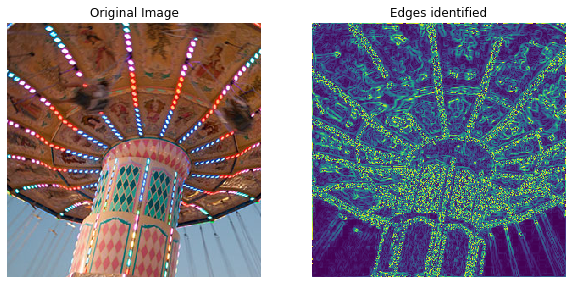

In [25]:
image = image_loader("sample_img.jpg")
grad = gradient_img(image)
unloader = transforms.ToPILImage()  # reconvert into PIL image

def imshow(tensor, fig, cell, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    fig.add_subplot(cell).set_title(title)
    plt.axis('off')
    plt.imshow(image)
    
fig = plt.figure(figsize=(10,10))
imshow(image, fig, cell=121, title='Original Image')
imshow(grad, fig, cell=122, title='Edges identified')

### Gradient Difference Penalty

$L_{grad} = ||\nabla{De(E(I+N))} - \nabla{I}||^{2}_{2}$

where $\nabla$ is gradient operator, $D$ is Decoder, $E$ is Encoder, $I$ is target image and  $N$ is noise

In [26]:
class GDLPenalty:
    
    def __init__(self, pred, target):
        
        self.loss = 0
        for pred_img, target_img in zip(pred, target):
            Grad_pred = self.gradient_img(pred_img)
            Grad_target = self.gradient_img(target_img)
            loss = torch.sum(torch.pow((Grad_pred - Grad_target), 2))
            self.loss += loss 

    def gradient_img(self, image):
    
        image = image.to(device)
        channels = torch.unbind(image)
        x = channels[0].unsqueeze(0).unsqueeze(0)

        # Gradient along x-direction
        Sobel_x = np.array([[1, 0, -1],[2,0,-2],[1,0,-1]])

        conv1 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
        conv1.weight = nn.Parameter(torch.from_numpy(Sobel_x).\
                                    float().unsqueeze(0).unsqueeze(0).to(device))
        Grad_x = conv1(Variable(x)).data.view(1,x.shape[2],x.shape[3])

        # Gradient along y-direction
        Sobel_y = np.array([[1, 2, 1],[0,0,0],[-1,-2,-1]])

        conv2 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
        conv2.weight = nn.Parameter(torch.from_numpy(Sobel_y).\
                                    float().unsqueeze(0).unsqueeze(0).to(device))
        Grad_y = conv2(Variable(x)).data.view(1,x.shape[2],x.shape[3])

        Grad_norm = torch.sqrt(torch.pow(Grad_x,2)+ torch.pow(Grad_y,2))

        return Grad_norm

In [27]:
class CreateGradients:
    def __init__(self, data_root, image_folder, path_to_save):
        
        self.loader = transforms.Compose([transforms.ToTensor(),])
        self.unloader = transforms.ToPILImage()
        self.image_path = os.path.join(data_root, image_folder)
        self.path_to_save = os.path.join(data_root, path_to_save)
        os.makedirs(self.path_to_save, exist_ok=True)
        
        if os.path.isdir(self.image_path):
            for img in tqdm(os.listdir(self.image_path)):
                image_name = os.path.join(self.image_path, img)
                image = self.image_loader(image_name)
                image_grad = self.gradient_img(image)
                image_name = os.path.join(self.path_to_save, img)
                self.save_image(image_grad, image_name)
                
    def image_loader(self, image_name):
        image = Image.open(image_name)
        image = self.loader(image)
        return image.to(self.device, torch.float)
    
    def save_image(self, tensor, name):
        image = tensor.cpu().squeeze(0)              # remove the fake batch dimension
        image = self.unloader(image)
        image.save(name)
    
    def gradient_img(self, image):
    
        channels = torch.unbind(image)
        x = channels[0].unsqueeze(0).unsqueeze(0)

        # Gradient along x-direction
        Sobel_x = np.array([[1, 0, -1],[2,0,-2],[1,0,-1]])
        conv1 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
        conv1.weight = nn.Parameter(torch.from_numpy(Sobel_x).\
                                    float().unsqueeze(0).unsqueeze(0).to(device))
        Grad_x = conv1(Variable(x)).data.view(1,x.shape[2],x.shape[3])

        # Gradient along y-direction
        Sobel_y = np.array([[1, 2, 1],[0,0,0],[-1,-2,-1]])
        conv2 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
        conv2.weight = nn.Parameter(torch.from_numpy(Sobel_y).\
                                    float().unsqueeze(0).unsqueeze(0).to(device))
        Grad_y = conv2(Variable(x)).data.view(1,x.shape[2],x.shape[3])
        Grad_norm = torch.sqrt(torch.pow(Grad_x,2)+ torch.pow(Grad_y,2))

        return Grad_norm

## Creating Custom Dataset

In [28]:
class CustomDataset:
    def __init__(self, data_root = 'PASCAL VOC 2012 Kaggle', img_folder = 'clean_images',
                 img_grad_folder = 'clean_img_grad', crop_size = (128, 128)):
        
        self.get_transforms = transforms.Compose([transforms.ToTensor(),])
        self.img_path = os.path.join(data_root, img_folder)
        #self.grad_path = os.path.join(data_root, img_grad_folder)
        self.clean_img_samples, self.noisy_img_samples = [], []
        #self.clean_img_grad_samples = []
        
        #for img, grad in zip(os.listdir(self.img_path), os.listdir(self.grad_path)):
        for img in os.listdir(self.img_path):
            image = Image.open(os.path.join(self.img_path, img))
            #grad = Image.open(os.path.join(self.grad_path, grad))
            crop_dims =  transforms.RandomCrop.get_params(image, output_size=crop_size)
            image = self.crop_and_transform(image, crop_dims)
            #grad = self.crop_and_transform(grad, crop_dims)
            self.clean_img_samples.append(image)
            #self.clean_img_grad_samples.append(grad)
            
            # Adding Gaussian Noise
            noisy_image = self.addGaussianNoise(image, mean=0, std=0.1, prob=0.3)
            self.noisy_img_samples.append(noisy_image)
    
    def crop_and_transform(self, img, crop_dims):
        image = TF.crop(img, *crop_dims)
        image = self.get_transforms(image)      # transform it into a torch tensor
        return image
        
    def addGaussianNoise(self, img, mean, std, prob):
        noise = img.new(img.size()).normal_(mean, std)
        likelihood = torch.distributions.binomial.Binomial(1, torch.tensor([prob]))
        return img + (noise * likelihood.sample())
    
    def LoadAllDatasets(self, batch_size):
        
        #all_datasets = list(zip(self.clean_img_samples, self.clean_img_grad_samples,
                               #self.noisy_img_samples))
            
        all_datasets = list(zip(self.clean_img_samples, self.noisy_img_samples))
        
        return DataLoader(all_datasets, batch_size, shuffle=True)
    
    def compute_gradient(self, image):
        
        image = image.to(device)
        channels = torch.unbind(image)
        x = channels[0].unsqueeze(0).unsqueeze(0)

        # Gradient along x-direction
        Sobel_x = np.array([[1, 0, -1],[2,0,-2],[1,0,-1]])
        conv1 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
        conv1.weight = nn.Parameter(torch.from_numpy(Sobel_x).\
                                    float().unsqueeze(0).unsqueeze(0).to(device))
        Grad_x = conv1(Variable(x)).data.view(1,x.shape[2],x.shape[3])

        # Gradient along y-direction
        Sobel_y = np.array([[1, 2, 1],[0,0,0],[-1,-2,-1]])
        conv2 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
        conv2.weight = nn.Parameter(torch.from_numpy(Sobel_y).\
                                    float().unsqueeze(0).unsqueeze(0).to(device))
        Grad_y = conv2(Variable(x)).data.view(1,x.shape[2],x.shape[3])
        Grad_norm = torch.sqrt(torch.pow(Grad_x,2)+ torch.pow(Grad_y,2))

        return Grad_norm

In [10]:
def show_images(images, nmax = 8):
    fig, ax = plt.subplots(figsize=(5,10))
    ax.set_xticks([]), ax.set_yticks([])
    ax.imshow(make_grid(images.type(torch.IntTensor), nrow = 2).permute(1,2,0))
    
def show_batch(loader):
    for images in loader:
        show_images(images)
        break
        
def full_image_loader(image_name, loader = transforms.Compose([transforms.ToTensor(),])):
    
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)  # fake batch dimension required to fit network's input dimensions
    return image.to(device).float()

## Pretrained Model : Comparing Decoder Output with Original Image

In [11]:
modelname = 'SparseAutoEncoder'
AutoEncoder = torch.load(modelname)
unloader = transforms.ToPILImage()

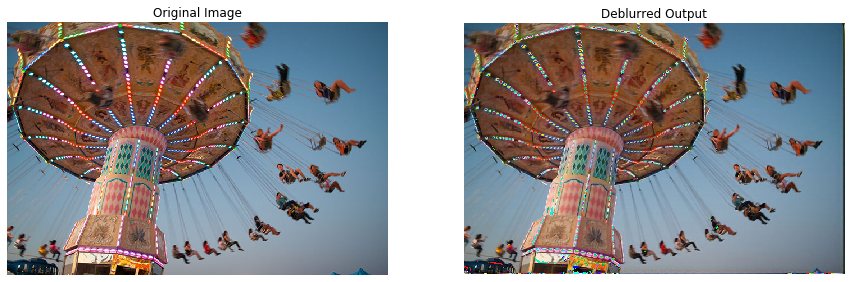

In [12]:
test_img = full_image_loader("sample_img.jpg")
output_img = AutoEncoder(test_img).cpu()
output_img = unloader(output_img.squeeze(0))
test_img = unloader(test_img.squeeze(0).cpu())
fig = plt.figure(figsize=(15,15))
fig.add_subplot(121).set_title('Original Image')
plt.axis('off')
plt.imshow(test_img)
fig.add_subplot(122).set_title('Deblurred Output')
plt.axis('off')
plt.imshow(output_img)

## Training the Sparse AutoEncoder
#### Run only if want to create new model

In [30]:
dataset = CustomDataset()
train_loader = dataset.LoadAllDatasets(8)

In [22]:
AutoEncoder = ResNetEncoder(ResBlock, image_channels = 3, layers=[2, 2, 1, 1, 2, 2]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(AutoEncoder.parameters(), lr=0.0002, betas=(0.9, 0.9999))
scale_factor = 0.1      # Tunning parameter for GDLoss
num_epochs = 20000
running_loss = []
for epoch in tqdm(range(num_epochs)):
    current_loss = []
    for I, N in train_loader:
        data = N.to(device)
        pred = AutoEncoder(data)             # Feed Forward
        mse_loss = criterion(pred, I.to(device))
        grad_loss = GDLPenalty(pred, I.to(device)).loss
        loss = mse_loss + scale_factor * grad_loss
        optimizer.zero_grad()        # Reset all Gradients to zero
        loss.backward()            # Accumulates all Gradients
        optimizer.step()         # Update the Parameters
        current_loss.append(loss.data.mean())
        torch.cuda.empty_cache()
    epoch_loss = sum(current_loss)/len(current_loss)
    running_loss.append(epoch_loss)
    print(f'Epoch - {epoch} and Loss - {epoch_loss}')


  0%|          | 1/2000 [00:13<7:26:27, 13.40s/it]

Epoch - 0 and Loss - 324.0151672363281



  0%|          | 2/2000 [00:28<7:40:34, 13.83s/it]

Epoch - 1 and Loss - 317.4486389160156



  0%|          | 3/2000 [00:45<8:16:33, 14.92s/it]

Epoch - 2 and Loss - 317.3404846191406



  0%|          | 4/2000 [01:03<8:44:18, 15.76s/it]

Epoch - 3 and Loss - 316.7568664550781



  0%|          | 5/2000 [01:21<9:03:26, 16.34s/it]

Epoch - 4 and Loss - 315.83477783203125



  0%|          | 6/2000 [01:38<9:15:19, 16.71s/it]

Epoch - 5 and Loss - 315.9644470214844



  0%|          | 7/2000 [01:56<9:22:53, 16.95s/it]

Epoch - 6 and Loss - 315.63079833984375



  0%|          | 8/2000 [02:13<9:29:35, 17.16s/it]

Epoch - 7 and Loss - 315.9078063964844



  0%|          | 9/2000 [02:35<10:15:02, 18.53s/it]

Epoch - 8 and Loss - 314.4812316894531



  0%|          | 10/2000 [03:06<12:17:05, 22.22s/it]

Epoch - 9 and Loss - 314.95513916015625



  1%|          | 11/2000 [03:30<12:34:40, 22.77s/it]

Epoch - 10 and Loss - 315.0938415527344



  1%|          | 12/2000 [03:48<11:43:05, 21.22s/it]

Epoch - 11 and Loss - 314.8617248535156



  1%|          | 13/2000 [04:05<11:05:57, 20.11s/it]

Epoch - 12 and Loss - 316.8268737792969



  1%|          | 14/2000 [04:23<10:39:41, 19.33s/it]

Epoch - 13 and Loss - 314.4222412109375



  1%|          | 15/2000 [04:40<10:21:17, 18.78s/it]

Epoch - 14 and Loss - 313.76556396484375



  1%|          | 16/2000 [04:58<10:08:09, 18.39s/it]

Epoch - 15 and Loss - 313.6369323730469



  1%|          | 17/2000 [05:15<9:59:12, 18.13s/it] 

Epoch - 16 and Loss - 313.6593933105469



  1%|          | 18/2000 [05:33<9:52:25, 17.93s/it]

Epoch - 17 and Loss - 313.83587646484375



  1%|          | 19/2000 [05:50<9:47:40, 17.80s/it]

Epoch - 18 and Loss - 313.8299560546875



  1%|          | 20/2000 [06:08<9:44:05, 17.70s/it]

Epoch - 19 and Loss - 313.2594909667969



  1%|          | 21/2000 [06:25<9:41:53, 17.64s/it]

Epoch - 20 and Loss - 313.6583557128906



  1%|          | 22/2000 [06:42<9:38:48, 17.56s/it]

Epoch - 21 and Loss - 313.3484191894531



  1%|          | 23/2000 [07:00<9:38:07, 17.55s/it]

Epoch - 22 and Loss - 313.21722412109375



  1%|          | 24/2000 [07:20<10:04:46, 18.36s/it]

Epoch - 23 and Loss - 312.83917236328125



  1%|▏         | 25/2000 [07:51<12:04:27, 22.01s/it]

Epoch - 24 and Loss - 312.9638366699219



  1%|▏         | 26/2000 [08:21<13:26:16, 24.51s/it]

Epoch - 25 and Loss - 313.6734313964844



  1%|▏         | 27/2000 [08:52<14:25:35, 26.32s/it]

Epoch - 26 and Loss - 312.1050720214844



  1%|▏         | 28/2000 [09:22<15:06:10, 27.57s/it]

Epoch - 27 and Loss - 313.1156921386719



  1%|▏         | 29/2000 [09:43<13:59:44, 25.56s/it]

Epoch - 28 and Loss - 312.3515930175781



  2%|▏         | 30/2000 [10:00<12:39:23, 23.13s/it]

Epoch - 29 and Loss - 312.50946044921875



  2%|▏         | 31/2000 [10:18<11:43:33, 21.44s/it]

Epoch - 30 and Loss - 312.9007263183594



  2%|▏         | 32/2000 [10:35<11:04:14, 20.25s/it]

Epoch - 31 and Loss - 312.13336181640625



  2%|▏         | 33/2000 [10:53<10:35:58, 19.40s/it]

Epoch - 32 and Loss - 312.7282409667969



  2%|▏         | 34/2000 [11:10<10:17:04, 18.83s/it]

Epoch - 33 and Loss - 313.7058410644531



  2%|▏         | 35/2000 [11:28<10:03:50, 18.44s/it]

Epoch - 34 and Loss - 311.849853515625



  2%|▏         | 36/2000 [11:57<11:49:28, 21.67s/it]

Epoch - 35 and Loss - 312.32232666015625



  2%|▏         | 37/2000 [12:28<13:16:17, 24.34s/it]

Epoch - 36 and Loss - 312.1786193847656



  2%|▏         | 38/2000 [12:58<14:17:20, 26.22s/it]

Epoch - 37 and Loss - 312.374755859375



  2%|▏         | 39/2000 [13:29<14:58:20, 27.49s/it]

Epoch - 38 and Loss - 312.74078369140625



  2%|▏         | 40/2000 [13:56<14:54:21, 27.38s/it]

Epoch - 39 and Loss - 311.5357666015625



  2%|▏         | 41/2000 [14:13<13:16:47, 24.40s/it]

Epoch - 40 and Loss - 311.6779479980469



  2%|▏         | 42/2000 [14:31<12:09:11, 22.35s/it]

Epoch - 41 and Loss - 311.5357666015625



  2%|▏         | 43/2000 [14:48<11:20:53, 20.88s/it]

Epoch - 42 and Loss - 311.7234802246094



  2%|▏         | 44/2000 [15:06<10:47:33, 19.86s/it]

Epoch - 43 and Loss - 311.7858581542969



  2%|▏         | 45/2000 [15:27<11:02:39, 20.34s/it]

Epoch - 44 and Loss - 311.25848388671875



  2%|▏         | 46/2000 [15:58<12:41:59, 23.40s/it]

Epoch - 45 and Loss - 311.2509460449219



  2%|▏         | 47/2000 [16:28<13:52:09, 25.57s/it]

Epoch - 46 and Loss - 311.5990295410156



  2%|▏         | 48/2000 [16:59<14:42:47, 27.13s/it]

Epoch - 47 and Loss - 310.9079284667969



  2%|▏         | 49/2000 [17:30<15:17:31, 28.22s/it]

Epoch - 48 and Loss - 310.3794250488281



  2%|▎         | 50/2000 [18:01<15:40:50, 28.95s/it]

Epoch - 49 and Loss - 312.49285888671875



  3%|▎         | 51/2000 [18:28<15:28:57, 28.60s/it]

Epoch - 50 and Loss - 310.78289794921875



  3%|▎         | 52/2000 [18:46<13:40:22, 25.27s/it]

Epoch - 51 and Loss - 310.86053466796875



  3%|▎         | 53/2000 [19:03<12:23:32, 22.91s/it]

Epoch - 52 and Loss - 311.2216796875



  3%|▎         | 54/2000 [19:21<11:31:26, 21.32s/it]

Epoch - 53 and Loss - 310.9989929199219



  3%|▎         | 55/2000 [19:44<11:53:39, 22.02s/it]

Epoch - 54 and Loss - 310.9387512207031



  3%|▎         | 56/2000 [20:15<13:15:43, 24.56s/it]

Epoch - 55 and Loss - 311.6877746582031



  3%|▎         | 57/2000 [20:45<14:13:29, 26.36s/it]

Epoch - 56 and Loss - 310.37835693359375



  3%|▎         | 58/2000 [21:16<14:52:58, 27.59s/it]

Epoch - 57 and Loss - 311.6437072753906



  3%|▎         | 59/2000 [21:46<15:20:39, 28.46s/it]

Epoch - 58 and Loss - 310.4138488769531



  3%|▎         | 60/2000 [22:15<15:18:18, 28.40s/it]

Epoch - 59 and Loss - 310.6591796875



  3%|▎         | 61/2000 [22:32<13:32:04, 25.13s/it]

Epoch - 60 and Loss - 310.3813171386719



  3%|▎         | 62/2000 [22:50<12:18:14, 22.86s/it]

Epoch - 61 and Loss - 310.6482849121094



  3%|▎         | 63/2000 [23:07<11:26:17, 21.26s/it]

Epoch - 62 and Loss - 310.0820007324219



  3%|▎         | 64/2000 [23:27<11:07:34, 20.69s/it]

Epoch - 63 and Loss - 310.4654541015625



  3%|▎         | 65/2000 [23:57<12:43:21, 23.67s/it]

Epoch - 64 and Loss - 310.6591796875



  3%|▎         | 66/2000 [24:28<13:50:36, 25.77s/it]

Epoch - 65 and Loss - 315.7448425292969



  3%|▎         | 67/2000 [24:59<14:36:40, 27.21s/it]

Epoch - 66 and Loss - 310.22503662109375



  3%|▎         | 68/2000 [25:29<15:08:07, 28.20s/it]

Epoch - 67 and Loss - 309.5932922363281



  3%|▎         | 69/2000 [26:00<15:30:47, 28.92s/it]

Epoch - 68 and Loss - 309.9278869628906



  4%|▎         | 70/2000 [26:27<15:17:22, 28.52s/it]

Epoch - 69 and Loss - 309.7064514160156



  4%|▎         | 71/2000 [26:45<13:30:41, 25.22s/it]

Epoch - 70 and Loss - 309.6630859375



  4%|▎         | 72/2000 [27:02<12:14:51, 22.87s/it]

Epoch - 71 and Loss - 309.7806701660156



  4%|▎         | 73/2000 [27:20<11:22:37, 21.25s/it]

Epoch - 72 and Loss - 308.7749328613281



  4%|▎         | 74/2000 [27:37<10:45:37, 20.11s/it]

Epoch - 73 and Loss - 309.5821838378906



  4%|▍         | 75/2000 [28:08<12:25:24, 23.23s/it]

Epoch - 74 and Loss - 308.7559814453125



  4%|▍         | 76/2000 [28:38<13:34:26, 25.40s/it]

Epoch - 75 and Loss - 310.05029296875



  4%|▍         | 77/2000 [29:09<14:23:43, 26.95s/it]

Epoch - 76 and Loss - 309.4208068847656



  4%|▍         | 78/2000 [29:39<14:57:21, 28.01s/it]

Epoch - 77 and Loss - 310.1111145019531



  4%|▍         | 79/2000 [30:10<15:20:23, 28.75s/it]

Epoch - 78 and Loss - 308.7395935058594



  4%|▍         | 80/2000 [30:40<15:35:31, 29.24s/it]

Epoch - 79 and Loss - 309.35931396484375



  4%|▍         | 81/2000 [31:10<15:47:15, 29.62s/it]

Epoch - 80 and Loss - 309.2712097167969



  4%|▍         | 82/2000 [31:41<15:55:27, 29.89s/it]

Epoch - 81 and Loss - 309.96295166015625



  4%|▍         | 83/2000 [32:00<14:14:05, 26.73s/it]

Epoch - 82 and Loss - 309.06451416015625



  4%|▍         | 84/2000 [32:18<12:44:51, 23.95s/it]

Epoch - 83 and Loss - 308.8872375488281



  4%|▍         | 85/2000 [32:35<11:42:55, 22.02s/it]

Epoch - 84 and Loss - 309.6900634765625



  4%|▍         | 86/2000 [32:53<11:03:14, 20.79s/it]

Epoch - 85 and Loss - 309.29742431640625



  4%|▍         | 87/2000 [33:24<12:36:43, 23.73s/it]

Epoch - 86 and Loss - 308.870361328125



  4%|▍         | 88/2000 [33:54<13:40:57, 25.76s/it]

Epoch - 87 and Loss - 308.69476318359375



  4%|▍         | 89/2000 [34:25<14:25:48, 27.18s/it]

Epoch - 88 and Loss - 309.34320068359375



  4%|▍         | 90/2000 [34:55<14:56:34, 28.16s/it]

Epoch - 89 and Loss - 308.9495544433594



  5%|▍         | 91/2000 [35:26<15:18:28, 28.87s/it]

Epoch - 90 and Loss - 308.9139404296875



  5%|▍         | 92/2000 [35:56<15:32:20, 29.32s/it]

Epoch - 91 and Loss - 308.0794982910156



  5%|▍         | 93/2000 [36:27<15:43:18, 29.68s/it]

Epoch - 92 and Loss - 310.3038024902344



  5%|▍         | 94/2000 [36:46<14:00:45, 26.47s/it]

Epoch - 93 and Loss - 308.37384033203125



  5%|▍         | 95/2000 [37:03<12:34:58, 23.78s/it]

Epoch - 94 and Loss - 309.04644775390625



  5%|▍         | 96/2000 [37:21<11:35:33, 21.92s/it]

Epoch - 95 and Loss - 308.7630920410156



  5%|▍         | 97/2000 [37:38<10:53:38, 20.61s/it]

Epoch - 96 and Loss - 308.85821533203125



  5%|▍         | 98/2000 [38:07<12:13:56, 23.15s/it]

Epoch - 97 and Loss - 308.8305358886719



  5%|▍         | 99/2000 [38:38<13:23:10, 25.35s/it]

Epoch - 98 and Loss - 309.1947021484375



  5%|▌         | 100/2000 [39:08<14:12:42, 26.93s/it]

Epoch - 99 and Loss - 308.92486572265625



  5%|▌         | 101/2000 [39:39<14:47:57, 28.06s/it]

Epoch - 100 and Loss - 307.9155578613281



  5%|▌         | 102/2000 [40:10<15:11:38, 28.82s/it]

Epoch - 101 and Loss - 309.0842590332031



  5%|▌         | 103/2000 [40:40<15:27:19, 29.33s/it]

Epoch - 102 and Loss - 309.6927185058594



  5%|▌         | 104/2000 [41:11<15:40:13, 29.75s/it]

Epoch - 103 and Loss - 309.24993896484375



  5%|▌         | 105/2000 [41:37<15:02:11, 28.57s/it]

Epoch - 104 and Loss - 313.1130065917969



  5%|▌         | 106/2000 [41:54<13:15:42, 25.21s/it]

Epoch - 105 and Loss - 309.8436279296875



  5%|▌         | 107/2000 [42:12<12:01:18, 22.86s/it]

Epoch - 106 and Loss - 309.00616455078125



  5%|▌         | 108/2000 [42:29<11:12:48, 21.34s/it]

Epoch - 107 and Loss - 308.3148498535156



  5%|▌         | 109/2000 [42:52<11:23:57, 21.70s/it]

Epoch - 108 and Loss - 307.93389892578125



  6%|▌         | 110/2000 [43:22<12:47:22, 24.36s/it]

Epoch - 109 and Loss - 308.3797607421875



  6%|▌         | 111/2000 [43:53<13:44:40, 26.19s/it]

Epoch - 110 and Loss - 307.98944091796875



  6%|▌         | 112/2000 [44:22<14:13:47, 27.13s/it]

Epoch - 111 and Loss - 307.6107482910156



  6%|▌         | 113/2000 [44:50<14:18:49, 27.31s/it]

Epoch - 112 and Loss - 307.909912109375



  6%|▌         | 114/2000 [45:18<14:22:48, 27.45s/it]

Epoch - 113 and Loss - 307.9617004394531



  6%|▌         | 115/2000 [45:46<14:25:15, 27.54s/it]

Epoch - 114 and Loss - 307.2477111816406



  6%|▌         | 116/2000 [46:13<14:26:41, 27.60s/it]

Epoch - 115 and Loss - 306.9841613769531



  6%|▌         | 117/2000 [46:41<14:29:13, 27.70s/it]

Epoch - 116 and Loss - 307.36181640625



  6%|▌         | 118/2000 [47:09<14:29:48, 27.73s/it]

Epoch - 117 and Loss - 308.2931823730469



  6%|▌         | 119/2000 [47:37<14:30:35, 27.77s/it]

Epoch - 118 and Loss - 308.1955261230469



  6%|▌         | 120/2000 [48:05<14:30:26, 27.78s/it]

Epoch - 119 and Loss - 308.0335388183594



  6%|▌         | 121/2000 [48:32<14:28:53, 27.75s/it]

Epoch - 120 and Loss - 307.20709228515625



  6%|▌         | 122/2000 [49:00<14:30:43, 27.82s/it]

Epoch - 121 and Loss - 308.1001892089844



  6%|▌         | 123/2000 [49:28<14:30:26, 27.82s/it]

Epoch - 122 and Loss - 307.18157958984375



  6%|▌         | 124/2000 [49:56<14:29:56, 27.82s/it]

Epoch - 123 and Loss - 306.9742736816406



  6%|▋         | 125/2000 [50:24<14:28:58, 27.81s/it]

Epoch - 124 and Loss - 307.1122131347656



  6%|▋         | 126/2000 [50:52<14:28:31, 27.81s/it]

Epoch - 125 and Loss - 307.0644836425781



  6%|▋         | 127/2000 [51:19<14:27:45, 27.80s/it]

Epoch - 126 and Loss - 307.11590576171875



  6%|▋         | 128/2000 [51:47<14:26:52, 27.78s/it]

Epoch - 127 and Loss - 307.43426513671875



  6%|▋         | 129/2000 [52:15<14:25:03, 27.74s/it]

Epoch - 128 and Loss - 307.4331970214844



  6%|▋         | 130/2000 [52:42<14:24:00, 27.72s/it]

Epoch - 129 and Loss - 308.3586730957031



  7%|▋         | 131/2000 [53:10<14:22:56, 27.70s/it]

Epoch - 130 and Loss - 307.8523254394531



  7%|▋         | 132/2000 [53:38<14:22:18, 27.70s/it]

Epoch - 131 and Loss - 307.2698059082031



  7%|▋         | 133/2000 [54:05<14:21:54, 27.70s/it]

Epoch - 132 and Loss - 306.94683837890625



  7%|▋         | 134/2000 [54:33<14:20:48, 27.68s/it]

Epoch - 133 and Loss - 307.4546813964844



  7%|▋         | 135/2000 [55:01<14:19:38, 27.66s/it]

Epoch - 134 and Loss - 308.34295654296875



  7%|▋         | 136/2000 [55:29<14:22:45, 27.77s/it]

Epoch - 135 and Loss - 307.2769470214844



  7%|▋         | 137/2000 [55:57<14:23:47, 27.82s/it]

Epoch - 136 and Loss - 307.152587890625



  7%|▋         | 138/2000 [56:25<14:24:44, 27.87s/it]

Epoch - 137 and Loss - 306.70684814453125



  7%|▋         | 139/2000 [56:53<14:28:14, 27.99s/it]

Epoch - 138 and Loss - 306.5112609863281



  7%|▋         | 140/2000 [57:21<14:29:39, 28.05s/it]

Epoch - 139 and Loss - 306.8639221191406



  7%|▋         | 141/2000 [57:49<14:26:59, 27.98s/it]

Epoch - 140 and Loss - 306.7252197265625



  7%|▋         | 142/2000 [58:17<14:25:42, 27.96s/it]

Epoch - 141 and Loss - 306.4485778808594



  7%|▋         | 143/2000 [58:44<14:22:39, 27.87s/it]

Epoch - 142 and Loss - 311.697998046875



  7%|▋         | 144/2000 [59:12<14:20:07, 27.81s/it]

Epoch - 143 and Loss - 306.8519592285156



  7%|▋         | 145/2000 [59:40<14:18:18, 27.76s/it]

Epoch - 144 and Loss - 307.0473937988281



  7%|▋         | 146/2000 [1:00:08<14:18:44, 27.79s/it]

Epoch - 145 and Loss - 307.4813537597656



  7%|▋         | 147/2000 [1:00:36<14:23:52, 27.97s/it]

Epoch - 146 and Loss - 306.6714172363281



  7%|▋         | 148/2000 [1:01:04<14:21:55, 27.92s/it]

Epoch - 147 and Loss - 306.39959716796875



  7%|▋         | 149/2000 [1:01:32<14:25:09, 28.04s/it]

Epoch - 148 and Loss - 306.1021423339844



  8%|▊         | 150/2000 [1:02:00<14:24:08, 28.03s/it]

Epoch - 149 and Loss - 306.3093566894531



  8%|▊         | 151/2000 [1:02:28<14:25:04, 28.07s/it]

Epoch - 150 and Loss - 305.628173828125



  8%|▊         | 152/2000 [1:02:56<14:25:22, 28.10s/it]

Epoch - 151 and Loss - 305.5888977050781



  8%|▊         | 153/2000 [1:03:24<14:21:31, 27.99s/it]

Epoch - 152 and Loss - 305.7403869628906



  8%|▊         | 154/2000 [1:03:52<14:18:54, 27.92s/it]

Epoch - 153 and Loss - 305.3312683105469



  8%|▊         | 155/2000 [1:04:20<14:22:06, 28.04s/it]

Epoch - 154 and Loss - 306.709228515625



  8%|▊         | 156/2000 [1:04:49<14:26:06, 28.18s/it]

Epoch - 155 and Loss - 305.6873474121094



  8%|▊         | 157/2000 [1:05:17<14:21:56, 28.06s/it]

Epoch - 156 and Loss - 305.71612548828125



  8%|▊         | 158/2000 [1:05:44<14:19:15, 27.99s/it]

Epoch - 157 and Loss - 305.5500793457031



  8%|▊         | 159/2000 [1:06:12<14:17:15, 27.94s/it]

Epoch - 158 and Loss - 305.3857421875



  8%|▊         | 160/2000 [1:06:40<14:17:45, 27.97s/it]

Epoch - 159 and Loss - 305.6188049316406



  8%|▊         | 161/2000 [1:07:08<14:16:57, 27.96s/it]

Epoch - 160 and Loss - 305.0660400390625



  8%|▊         | 162/2000 [1:07:36<14:16:22, 27.96s/it]

Epoch - 161 and Loss - 306.1382141113281



  8%|▊         | 163/2000 [1:08:04<14:14:45, 27.92s/it]

Epoch - 162 and Loss - 305.06646728515625



  8%|▊         | 164/2000 [1:08:32<14:12:18, 27.85s/it]

Epoch - 163 and Loss - 305.83197021484375



  8%|▊         | 165/2000 [1:08:59<14:10:32, 27.81s/it]

Epoch - 164 and Loss - 304.77484130859375



  8%|▊         | 166/2000 [1:09:27<14:12:21, 27.89s/it]

Epoch - 165 and Loss - 305.4568786621094



  8%|▊         | 167/2000 [1:09:55<14:10:45, 27.85s/it]

Epoch - 166 and Loss - 305.3469543457031



  8%|▊         | 168/2000 [1:10:23<14:10:45, 27.86s/it]

Epoch - 167 and Loss - 305.38336181640625



  8%|▊         | 169/2000 [1:10:52<14:16:34, 28.07s/it]

Epoch - 168 and Loss - 305.0859375



  8%|▊         | 170/2000 [1:11:20<14:16:37, 28.09s/it]

Epoch - 169 and Loss - 304.95550537109375



  9%|▊         | 171/2000 [1:11:48<14:18:20, 28.16s/it]

Epoch - 170 and Loss - 305.7036437988281



  9%|▊         | 172/2000 [1:12:16<14:14:49, 28.06s/it]

Epoch - 171 and Loss - 305.6711120605469



  9%|▊         | 173/2000 [1:12:44<14:10:30, 27.93s/it]

Epoch - 172 and Loss - 304.7790832519531



  9%|▊         | 174/2000 [1:13:11<14:07:29, 27.85s/it]

Epoch - 173 and Loss - 304.6906433105469



  9%|▉         | 175/2000 [1:13:39<14:05:23, 27.79s/it]

Epoch - 174 and Loss - 305.6693115234375



  9%|▉         | 176/2000 [1:14:07<14:03:27, 27.75s/it]

Epoch - 175 and Loss - 304.60614013671875



  9%|▉         | 177/2000 [1:14:34<14:02:13, 27.72s/it]

Epoch - 176 and Loss - 304.6553649902344



  9%|▉         | 178/2000 [1:15:02<14:01:01, 27.70s/it]

Epoch - 177 and Loss - 304.513916015625



  9%|▉         | 179/2000 [1:15:30<14:00:17, 27.69s/it]

Epoch - 178 and Loss - 304.885009765625



  9%|▉         | 180/2000 [1:15:57<13:59:07, 27.66s/it]

Epoch - 179 and Loss - 305.42431640625



  9%|▉         | 181/2000 [1:16:25<13:59:59, 27.71s/it]

Epoch - 180 and Loss - 305.3747863769531



  9%|▉         | 182/2000 [1:16:53<14:01:53, 27.78s/it]

Epoch - 181 and Loss - 304.1088562011719



  9%|▉         | 183/2000 [1:17:21<14:00:51, 27.77s/it]

Epoch - 182 and Loss - 304.9075927734375



  9%|▉         | 184/2000 [1:17:48<13:59:00, 27.72s/it]

Epoch - 183 and Loss - 304.3935241699219



  9%|▉         | 185/2000 [1:18:16<13:57:39, 27.69s/it]

Epoch - 184 and Loss - 304.8593444824219



  9%|▉         | 186/2000 [1:18:44<13:57:42, 27.71s/it]

Epoch - 185 and Loss - 303.8266296386719



  9%|▉         | 187/2000 [1:19:11<13:56:44, 27.69s/it]

Epoch - 186 and Loss - 305.9935607910156



  9%|▉         | 188/2000 [1:19:39<13:55:54, 27.68s/it]

Epoch - 187 and Loss - 304.55853271484375



  9%|▉         | 189/2000 [1:20:07<13:56:04, 27.70s/it]

Epoch - 188 and Loss - 304.4261474609375



 10%|▉         | 190/2000 [1:20:34<13:54:37, 27.67s/it]

Epoch - 189 and Loss - 304.1527099609375



 10%|▉         | 191/2000 [1:21:02<13:54:00, 27.66s/it]

Epoch - 190 and Loss - 304.9822082519531



 10%|▉         | 192/2000 [1:21:30<13:53:13, 27.65s/it]

Epoch - 191 and Loss - 304.8023376464844



 10%|▉         | 193/2000 [1:21:57<13:52:19, 27.64s/it]

Epoch - 192 and Loss - 303.9075012207031



 10%|▉         | 194/2000 [1:22:25<13:52:12, 27.65s/it]

Epoch - 193 and Loss - 304.1764221191406



 10%|▉         | 195/2000 [1:22:52<13:52:09, 27.66s/it]

Epoch - 194 and Loss - 303.74249267578125



 10%|▉         | 196/2000 [1:23:20<13:53:34, 27.72s/it]

Epoch - 195 and Loss - 303.57879638671875



 10%|▉         | 197/2000 [1:23:49<13:57:36, 27.87s/it]

Epoch - 196 and Loss - 304.02691650390625



 10%|▉         | 198/2000 [1:24:16<13:57:07, 27.87s/it]

Epoch - 197 and Loss - 304.0508117675781



 10%|▉         | 199/2000 [1:24:44<13:57:28, 27.90s/it]

Epoch - 198 and Loss - 303.4110107421875



 10%|█         | 200/2000 [1:25:12<13:54:46, 27.83s/it]

Epoch - 199 and Loss - 304.5718994140625



 10%|█         | 201/2000 [1:25:40<13:52:25, 27.76s/it]

Epoch - 200 and Loss - 304.47198486328125



 10%|█         | 202/2000 [1:26:07<13:50:50, 27.73s/it]

Epoch - 201 and Loss - 306.92724609375



 10%|█         | 203/2000 [1:26:35<13:49:37, 27.70s/it]

Epoch - 202 and Loss - 304.01177978515625



 10%|█         | 204/2000 [1:27:03<13:48:19, 27.67s/it]

Epoch - 203 and Loss - 303.8185729980469



 10%|█         | 205/2000 [1:27:30<13:47:49, 27.67s/it]

Epoch - 204 and Loss - 303.24713134765625



 10%|█         | 206/2000 [1:27:59<13:56:11, 27.97s/it]

Epoch - 205 and Loss - 304.2295227050781



 10%|█         | 207/2000 [1:28:28<14:09:43, 28.43s/it]

Epoch - 206 and Loss - 303.5999755859375



 10%|█         | 208/2000 [1:28:58<14:18:30, 28.74s/it]

Epoch - 207 and Loss - 303.5142822265625



 10%|█         | 209/2000 [1:29:29<14:37:54, 29.41s/it]

Epoch - 208 and Loss - 303.3985900878906



 10%|█         | 210/2000 [1:29:59<14:43:24, 29.61s/it]

Epoch - 209 and Loss - 304.1583557128906



 11%|█         | 211/2000 [1:30:27<14:31:35, 29.23s/it]

Epoch - 210 and Loss - 304.0240478515625



 11%|█         | 212/2000 [1:30:56<14:25:57, 29.06s/it]

Epoch - 211 and Loss - 309.8873596191406



 11%|█         | 213/2000 [1:31:25<14:23:26, 28.99s/it]

Epoch - 212 and Loss - 304.1720886230469



 11%|█         | 214/2000 [1:31:53<14:20:28, 28.91s/it]

Epoch - 213 and Loss - 303.76422119140625



 11%|█         | 215/2000 [1:32:23<14:26:13, 29.12s/it]

Epoch - 214 and Loss - 303.9433898925781



 11%|█         | 216/2000 [1:32:52<14:24:15, 29.07s/it]

Epoch - 215 and Loss - 303.0573425292969



 11%|█         | 217/2000 [1:33:20<14:17:57, 28.87s/it]

Epoch - 216 and Loss - 303.7596435546875



 11%|█         | 218/2000 [1:33:49<14:17:05, 28.86s/it]

Epoch - 217 and Loss - 303.5556335449219



 11%|█         | 219/2000 [1:34:19<14:24:12, 29.11s/it]

Epoch - 218 and Loss - 303.8865051269531



 11%|█         | 220/2000 [1:34:50<14:38:51, 29.62s/it]

Epoch - 219 and Loss - 303.56268310546875



 11%|█         | 221/2000 [1:35:18<14:29:55, 29.34s/it]

Epoch - 220 and Loss - 303.72930908203125



 11%|█         | 222/2000 [1:35:48<14:30:53, 29.39s/it]

Epoch - 221 and Loss - 302.9841613769531



 11%|█         | 223/2000 [1:36:17<14:30:20, 29.39s/it]

Epoch - 222 and Loss - 303.6364440917969



 11%|█         | 224/2000 [1:36:46<14:20:32, 29.07s/it]

Epoch - 223 and Loss - 303.1134033203125



 11%|█▏        | 225/2000 [1:37:15<14:19:26, 29.05s/it]

Epoch - 224 and Loss - 303.1672668457031



 11%|█▏        | 226/2000 [1:37:43<14:11:10, 28.79s/it]

Epoch - 225 and Loss - 302.68829345703125



 11%|█▏        | 227/2000 [1:38:11<14:05:21, 28.61s/it]

Epoch - 226 and Loss - 302.5959167480469



 11%|█▏        | 228/2000 [1:38:39<13:59:37, 28.43s/it]

Epoch - 227 and Loss - 302.71685791015625



 11%|█▏        | 229/2000 [1:39:07<13:57:14, 28.37s/it]

Epoch - 228 and Loss - 302.7043762207031



 12%|█▏        | 230/2000 [1:39:35<13:50:26, 28.15s/it]

Epoch - 229 and Loss - 303.1600341796875



 12%|█▏        | 231/2000 [1:40:03<13:45:06, 27.99s/it]

Epoch - 230 and Loss - 302.84002685546875



 12%|█▏        | 232/2000 [1:40:30<13:43:23, 27.94s/it]

Epoch - 231 and Loss - 302.5260009765625



 12%|█▏        | 233/2000 [1:40:58<13:41:27, 27.89s/it]

Epoch - 232 and Loss - 303.017578125



 12%|█▏        | 234/2000 [1:41:27<13:45:13, 28.04s/it]

Epoch - 233 and Loss - 302.78985595703125



 12%|█▏        | 235/2000 [1:41:55<13:47:42, 28.14s/it]

Epoch - 234 and Loss - 303.1864929199219



 12%|█▏        | 236/2000 [1:42:23<13:45:20, 28.07s/it]

Epoch - 235 and Loss - 302.57171630859375



 12%|█▏        | 237/2000 [1:42:51<13:47:37, 28.17s/it]

Epoch - 236 and Loss - 303.1029357910156



 12%|█▏        | 238/2000 [1:43:19<13:46:41, 28.15s/it]

Epoch - 237 and Loss - 305.39190673828125



 12%|█▏        | 239/2000 [1:43:47<13:45:52, 28.14s/it]

Epoch - 238 and Loss - 303.05059814453125



 12%|█▏        | 240/2000 [1:44:15<13:41:02, 27.99s/it]

Epoch - 239 and Loss - 303.3946838378906



 12%|█▏        | 241/2000 [1:44:43<13:41:14, 28.01s/it]

Epoch - 240 and Loss - 302.86773681640625



 12%|█▏        | 242/2000 [1:45:13<13:55:38, 28.52s/it]

Epoch - 241 and Loss - 302.24847412109375



 12%|█▏        | 243/2000 [1:45:41<13:52:09, 28.42s/it]

Epoch - 242 and Loss - 302.5458984375



 12%|█▏        | 244/2000 [1:46:09<13:47:06, 28.26s/it]

Epoch - 243 and Loss - 302.2808837890625



 12%|█▏        | 245/2000 [1:46:37<13:44:04, 28.17s/it]

Epoch - 244 and Loss - 302.8428955078125



 12%|█▏        | 246/2000 [1:47:05<13:42:20, 28.13s/it]

Epoch - 245 and Loss - 303.07244873046875



 12%|█▏        | 247/2000 [1:47:33<13:41:43, 28.12s/it]

Epoch - 246 and Loss - 302.5815124511719



 12%|█▏        | 248/2000 [1:48:01<13:39:56, 28.08s/it]

Epoch - 247 and Loss - 303.21502685546875



 12%|█▏        | 249/2000 [1:48:29<13:36:21, 27.97s/it]

Epoch - 248 and Loss - 302.638671875



 12%|█▎        | 250/2000 [1:48:56<13:33:55, 27.91s/it]

Epoch - 249 and Loss - 302.3692932128906



 13%|█▎        | 251/2000 [1:49:24<13:31:58, 27.85s/it]

Epoch - 250 and Loss - 303.1494445800781



 13%|█▎        | 252/2000 [1:49:52<13:28:57, 27.77s/it]

Epoch - 251 and Loss - 301.884521484375



 13%|█▎        | 253/2000 [1:50:20<13:31:50, 27.88s/it]

Epoch - 252 and Loss - 302.90093994140625



 13%|█▎        | 254/2000 [1:50:49<13:42:19, 28.26s/it]

Epoch - 253 and Loss - 302.7688903808594



 13%|█▎        | 255/2000 [1:51:18<13:43:54, 28.33s/it]

Epoch - 254 and Loss - 301.8194580078125



 13%|█▎        | 256/2000 [1:51:45<13:37:16, 28.12s/it]

Epoch - 255 and Loss - 303.28216552734375



 13%|█▎        | 257/2000 [1:52:13<13:32:29, 27.97s/it]

Epoch - 256 and Loss - 302.5437927246094



 13%|█▎        | 258/2000 [1:52:41<13:32:30, 27.99s/it]

Epoch - 257 and Loss - 303.0253601074219



 13%|█▎        | 259/2000 [1:53:10<13:40:04, 28.26s/it]

Epoch - 258 and Loss - 302.2843322753906



 13%|█▎        | 260/2000 [1:53:40<13:59:55, 28.96s/it]

Epoch - 259 and Loss - 302.0522155761719



 13%|█▎        | 261/2000 [1:54:10<14:01:58, 29.05s/it]

Epoch - 260 and Loss - 303.0461730957031



 13%|█▎        | 262/2000 [1:54:38<13:58:24, 28.94s/it]

Epoch - 261 and Loss - 302.7572021484375



 13%|█▎        | 263/2000 [1:55:08<14:04:44, 29.18s/it]

Epoch - 262 and Loss - 302.0357360839844



 13%|█▎        | 264/2000 [1:55:36<13:53:57, 28.82s/it]

Epoch - 263 and Loss - 301.3072814941406



 13%|█▎        | 265/2000 [1:56:06<14:00:17, 29.06s/it]

Epoch - 264 and Loss - 303.03887939453125



 13%|█▎        | 266/2000 [1:56:34<13:56:07, 28.93s/it]

Epoch - 265 and Loss - 301.8247375488281



 13%|█▎        | 267/2000 [1:57:04<14:00:50, 29.11s/it]

Epoch - 266 and Loss - 301.838134765625



 13%|█▎        | 268/2000 [1:57:33<14:03:47, 29.23s/it]

Epoch - 267 and Loss - 301.9372253417969



 13%|█▎        | 269/2000 [1:58:01<13:50:01, 28.77s/it]

Epoch - 268 and Loss - 302.0441589355469



 14%|█▎        | 270/2000 [1:58:31<13:56:44, 29.02s/it]

Epoch - 269 and Loss - 302.32757568359375



 14%|█▎        | 271/2000 [1:59:00<13:56:37, 29.03s/it]

Epoch - 270 and Loss - 301.9688415527344



 14%|█▎        | 272/2000 [1:59:28<13:48:30, 28.77s/it]

Epoch - 271 and Loss - 301.6894836425781



 14%|█▎        | 273/2000 [1:59:56<13:42:27, 28.57s/it]

Epoch - 272 and Loss - 302.2331237792969



 14%|█▎        | 274/2000 [2:00:25<13:46:48, 28.74s/it]

Epoch - 273 and Loss - 301.8870544433594



 14%|█▍        | 275/2000 [2:00:54<13:47:04, 28.77s/it]

Epoch - 274 and Loss - 302.3283996582031



 14%|█▍        | 276/2000 [2:01:22<13:40:47, 28.57s/it]

Epoch - 275 and Loss - 301.66387939453125



 14%|█▍        | 277/2000 [2:01:52<13:53:53, 29.04s/it]

Epoch - 276 and Loss - 301.6841735839844



 14%|█▍        | 278/2000 [2:02:20<13:47:15, 28.82s/it]

Epoch - 277 and Loss - 301.7433776855469



 14%|█▍        | 279/2000 [2:02:50<13:49:24, 28.92s/it]

Epoch - 278 and Loss - 302.34112548828125



 14%|█▍        | 280/2000 [2:03:17<13:38:16, 28.54s/it]

Epoch - 279 and Loss - 302.2560729980469



 14%|█▍        | 281/2000 [2:03:45<13:32:45, 28.37s/it]

Epoch - 280 and Loss - 302.4697265625



 14%|█▍        | 282/2000 [2:04:15<13:41:50, 28.70s/it]

Epoch - 281 and Loss - 301.51361083984375



 14%|█▍        | 283/2000 [2:04:45<13:57:48, 29.28s/it]

Epoch - 282 and Loss - 302.7301330566406



 14%|█▍        | 284/2000 [2:05:15<14:01:27, 29.42s/it]

Epoch - 283 and Loss - 301.1428527832031



 14%|█▍        | 285/2000 [2:05:44<13:59:12, 29.36s/it]

Epoch - 284 and Loss - 302.0956115722656



 14%|█▍        | 286/2000 [2:06:13<13:55:20, 29.24s/it]

Epoch - 285 and Loss - 302.0148620605469



 14%|█▍        | 287/2000 [2:06:44<14:03:29, 29.54s/it]

Epoch - 286 and Loss - 302.01019287109375



 14%|█▍        | 288/2000 [2:07:14<14:11:59, 29.86s/it]

Epoch - 287 and Loss - 301.2577819824219



 14%|█▍        | 289/2000 [2:07:45<14:20:43, 30.18s/it]

Epoch - 288 and Loss - 301.43743896484375



 14%|█▍        | 290/2000 [2:08:17<14:32:19, 30.61s/it]

Epoch - 289 and Loss - 301.8855895996094



 15%|█▍        | 291/2000 [2:08:49<14:45:00, 31.07s/it]

Epoch - 290 and Loss - 301.5938415527344



 15%|█▍        | 292/2000 [2:09:20<14:49:31, 31.25s/it]

Epoch - 291 and Loss - 302.26324462890625



 15%|█▍        | 293/2000 [2:09:49<14:24:21, 30.38s/it]

Epoch - 292 and Loss - 301.4395446777344



 15%|█▍        | 294/2000 [2:10:07<12:36:14, 26.60s/it]

Epoch - 293 and Loss - 301.815185546875



 15%|█▍        | 295/2000 [2:10:25<11:24:03, 24.07s/it]

Epoch - 294 and Loss - 302.30621337890625



 15%|█▍        | 296/2000 [2:10:43<10:30:26, 22.20s/it]

Epoch - 295 and Loss - 303.5863037109375



 15%|█▍        | 297/2000 [2:11:00<9:51:09, 20.83s/it] 

Epoch - 296 and Loss - 301.7777099609375



 15%|█▍        | 298/2000 [2:11:18<9:24:40, 19.91s/it]

Epoch - 297 and Loss - 301.4375



 15%|█▍        | 299/2000 [2:11:36<9:05:34, 19.24s/it]

Epoch - 298 and Loss - 301.96844482421875



 15%|█▌        | 300/2000 [2:11:53<8:52:35, 18.80s/it]

Epoch - 299 and Loss - 301.6774597167969



 15%|█▌        | 301/2000 [2:12:11<8:43:44, 18.50s/it]

Epoch - 300 and Loss - 301.61834716796875



 15%|█▌        | 302/2000 [2:12:29<8:36:33, 18.25s/it]

Epoch - 301 and Loss - 301.0666198730469



 15%|█▌        | 303/2000 [2:12:47<8:32:35, 18.12s/it]

Epoch - 302 and Loss - 301.285400390625



 15%|█▌        | 304/2000 [2:13:04<8:27:05, 17.94s/it]

Epoch - 303 and Loss - 301.871337890625



 15%|█▌        | 305/2000 [2:13:22<8:23:40, 17.83s/it]

Epoch - 304 and Loss - 300.997802734375



 15%|█▌        | 306/2000 [2:13:40<8:22:35, 17.80s/it]

Epoch - 305 and Loss - 301.1232604980469



 15%|█▌        | 307/2000 [2:13:57<8:20:55, 17.75s/it]

Epoch - 306 and Loss - 301.477783203125



 15%|█▌        | 308/2000 [2:14:15<8:20:54, 17.76s/it]

Epoch - 307 and Loss - 302.1475830078125



 15%|█▌        | 309/2000 [2:14:33<8:20:29, 17.76s/it]

Epoch - 308 and Loss - 301.2960510253906



 16%|█▌        | 310/2000 [2:14:50<8:19:43, 17.74s/it]

Epoch - 309 and Loss - 301.2168273925781



 16%|█▌        | 311/2000 [2:15:08<8:19:27, 17.74s/it]

Epoch - 310 and Loss - 301.8885192871094



 16%|█▌        | 312/2000 [2:15:26<8:19:55, 17.77s/it]

Epoch - 311 and Loss - 300.83282470703125



 16%|█▌        | 313/2000 [2:15:44<8:19:19, 17.76s/it]

Epoch - 312 and Loss - 301.46917724609375



 16%|█▌        | 314/2000 [2:16:01<8:19:00, 17.76s/it]

Epoch - 313 and Loss - 301.7462463378906



 16%|█▌        | 315/2000 [2:16:19<8:18:22, 17.75s/it]

Epoch - 314 and Loss - 301.5660095214844



 16%|█▌        | 316/2000 [2:16:37<8:17:05, 17.71s/it]

Epoch - 315 and Loss - 302.72198486328125



 16%|█▌        | 317/2000 [2:16:54<8:14:48, 17.64s/it]

Epoch - 316 and Loss - 301.2523193359375



 16%|█▌        | 318/2000 [2:17:12<8:15:18, 17.67s/it]

Epoch - 317 and Loss - 301.63201904296875



 16%|█▌        | 319/2000 [2:17:30<8:13:22, 17.61s/it]

Epoch - 318 and Loss - 301.84442138671875



 16%|█▌        | 320/2000 [2:17:47<8:14:29, 17.66s/it]

Epoch - 319 and Loss - 300.8085021972656



 16%|█▌        | 321/2000 [2:18:05<8:14:11, 17.66s/it]

Epoch - 320 and Loss - 300.4340515136719



 16%|█▌        | 322/2000 [2:18:23<8:14:33, 17.68s/it]

Epoch - 321 and Loss - 301.503173828125



 16%|█▌        | 323/2000 [2:18:40<8:14:30, 17.69s/it]

Epoch - 322 and Loss - 301.2289733886719



 16%|█▌        | 324/2000 [2:18:58<8:15:44, 17.75s/it]

Epoch - 323 and Loss - 301.1949768066406



 16%|█▋        | 325/2000 [2:19:16<8:15:40, 17.76s/it]

Epoch - 324 and Loss - 301.6440124511719



 16%|█▋        | 326/2000 [2:19:34<8:15:01, 17.74s/it]

Epoch - 325 and Loss - 300.85333251953125



 16%|█▋        | 327/2000 [2:19:52<8:14:34, 17.74s/it]

Epoch - 326 and Loss - 300.8118896484375



 16%|█▋        | 328/2000 [2:20:09<8:14:51, 17.76s/it]

Epoch - 327 and Loss - 300.8027038574219



 16%|█▋        | 329/2000 [2:20:27<8:15:21, 17.79s/it]

Epoch - 328 and Loss - 301.8809814453125



 16%|█▋        | 330/2000 [2:20:45<8:15:28, 17.80s/it]

Epoch - 329 and Loss - 301.1960144042969



 17%|█▋        | 331/2000 [2:21:03<8:15:16, 17.80s/it]

Epoch - 330 and Loss - 301.06549072265625



 17%|█▋        | 332/2000 [2:21:21<8:17:02, 17.88s/it]

Epoch - 331 and Loss - 301.1605529785156



 17%|█▋        | 333/2000 [2:21:39<8:18:24, 17.94s/it]

Epoch - 332 and Loss - 300.79522705078125



 17%|█▋        | 334/2000 [2:21:56<8:12:41, 17.74s/it]

Epoch - 333 and Loss - 300.9407958984375



 17%|█▋        | 335/2000 [2:22:14<8:09:37, 17.64s/it]

Epoch - 334 and Loss - 300.7888488769531



 17%|█▋        | 336/2000 [2:22:31<8:07:05, 17.56s/it]

Epoch - 335 and Loss - 300.603515625



 17%|█▋        | 337/2000 [2:22:48<8:05:17, 17.51s/it]

Epoch - 336 and Loss - 300.5361633300781



 17%|█▋        | 338/2000 [2:23:06<8:04:12, 17.48s/it]

Epoch - 337 and Loss - 301.0767822265625



 17%|█▋        | 339/2000 [2:23:23<8:03:03, 17.45s/it]

Epoch - 338 and Loss - 300.3428955078125



 17%|█▋        | 340/2000 [2:23:41<8:02:57, 17.46s/it]

Epoch - 339 and Loss - 300.6552734375



 17%|█▋        | 341/2000 [2:23:58<8:04:40, 17.53s/it]

Epoch - 340 and Loss - 300.8566589355469



 17%|█▋        | 342/2000 [2:24:16<8:06:07, 17.59s/it]

Epoch - 341 and Loss - 300.9216003417969



 17%|█▋        | 343/2000 [2:24:33<8:03:46, 17.52s/it]

Epoch - 342 and Loss - 301.0645751953125



 17%|█▋        | 344/2000 [2:24:51<8:01:55, 17.46s/it]

Epoch - 343 and Loss - 302.4170227050781



 17%|█▋        | 345/2000 [2:25:08<8:01:05, 17.44s/it]

Epoch - 344 and Loss - 302.296875



 17%|█▋        | 346/2000 [2:25:25<7:59:28, 17.39s/it]

Epoch - 345 and Loss - 300.6316223144531



 17%|█▋        | 347/2000 [2:25:43<8:04:28, 17.59s/it]

Epoch - 346 and Loss - 300.7835693359375



 17%|█▋        | 348/2000 [2:26:01<8:02:07, 17.51s/it]

Epoch - 347 and Loss - 300.7357177734375



 17%|█▋        | 349/2000 [2:26:18<8:00:30, 17.46s/it]

Epoch - 348 and Loss - 300.0062561035156



 18%|█▊        | 350/2000 [2:26:36<8:01:58, 17.53s/it]

Epoch - 349 and Loss - 301.26153564453125



 18%|█▊        | 351/2000 [2:26:54<8:10:12, 17.84s/it]

Epoch - 350 and Loss - 300.8924255371094



 18%|█▊        | 352/2000 [2:27:13<8:12:31, 17.93s/it]

Epoch - 351 and Loss - 300.86700439453125



 18%|█▊        | 353/2000 [2:27:31<8:16:11, 18.08s/it]

Epoch - 352 and Loss - 300.5174255371094



 18%|█▊        | 354/2000 [2:27:49<8:15:11, 18.05s/it]

Epoch - 353 and Loss - 300.3251647949219



 18%|█▊        | 355/2000 [2:28:07<8:11:47, 17.94s/it]

Epoch - 354 and Loss - 300.8092041015625



 18%|█▊        | 356/2000 [2:28:24<8:08:25, 17.83s/it]

Epoch - 355 and Loss - 300.39251708984375



 18%|█▊        | 357/2000 [2:28:41<8:02:16, 17.61s/it]

Epoch - 356 and Loss - 300.89324951171875



 18%|█▊        | 358/2000 [2:28:56<7:40:23, 16.82s/it]

Epoch - 357 and Loss - 300.33929443359375



 18%|█▊        | 359/2000 [2:29:11<7:25:12, 16.28s/it]

Epoch - 358 and Loss - 300.5074157714844



 18%|█▊        | 360/2000 [2:29:27<7:16:08, 15.96s/it]

Epoch - 359 and Loss - 301.0749816894531



 18%|█▊        | 361/2000 [2:29:42<7:08:06, 15.67s/it]

Epoch - 360 and Loss - 300.6296081542969



 18%|█▊        | 362/2000 [2:29:57<7:03:42, 15.52s/it]

Epoch - 361 and Loss - 300.383056640625



 18%|█▊        | 363/2000 [2:30:12<6:59:38, 15.38s/it]

Epoch - 362 and Loss - 299.6857604980469



 18%|█▊        | 364/2000 [2:30:27<6:56:58, 15.29s/it]

Epoch - 363 and Loss - 300.6943359375



 18%|█▊        | 365/2000 [2:30:42<6:54:08, 15.20s/it]

Epoch - 364 and Loss - 302.03021240234375



 18%|█▊        | 366/2000 [2:30:57<6:51:30, 15.11s/it]

Epoch - 365 and Loss - 301.1171875



 18%|█▊        | 367/2000 [2:31:12<6:49:47, 15.06s/it]

Epoch - 366 and Loss - 300.43743896484375



 18%|█▊        | 368/2000 [2:31:27<6:48:26, 15.02s/it]

Epoch - 367 and Loss - 300.55133056640625



 18%|█▊        | 369/2000 [2:31:42<6:47:38, 15.00s/it]

Epoch - 368 and Loss - 299.97564697265625



 18%|█▊        | 370/2000 [2:31:56<6:46:45, 14.97s/it]

Epoch - 369 and Loss - 300.33709716796875



 19%|█▊        | 371/2000 [2:32:11<6:46:05, 14.96s/it]

Epoch - 370 and Loss - 300.6523132324219



 19%|█▊        | 372/2000 [2:32:26<6:45:17, 14.94s/it]

Epoch - 371 and Loss - 300.25433349609375



 19%|█▊        | 373/2000 [2:32:41<6:45:04, 14.94s/it]

Epoch - 372 and Loss - 300.29437255859375



 19%|█▊        | 374/2000 [2:32:56<6:44:43, 14.93s/it]

Epoch - 373 and Loss - 300.3146057128906



 19%|█▉        | 375/2000 [2:33:11<6:45:10, 14.96s/it]

Epoch - 374 and Loss - 300.32672119140625



 19%|█▉        | 376/2000 [2:33:26<6:44:39, 14.95s/it]

Epoch - 375 and Loss - 300.0311279296875



 19%|█▉        | 377/2000 [2:33:41<6:44:05, 14.94s/it]

Epoch - 376 and Loss - 300.2840576171875



 19%|█▉        | 378/2000 [2:33:56<6:43:03, 14.91s/it]

Epoch - 377 and Loss - 299.7479553222656



 19%|█▉        | 379/2000 [2:34:11<6:42:43, 14.91s/it]

Epoch - 378 and Loss - 299.9422302246094



 19%|█▉        | 380/2000 [2:34:26<6:42:21, 14.90s/it]

Epoch - 379 and Loss - 300.5574951171875



 19%|█▉        | 381/2000 [2:34:41<6:43:14, 14.94s/it]

Epoch - 380 and Loss - 299.9162902832031



 19%|█▉        | 382/2000 [2:34:56<6:43:27, 14.96s/it]

Epoch - 381 and Loss - 300.07928466796875



 19%|█▉        | 383/2000 [2:35:11<6:43:10, 14.96s/it]

Epoch - 382 and Loss - 299.82958984375



 19%|█▉        | 384/2000 [2:35:25<6:42:05, 14.93s/it]

Epoch - 383 and Loss - 299.167236328125



 19%|█▉        | 385/2000 [2:35:40<6:41:56, 14.93s/it]

Epoch - 384 and Loss - 299.81134033203125



 19%|█▉        | 386/2000 [2:35:55<6:41:17, 14.92s/it]

Epoch - 385 and Loss - 300.2773132324219



 19%|█▉        | 387/2000 [2:36:10<6:40:26, 14.90s/it]

Epoch - 386 and Loss - 299.8308410644531



 19%|█▉        | 388/2000 [2:36:25<6:40:10, 14.89s/it]

Epoch - 387 and Loss - 300.3755798339844



 19%|█▉        | 389/2000 [2:36:40<6:39:46, 14.89s/it]

Epoch - 388 and Loss - 299.9320373535156



 20%|█▉        | 390/2000 [2:36:55<6:39:48, 14.90s/it]

Epoch - 389 and Loss - 300.08709716796875



 20%|█▉        | 391/2000 [2:37:10<6:39:44, 14.91s/it]

Epoch - 390 and Loss - 300.2696533203125



 20%|█▉        | 392/2000 [2:37:25<6:39:40, 14.91s/it]

Epoch - 391 and Loss - 299.7320861816406



 20%|█▉        | 393/2000 [2:37:40<6:39:40, 14.92s/it]

Epoch - 392 and Loss - 299.5088806152344



 20%|█▉        | 394/2000 [2:37:54<6:38:47, 14.90s/it]

Epoch - 393 and Loss - 299.525146484375



 20%|█▉        | 395/2000 [2:38:09<6:38:44, 14.91s/it]

Epoch - 394 and Loss - 299.6441345214844



 20%|█▉        | 396/2000 [2:38:24<6:38:31, 14.91s/it]

Epoch - 395 and Loss - 299.6697692871094



 20%|█▉        | 397/2000 [2:38:39<6:38:28, 14.91s/it]

Epoch - 396 and Loss - 299.7349548339844



 20%|█▉        | 398/2000 [2:38:54<6:37:59, 14.91s/it]

Epoch - 397 and Loss - 299.5235900878906



 20%|█▉        | 399/2000 [2:39:09<6:38:24, 14.93s/it]

Epoch - 398 and Loss - 299.5053405761719



 20%|██        | 400/2000 [2:39:24<6:38:17, 14.94s/it]

Epoch - 399 and Loss - 299.2933349609375



 20%|██        | 401/2000 [2:39:39<6:37:41, 14.92s/it]

Epoch - 400 and Loss - 300.41778564453125



 20%|██        | 402/2000 [2:39:54<6:37:18, 14.92s/it]

Epoch - 401 and Loss - 300.3912048339844



 20%|██        | 403/2000 [2:40:09<6:36:52, 14.91s/it]

Epoch - 402 and Loss - 300.0626525878906



 20%|██        | 404/2000 [2:40:24<6:36:43, 14.91s/it]

Epoch - 403 and Loss - 299.1617431640625



 20%|██        | 405/2000 [2:40:39<6:36:30, 14.92s/it]

Epoch - 404 and Loss - 299.432861328125



 20%|██        | 406/2000 [2:40:53<6:35:57, 14.90s/it]

Epoch - 405 and Loss - 302.9715576171875



 20%|██        | 407/2000 [2:41:08<6:36:25, 14.93s/it]

Epoch - 406 and Loss - 300.396240234375



 20%|██        | 408/2000 [2:41:23<6:35:49, 14.92s/it]

Epoch - 407 and Loss - 299.6724548339844



 20%|██        | 409/2000 [2:41:38<6:36:40, 14.96s/it]

Epoch - 408 and Loss - 299.3681640625



 20%|██        | 410/2000 [2:41:53<6:36:08, 14.95s/it]

Epoch - 409 and Loss - 299.24029541015625



 21%|██        | 411/2000 [2:42:08<6:35:57, 14.95s/it]

Epoch - 410 and Loss - 300.00103759765625



 21%|██        | 412/2000 [2:42:23<6:35:24, 14.94s/it]

Epoch - 411 and Loss - 299.7584228515625



 21%|██        | 413/2000 [2:42:38<6:34:46, 14.93s/it]

Epoch - 412 and Loss - 298.8529357910156



 21%|██        | 414/2000 [2:42:53<6:34:24, 14.92s/it]

Epoch - 413 and Loss - 299.1536560058594



 21%|██        | 415/2000 [2:43:08<6:34:07, 14.92s/it]

Epoch - 414 and Loss - 299.1132507324219



 21%|██        | 416/2000 [2:43:23<6:33:26, 14.90s/it]

Epoch - 415 and Loss - 298.9735412597656



 21%|██        | 417/2000 [2:43:38<6:32:59, 14.90s/it]

Epoch - 416 and Loss - 299.5558776855469



 21%|██        | 418/2000 [2:43:53<6:32:56, 14.90s/it]

Epoch - 417 and Loss - 298.95574951171875



 21%|██        | 419/2000 [2:44:08<6:32:55, 14.91s/it]

Epoch - 418 and Loss - 299.0722351074219



 21%|██        | 420/2000 [2:44:22<6:32:30, 14.91s/it]

Epoch - 419 and Loss - 299.32342529296875



 21%|██        | 421/2000 [2:44:37<6:32:33, 14.92s/it]

Epoch - 420 and Loss - 299.1051025390625



 21%|██        | 422/2000 [2:44:52<6:32:41, 14.93s/it]

Epoch - 421 and Loss - 299.775390625



 21%|██        | 423/2000 [2:45:07<6:32:43, 14.94s/it]

Epoch - 422 and Loss - 299.3184509277344



 21%|██        | 424/2000 [2:45:22<6:32:19, 14.94s/it]

Epoch - 423 and Loss - 299.2920837402344



 21%|██▏       | 425/2000 [2:45:37<6:31:48, 14.93s/it]

Epoch - 424 and Loss - 298.9774475097656



 21%|██▏       | 426/2000 [2:45:52<6:31:08, 14.91s/it]

Epoch - 425 and Loss - 298.8486328125



 21%|██▏       | 427/2000 [2:46:07<6:30:57, 14.91s/it]

Epoch - 426 and Loss - 299.1185607910156



 21%|██▏       | 428/2000 [2:46:22<6:31:11, 14.93s/it]

Epoch - 427 and Loss - 298.9562072753906



 21%|██▏       | 429/2000 [2:46:37<6:31:37, 14.96s/it]

Epoch - 428 and Loss - 299.3247985839844



 22%|██▏       | 430/2000 [2:46:52<6:31:42, 14.97s/it]

Epoch - 429 and Loss - 298.2310791015625



 22%|██▏       | 431/2000 [2:47:07<6:31:17, 14.96s/it]

Epoch - 430 and Loss - 298.80499267578125



 22%|██▏       | 432/2000 [2:47:22<6:30:47, 14.95s/it]

Epoch - 431 and Loss - 299.5419921875



 22%|██▏       | 433/2000 [2:47:37<6:30:12, 14.94s/it]

Epoch - 432 and Loss - 299.9000244140625



 22%|██▏       | 434/2000 [2:47:52<6:29:47, 14.93s/it]

Epoch - 433 and Loss - 299.15374755859375



 22%|██▏       | 435/2000 [2:48:07<6:29:24, 14.93s/it]

Epoch - 434 and Loss - 298.50762939453125



 22%|██▏       | 436/2000 [2:48:21<6:28:45, 14.91s/it]

Epoch - 435 and Loss - 298.5505676269531



 22%|██▏       | 437/2000 [2:48:36<6:29:12, 14.94s/it]

Epoch - 436 and Loss - 299.7717590332031



 22%|██▏       | 438/2000 [2:48:51<6:29:02, 14.94s/it]

Epoch - 437 and Loss - 299.9856262207031



 22%|██▏       | 439/2000 [2:49:06<6:29:10, 14.96s/it]

Epoch - 438 and Loss - 299.0124816894531



 22%|██▏       | 440/2000 [2:49:21<6:28:12, 14.93s/it]

Epoch - 439 and Loss - 298.7908935546875



 22%|██▏       | 441/2000 [2:49:36<6:27:36, 14.92s/it]

Epoch - 440 and Loss - 299.3858642578125



 22%|██▏       | 442/2000 [2:49:51<6:27:21, 14.92s/it]

Epoch - 441 and Loss - 298.4729919433594



 22%|██▏       | 443/2000 [2:50:06<6:26:40, 14.90s/it]

Epoch - 442 and Loss - 299.06817626953125



 22%|██▏       | 444/2000 [2:50:21<6:26:40, 14.91s/it]

Epoch - 443 and Loss - 298.8611755371094



 22%|██▏       | 445/2000 [2:50:36<6:26:31, 14.91s/it]

Epoch - 444 and Loss - 298.68243408203125



 22%|██▏       | 446/2000 [2:50:51<6:26:17, 14.91s/it]

Epoch - 445 and Loss - 299.1023864746094



 22%|██▏       | 447/2000 [2:51:06<6:26:51, 14.95s/it]

Epoch - 446 and Loss - 298.1900329589844



 22%|██▏       | 448/2000 [2:51:21<6:26:19, 14.94s/it]

Epoch - 447 and Loss - 299.1828918457031



 22%|██▏       | 449/2000 [2:51:36<6:26:17, 14.94s/it]

Epoch - 448 and Loss - 298.5652770996094



 22%|██▎       | 450/2000 [2:51:50<6:25:56, 14.94s/it]

Epoch - 449 and Loss - 303.83673095703125



 23%|██▎       | 451/2000 [2:52:05<6:25:33, 14.93s/it]

Epoch - 450 and Loss - 299.0644226074219



 23%|██▎       | 452/2000 [2:52:20<6:25:29, 14.94s/it]

Epoch - 451 and Loss - 298.73291015625



 23%|██▎       | 453/2000 [2:52:35<6:25:05, 14.94s/it]

Epoch - 452 and Loss - 297.966064453125



 23%|██▎       | 454/2000 [2:52:50<6:24:23, 14.92s/it]

Epoch - 453 and Loss - 298.421142578125



 23%|██▎       | 455/2000 [2:53:05<6:24:19, 14.93s/it]

Epoch - 454 and Loss - 299.2232360839844



 23%|██▎       | 456/2000 [2:53:20<6:24:01, 14.92s/it]

Epoch - 455 and Loss - 298.5071716308594



 23%|██▎       | 457/2000 [2:53:35<6:22:09, 14.86s/it]

Epoch - 456 and Loss - 298.1887512207031



 23%|██▎       | 458/2000 [2:53:50<6:25:13, 14.99s/it]

Epoch - 457 and Loss - 298.07818603515625



 23%|██▎       | 459/2000 [2:54:05<6:27:24, 15.08s/it]

Epoch - 458 and Loss - 298.2547302246094



 23%|██▎       | 460/2000 [2:54:21<6:29:05, 15.16s/it]

Epoch - 459 and Loss - 298.68206787109375



 23%|██▎       | 461/2000 [2:54:36<6:30:23, 15.22s/it]

Epoch - 460 and Loss - 298.4828796386719



 23%|██▎       | 462/2000 [2:54:51<6:29:26, 15.19s/it]

Epoch - 461 and Loss - 298.95709228515625



 23%|██▎       | 463/2000 [2:55:06<6:26:56, 15.11s/it]

Epoch - 462 and Loss - 298.1748046875



 23%|██▎       | 464/2000 [2:55:21<6:25:10, 15.05s/it]

Epoch - 463 and Loss - 297.87701416015625



 23%|██▎       | 465/2000 [2:55:36<6:23:42, 15.00s/it]

Epoch - 464 and Loss - 298.2458801269531



 23%|██▎       | 466/2000 [2:55:51<6:22:57, 14.98s/it]

Epoch - 465 and Loss - 297.9114685058594



 23%|██▎       | 467/2000 [2:56:06<6:21:50, 14.95s/it]

Epoch - 466 and Loss - 298.31976318359375



 23%|██▎       | 468/2000 [2:56:21<6:21:40, 14.95s/it]

Epoch - 467 and Loss - 299.9539794921875



 23%|██▎       | 469/2000 [2:56:35<6:20:41, 14.92s/it]

Epoch - 468 and Loss - 300.13897705078125



 24%|██▎       | 470/2000 [2:56:50<6:20:12, 14.91s/it]

Epoch - 469 and Loss - 298.4420471191406



 24%|██▎       | 471/2000 [2:57:05<6:20:13, 14.92s/it]

Epoch - 470 and Loss - 298.3927917480469



 24%|██▎       | 472/2000 [2:57:21<6:23:39, 15.07s/it]

Epoch - 471 and Loss - 298.2086486816406



 24%|██▎       | 473/2000 [2:57:36<6:25:43, 15.16s/it]

Epoch - 472 and Loss - 297.7080078125



 24%|██▎       | 474/2000 [2:57:51<6:25:45, 15.17s/it]

Epoch - 473 and Loss - 298.1142272949219



 24%|██▍       | 475/2000 [2:58:06<6:23:22, 15.08s/it]

Epoch - 474 and Loss - 297.4361572265625



 24%|██▍       | 476/2000 [2:58:21<6:21:47, 15.03s/it]

Epoch - 475 and Loss - 297.6517639160156



 24%|██▍       | 477/2000 [2:58:36<6:21:00, 15.01s/it]

Epoch - 476 and Loss - 298.2284851074219



 24%|██▍       | 478/2000 [2:58:51<6:19:30, 14.96s/it]

Epoch - 477 and Loss - 297.8296203613281



 24%|██▍       | 479/2000 [2:59:06<6:19:50, 14.98s/it]

Epoch - 478 and Loss - 298.2015075683594



 24%|██▍       | 480/2000 [2:59:21<6:19:46, 14.99s/it]

Epoch - 479 and Loss - 298.15484619140625



 24%|██▍       | 481/2000 [2:59:36<6:19:43, 15.00s/it]

Epoch - 480 and Loss - 297.64239501953125



 24%|██▍       | 482/2000 [2:59:51<6:19:40, 15.01s/it]

Epoch - 481 and Loss - 298.47991943359375



 24%|██▍       | 483/2000 [3:00:06<6:19:07, 14.99s/it]

Epoch - 482 and Loss - 297.8614807128906



 24%|██▍       | 484/2000 [3:00:21<6:19:08, 15.01s/it]

Epoch - 483 and Loss - 297.4698181152344



 24%|██▍       | 485/2000 [3:00:36<6:18:54, 15.01s/it]

Epoch - 484 and Loss - 297.94744873046875



 24%|██▍       | 486/2000 [3:00:51<6:18:22, 15.00s/it]

Epoch - 485 and Loss - 298.1045837402344



 24%|██▍       | 487/2000 [3:01:06<6:18:39, 15.02s/it]

Epoch - 486 and Loss - 297.8232421875



 24%|██▍       | 488/2000 [3:01:21<6:18:10, 15.01s/it]

Epoch - 487 and Loss - 297.2744445800781



 24%|██▍       | 489/2000 [3:01:36<6:18:09, 15.02s/it]

Epoch - 488 and Loss - 297.8654479980469



 24%|██▍       | 490/2000 [3:01:51<6:17:57, 15.02s/it]

Epoch - 489 and Loss - 297.6971130371094



 25%|██▍       | 491/2000 [3:02:06<6:17:57, 15.03s/it]

Epoch - 490 and Loss - 297.614013671875



 25%|██▍       | 492/2000 [3:02:21<6:17:40, 15.03s/it]

Epoch - 491 and Loss - 297.5380554199219



 25%|██▍       | 493/2000 [3:02:36<6:17:34, 15.03s/it]

Epoch - 492 and Loss - 298.01104736328125



 25%|██▍       | 494/2000 [3:02:51<6:17:14, 15.03s/it]

Epoch - 493 and Loss - 298.00543212890625



 25%|██▍       | 495/2000 [3:03:06<6:17:32, 15.05s/it]

Epoch - 494 and Loss - 298.1389465332031



 25%|██▍       | 496/2000 [3:03:21<6:17:44, 15.07s/it]

Epoch - 495 and Loss - 298.1842956542969



 25%|██▍       | 497/2000 [3:03:36<6:17:11, 15.06s/it]

Epoch - 496 and Loss - 297.04888916015625



 25%|██▍       | 498/2000 [3:03:51<6:16:05, 15.02s/it]

Epoch - 497 and Loss - 297.5179138183594



 25%|██▍       | 499/2000 [3:04:06<6:15:46, 15.02s/it]

Epoch - 498 and Loss - 297.00506591796875



 25%|██▌       | 500/2000 [3:04:21<6:16:09, 15.05s/it]

Epoch - 499 and Loss - 297.3116455078125



 25%|██▌       | 501/2000 [3:04:37<6:15:54, 15.05s/it]

Epoch - 500 and Loss - 297.51995849609375



 25%|██▌       | 502/2000 [3:04:51<6:14:15, 14.99s/it]

Epoch - 501 and Loss - 297.3132019042969



 25%|██▌       | 503/2000 [3:05:06<6:12:44, 14.94s/it]

Epoch - 502 and Loss - 297.7401428222656



 25%|██▌       | 504/2000 [3:05:21<6:11:36, 14.90s/it]

Epoch - 503 and Loss - 298.6525573730469



 25%|██▌       | 505/2000 [3:05:36<6:10:17, 14.86s/it]

Epoch - 504 and Loss - 297.9102478027344



 25%|██▌       | 506/2000 [3:05:51<6:09:22, 14.83s/it]

Epoch - 505 and Loss - 298.27374267578125



 25%|██▌       | 507/2000 [3:06:05<6:08:54, 14.83s/it]

Epoch - 506 and Loss - 297.3707580566406



 25%|██▌       | 508/2000 [3:06:20<6:08:55, 14.84s/it]

Epoch - 507 and Loss - 297.6695556640625



 25%|██▌       | 509/2000 [3:06:35<6:07:54, 14.81s/it]

Epoch - 508 and Loss - 297.53271484375



 26%|██▌       | 510/2000 [3:06:50<6:07:55, 14.82s/it]

Epoch - 509 and Loss - 297.2427978515625



 26%|██▌       | 511/2000 [3:07:05<6:07:50, 14.82s/it]

Epoch - 510 and Loss - 297.366455078125



 26%|██▌       | 512/2000 [3:07:19<6:07:30, 14.82s/it]

Epoch - 511 and Loss - 297.270751953125



 26%|██▌       | 513/2000 [3:07:34<6:07:36, 14.83s/it]

Epoch - 512 and Loss - 296.9009704589844



 26%|██▌       | 514/2000 [3:07:49<6:07:21, 14.83s/it]

Epoch - 513 and Loss - 297.2622985839844



 26%|██▌       | 515/2000 [3:08:04<6:07:35, 14.85s/it]

Epoch - 514 and Loss - 297.29827880859375



 26%|██▌       | 516/2000 [3:08:19<6:07:10, 14.85s/it]

Epoch - 515 and Loss - 297.68731689453125



 26%|██▌       | 517/2000 [3:08:34<6:06:57, 14.85s/it]

Epoch - 516 and Loss - 297.13446044921875



 26%|██▌       | 518/2000 [3:08:49<6:06:24, 14.83s/it]

Epoch - 517 and Loss - 296.7469177246094



 26%|██▌       | 519/2000 [3:09:03<6:05:47, 14.82s/it]

Epoch - 518 and Loss - 298.0989685058594



 26%|██▌       | 520/2000 [3:09:18<6:06:05, 14.84s/it]

Epoch - 519 and Loss - 296.73858642578125



 26%|██▌       | 521/2000 [3:09:33<6:05:10, 14.81s/it]

Epoch - 520 and Loss - 297.63653564453125



 26%|██▌       | 522/2000 [3:09:48<6:04:50, 14.81s/it]

Epoch - 521 and Loss - 300.38458251953125



 26%|██▌       | 523/2000 [3:10:03<6:04:44, 14.82s/it]

Epoch - 522 and Loss - 298.5827941894531



 26%|██▌       | 524/2000 [3:10:17<6:04:33, 14.82s/it]

Epoch - 523 and Loss - 297.2951354980469



 26%|██▋       | 525/2000 [3:10:32<6:04:14, 14.82s/it]

Epoch - 524 and Loss - 297.189453125



 26%|██▋       | 526/2000 [3:10:47<6:04:09, 14.82s/it]

Epoch - 525 and Loss - 297.2595520019531



 26%|██▋       | 527/2000 [3:11:02<6:03:26, 14.80s/it]

Epoch - 526 and Loss - 296.6029052734375



 26%|██▋       | 528/2000 [3:11:17<6:04:24, 14.85s/it]

Epoch - 527 and Loss - 297.345703125



 26%|██▋       | 529/2000 [3:11:32<6:03:24, 14.82s/it]

Epoch - 528 and Loss - 297.6250305175781



 26%|██▋       | 530/2000 [3:11:46<6:02:33, 14.80s/it]

Epoch - 529 and Loss - 297.6990051269531



 27%|██▋       | 531/2000 [3:12:01<6:02:28, 14.81s/it]

Epoch - 530 and Loss - 296.8243408203125



 27%|██▋       | 532/2000 [3:12:16<6:02:02, 14.80s/it]

Epoch - 531 and Loss - 296.8248291015625



 27%|██▋       | 533/2000 [3:12:31<6:01:42, 14.79s/it]

Epoch - 532 and Loss - 301.41571044921875



 27%|██▋       | 534/2000 [3:12:45<6:01:17, 14.79s/it]

Epoch - 533 and Loss - 297.7099609375



 27%|██▋       | 535/2000 [3:13:00<6:01:38, 14.81s/it]

Epoch - 534 and Loss - 297.1876220703125



 27%|██▋       | 536/2000 [3:13:15<6:01:36, 14.82s/it]

Epoch - 535 and Loss - 297.1684875488281



 27%|██▋       | 537/2000 [3:13:30<6:00:54, 14.80s/it]

Epoch - 536 and Loss - 296.4994201660156



 27%|██▋       | 538/2000 [3:13:45<6:00:55, 14.81s/it]

Epoch - 537 and Loss - 296.6195068359375



 27%|██▋       | 539/2000 [3:14:00<6:00:42, 14.81s/it]

Epoch - 538 and Loss - 298.0646667480469



 27%|██▋       | 540/2000 [3:14:14<6:00:30, 14.82s/it]

Epoch - 539 and Loss - 297.086669921875



 27%|██▋       | 541/2000 [3:14:29<6:00:28, 14.82s/it]

Epoch - 540 and Loss - 297.09771728515625



 27%|██▋       | 542/2000 [3:14:44<6:00:48, 14.85s/it]

Epoch - 541 and Loss - 297.06146240234375



 27%|██▋       | 543/2000 [3:14:59<5:59:59, 14.82s/it]

Epoch - 542 and Loss - 296.60870361328125



 27%|██▋       | 544/2000 [3:15:14<5:59:56, 14.83s/it]

Epoch - 543 and Loss - 296.7998046875



 27%|██▋       | 545/2000 [3:15:29<6:00:37, 14.87s/it]

Epoch - 544 and Loss - 311.6119079589844



 27%|██▋       | 546/2000 [3:15:44<6:01:20, 14.91s/it]

Epoch - 545 and Loss - 299.0511474609375



 27%|██▋       | 547/2000 [3:15:59<6:01:18, 14.92s/it]

Epoch - 546 and Loss - 297.7757568359375



 27%|██▋       | 548/2000 [3:16:14<6:00:58, 14.92s/it]

Epoch - 547 and Loss - 296.80975341796875



 27%|██▋       | 549/2000 [3:16:28<5:59:02, 14.85s/it]

Epoch - 548 and Loss - 297.2018127441406



 28%|██▊       | 550/2000 [3:16:43<5:59:01, 14.86s/it]

Epoch - 549 and Loss - 297.33148193359375



 28%|██▊       | 551/2000 [3:16:58<5:58:25, 14.84s/it]

Epoch - 550 and Loss - 296.6306457519531



 28%|██▊       | 552/2000 [3:17:13<5:58:52, 14.87s/it]

Epoch - 551 and Loss - 296.5818786621094



 28%|██▊       | 553/2000 [3:17:28<5:58:06, 14.85s/it]

Epoch - 552 and Loss - 296.73931884765625



 28%|██▊       | 554/2000 [3:17:45<6:17:09, 15.65s/it]

Epoch - 553 and Loss - 296.6886291503906



 28%|██▊       | 555/2000 [3:18:13<7:43:54, 19.26s/it]

Epoch - 554 and Loss - 297.402099609375



 28%|██▊       | 556/2000 [3:18:40<8:42:57, 21.73s/it]

Epoch - 555 and Loss - 296.5057373046875



 28%|██▊       | 557/2000 [3:19:08<9:24:21, 23.47s/it]

Epoch - 556 and Loss - 297.1460266113281



 28%|██▊       | 558/2000 [3:19:35<9:53:08, 24.68s/it]

Epoch - 557 and Loss - 296.6140441894531



 28%|██▊       | 559/2000 [3:20:03<10:12:57, 25.52s/it]

Epoch - 558 and Loss - 295.7317810058594



 28%|██▊       | 560/2000 [3:20:30<10:26:49, 26.12s/it]

Epoch - 559 and Loss - 296.4467468261719



 28%|██▊       | 561/2000 [3:20:58<10:36:05, 26.52s/it]

Epoch - 560 and Loss - 296.8495788574219



 28%|██▊       | 562/2000 [3:21:25<10:43:07, 26.83s/it]

Epoch - 561 and Loss - 296.82171630859375



 28%|██▊       | 563/2000 [3:21:53<10:47:16, 27.03s/it]

Epoch - 562 and Loss - 296.51763916015625



 28%|██▊       | 564/2000 [3:22:20<10:50:13, 27.17s/it]

Epoch - 563 and Loss - 296.4915771484375



 28%|██▊       | 565/2000 [3:22:48<10:52:26, 27.28s/it]

Epoch - 564 and Loss - 296.4528503417969



 28%|██▊       | 566/2000 [3:23:15<10:53:43, 27.35s/it]

Epoch - 565 and Loss - 296.51641845703125



 28%|██▊       | 567/2000 [3:23:43<10:54:41, 27.41s/it]

Epoch - 566 and Loss - 296.4462890625



 28%|██▊       | 568/2000 [3:24:10<10:54:50, 27.44s/it]

Epoch - 567 and Loss - 295.79644775390625



 28%|██▊       | 569/2000 [3:24:38<10:54:52, 27.46s/it]

Epoch - 568 and Loss - 296.58428955078125



 28%|██▊       | 570/2000 [3:25:05<10:54:42, 27.47s/it]

Epoch - 569 and Loss - 297.0733947753906



 29%|██▊       | 571/2000 [3:25:33<10:54:27, 27.48s/it]

Epoch - 570 and Loss - 296.50640869140625



 29%|██▊       | 572/2000 [3:26:00<10:54:10, 27.49s/it]

Epoch - 571 and Loss - 296.7178039550781



 29%|██▊       | 573/2000 [3:26:28<10:53:44, 27.49s/it]

Epoch - 572 and Loss - 296.6060791015625



 29%|██▊       | 574/2000 [3:26:55<10:53:09, 27.48s/it]

Epoch - 573 and Loss - 297.3283996582031



 29%|██▉       | 575/2000 [3:27:23<10:53:13, 27.50s/it]

Epoch - 574 and Loss - 295.902099609375



 29%|██▉       | 576/2000 [3:27:50<10:52:37, 27.50s/it]

Epoch - 575 and Loss - 296.4111022949219



 29%|██▉       | 577/2000 [3:28:18<10:51:57, 27.49s/it]

Epoch - 576 and Loss - 296.96954345703125



 29%|██▉       | 578/2000 [3:28:46<10:51:49, 27.50s/it]

Epoch - 577 and Loss - 296.8202819824219



 29%|██▉       | 579/2000 [3:29:13<10:51:50, 27.52s/it]

Epoch - 578 and Loss - 300.836669921875



 29%|██▉       | 580/2000 [3:29:41<10:50:44, 27.50s/it]

Epoch - 579 and Loss - 298.5856018066406



 29%|██▉       | 581/2000 [3:30:08<10:50:15, 27.50s/it]

Epoch - 580 and Loss - 296.2123718261719



 29%|██▉       | 582/2000 [3:30:36<10:49:56, 27.50s/it]

Epoch - 581 and Loss - 297.23040771484375



 29%|██▉       | 583/2000 [3:31:03<10:49:34, 27.50s/it]

Epoch - 582 and Loss - 295.7372131347656



 29%|██▉       | 584/2000 [3:31:31<10:49:26, 27.52s/it]

Epoch - 583 and Loss - 296.68353271484375



 29%|██▉       | 585/2000 [3:31:58<10:50:38, 27.59s/it]

Epoch - 584 and Loss - 295.85302734375



 29%|██▉       | 586/2000 [3:32:26<10:50:09, 27.59s/it]

Epoch - 585 and Loss - 297.07379150390625



 29%|██▉       | 587/2000 [3:32:53<10:49:12, 27.57s/it]

Epoch - 586 and Loss - 296.1253662109375



 29%|██▉       | 588/2000 [3:33:21<10:49:32, 27.60s/it]

Epoch - 587 and Loss - 296.7113952636719



 29%|██▉       | 589/2000 [3:33:49<10:48:31, 27.58s/it]

Epoch - 588 and Loss - 296.8079833984375



 30%|██▉       | 590/2000 [3:34:16<10:47:33, 27.56s/it]

Epoch - 589 and Loss - 295.8127136230469



 30%|██▉       | 591/2000 [3:34:44<10:46:55, 27.55s/it]

Epoch - 590 and Loss - 296.4608154296875



 30%|██▉       | 592/2000 [3:35:11<10:46:28, 27.55s/it]

Epoch - 591 and Loss - 296.00494384765625



 30%|██▉       | 593/2000 [3:35:39<10:45:46, 27.54s/it]

Epoch - 592 and Loss - 295.9827880859375



 30%|██▉       | 594/2000 [3:36:06<10:44:56, 27.52s/it]

Epoch - 593 and Loss - 295.9541320800781



 30%|██▉       | 595/2000 [3:36:34<10:44:08, 27.51s/it]

Epoch - 594 and Loss - 296.02447509765625



 30%|██▉       | 596/2000 [3:37:01<10:43:25, 27.50s/it]

Epoch - 595 and Loss - 295.8072509765625



 30%|██▉       | 597/2000 [3:37:29<10:43:25, 27.52s/it]

Epoch - 596 and Loss - 296.3569641113281



 30%|██▉       | 598/2000 [3:37:56<10:42:43, 27.51s/it]

Epoch - 597 and Loss - 295.8837585449219



 30%|██▉       | 599/2000 [3:38:24<10:42:26, 27.51s/it]

Epoch - 598 and Loss - 295.7179870605469



 30%|███       | 600/2000 [3:38:51<10:42:00, 27.51s/it]

Epoch - 599 and Loss - 296.4828186035156



 30%|███       | 601/2000 [3:39:19<10:41:41, 27.52s/it]

Epoch - 600 and Loss - 296.3785095214844



 30%|███       | 602/2000 [3:39:46<10:41:20, 27.53s/it]

Epoch - 601 and Loss - 296.41900634765625



 30%|███       | 603/2000 [3:40:14<10:40:59, 27.53s/it]

Epoch - 602 and Loss - 296.5318298339844



 30%|███       | 604/2000 [3:40:41<10:40:13, 27.52s/it]

Epoch - 603 and Loss - 296.6292724609375



 30%|███       | 605/2000 [3:41:09<10:39:58, 27.53s/it]

Epoch - 604 and Loss - 295.3788757324219



 30%|███       | 606/2000 [3:41:36<10:39:27, 27.52s/it]

Epoch - 605 and Loss - 296.0511169433594



 30%|███       | 607/2000 [3:42:04<10:39:05, 27.53s/it]

Epoch - 606 and Loss - 296.0317077636719



 30%|███       | 608/2000 [3:42:31<10:38:28, 27.52s/it]

Epoch - 607 and Loss - 296.3912353515625



 30%|███       | 609/2000 [3:42:59<10:37:50, 27.51s/it]

Epoch - 608 and Loss - 296.1944885253906



 30%|███       | 610/2000 [3:43:26<10:37:20, 27.51s/it]

Epoch - 609 and Loss - 295.7481384277344



 31%|███       | 611/2000 [3:43:54<10:36:59, 27.52s/it]

Epoch - 610 and Loss - 296.19781494140625



 31%|███       | 612/2000 [3:44:21<10:36:16, 27.50s/it]

Epoch - 611 and Loss - 295.95654296875



 31%|███       | 613/2000 [3:44:49<10:35:45, 27.50s/it]

Epoch - 612 and Loss - 295.884521484375



 31%|███       | 614/2000 [3:45:17<10:35:42, 27.52s/it]

Epoch - 613 and Loss - 296.3628234863281



 31%|███       | 615/2000 [3:45:44<10:35:04, 27.51s/it]

Epoch - 614 and Loss - 296.1294860839844



 31%|███       | 616/2000 [3:46:12<10:34:18, 27.50s/it]

Epoch - 615 and Loss - 295.92022705078125



 31%|███       | 617/2000 [3:46:39<10:34:39, 27.53s/it]

Epoch - 616 and Loss - 295.9961853027344



 31%|███       | 618/2000 [3:47:07<10:34:18, 27.54s/it]

Epoch - 617 and Loss - 296.3135986328125



 31%|███       | 619/2000 [3:47:34<10:33:31, 27.52s/it]

Epoch - 618 and Loss - 296.00238037109375



 31%|███       | 620/2000 [3:48:02<10:33:53, 27.56s/it]

Epoch - 619 and Loss - 295.15618896484375



 31%|███       | 621/2000 [3:48:29<10:32:58, 27.54s/it]

Epoch - 620 and Loss - 295.53607177734375



 31%|███       | 622/2000 [3:48:57<10:32:14, 27.53s/it]

Epoch - 621 and Loss - 296.0945129394531



 31%|███       | 623/2000 [3:49:24<10:31:40, 27.52s/it]

Epoch - 622 and Loss - 295.7270812988281



 31%|███       | 624/2000 [3:49:52<10:31:15, 27.53s/it]

Epoch - 623 and Loss - 295.6916809082031



 31%|███▏      | 625/2000 [3:50:19<10:30:45, 27.52s/it]

Epoch - 624 and Loss - 295.4062194824219



 31%|███▏      | 626/2000 [3:50:47<10:30:02, 27.51s/it]

Epoch - 625 and Loss - 295.6591491699219



 31%|███▏      | 627/2000 [3:51:14<10:29:34, 27.51s/it]

Epoch - 626 and Loss - 295.73297119140625



 31%|███▏      | 628/2000 [3:51:42<10:29:14, 27.52s/it]

Epoch - 627 and Loss - 295.4556579589844



 31%|███▏      | 629/2000 [3:52:09<10:28:49, 27.52s/it]

Epoch - 628 and Loss - 295.72698974609375



 32%|███▏      | 630/2000 [3:52:37<10:28:15, 27.51s/it]

Epoch - 629 and Loss - 296.034423828125



 32%|███▏      | 631/2000 [3:53:04<10:28:02, 27.53s/it]

Epoch - 630 and Loss - 295.5841979980469



 32%|███▏      | 632/2000 [3:53:32<10:27:40, 27.53s/it]

Epoch - 631 and Loss - 295.7066955566406



 32%|███▏      | 633/2000 [3:54:00<10:27:22, 27.54s/it]

Epoch - 632 and Loss - 295.7194519042969



 32%|███▏      | 634/2000 [3:54:27<10:26:39, 27.53s/it]

Epoch - 633 and Loss - 295.62725830078125



 32%|███▏      | 635/2000 [3:54:55<10:26:02, 27.52s/it]

Epoch - 634 and Loss - 295.6079406738281



 32%|███▏      | 636/2000 [3:55:22<10:25:47, 27.53s/it]

Epoch - 635 and Loss - 295.8980407714844



 32%|███▏      | 637/2000 [3:55:50<10:25:13, 27.52s/it]

Epoch - 636 and Loss - 297.143310546875



 32%|███▏      | 638/2000 [3:56:17<10:24:39, 27.52s/it]

Epoch - 637 and Loss - 295.8669738769531



 32%|███▏      | 639/2000 [3:56:45<10:24:29, 27.53s/it]

Epoch - 638 and Loss - 296.05615234375



 32%|███▏      | 640/2000 [3:57:12<10:24:26, 27.55s/it]

Epoch - 639 and Loss - 296.31158447265625



 32%|███▏      | 641/2000 [3:57:40<10:23:58, 27.55s/it]

Epoch - 640 and Loss - 295.95733642578125



 32%|███▏      | 642/2000 [3:58:07<10:23:14, 27.54s/it]

Epoch - 641 and Loss - 295.73468017578125



 32%|███▏      | 643/2000 [3:58:35<10:22:39, 27.53s/it]

Epoch - 642 and Loss - 296.1358947753906



 32%|███▏      | 644/2000 [3:59:02<10:22:13, 27.53s/it]

Epoch - 643 and Loss - 295.2138977050781



 32%|███▏      | 645/2000 [3:59:30<10:21:45, 27.53s/it]

Epoch - 644 and Loss - 295.0338439941406



 32%|███▏      | 646/2000 [3:59:57<10:21:16, 27.53s/it]

Epoch - 645 and Loss - 295.3362121582031



 32%|███▏      | 647/2000 [4:00:25<10:20:59, 27.54s/it]

Epoch - 646 and Loss - 294.8531188964844



 32%|███▏      | 648/2000 [4:00:53<10:20:20, 27.53s/it]

Epoch - 647 and Loss - 295.53509521484375



 32%|███▏      | 649/2000 [4:01:20<10:20:08, 27.54s/it]

Epoch - 648 and Loss - 295.17633056640625



 32%|███▎      | 650/2000 [4:01:48<10:20:06, 27.56s/it]

Epoch - 649 and Loss - 295.8866882324219



 33%|███▎      | 651/2000 [4:02:15<10:19:32, 27.56s/it]

Epoch - 650 and Loss - 294.9922180175781



 33%|███▎      | 652/2000 [4:02:43<10:18:52, 27.55s/it]

Epoch - 651 and Loss - 295.57958984375



 33%|███▎      | 653/2000 [4:03:10<10:18:32, 27.55s/it]

Epoch - 652 and Loss - 295.234130859375



 33%|███▎      | 654/2000 [4:03:38<10:18:00, 27.55s/it]

Epoch - 653 and Loss - 295.3845520019531



 33%|███▎      | 655/2000 [4:04:05<10:17:17, 27.54s/it]

Epoch - 654 and Loss - 295.0926818847656



 33%|███▎      | 656/2000 [4:04:33<10:16:50, 27.54s/it]

Epoch - 655 and Loss - 296.08416748046875



 33%|███▎      | 657/2000 [4:05:00<10:16:19, 27.54s/it]

Epoch - 656 and Loss - 295.20281982421875



 33%|███▎      | 658/2000 [4:05:28<10:16:29, 27.56s/it]

Epoch - 657 and Loss - 294.77581787109375



 33%|███▎      | 659/2000 [4:05:56<10:15:31, 27.54s/it]

Epoch - 658 and Loss - 295.0407409667969



 33%|███▎      | 660/2000 [4:06:23<10:14:50, 27.53s/it]

Epoch - 659 and Loss - 295.6850280761719



 33%|███▎      | 661/2000 [4:06:51<10:14:30, 27.54s/it]

Epoch - 660 and Loss - 295.30633544921875



 33%|███▎      | 662/2000 [4:07:18<10:14:01, 27.53s/it]

Epoch - 661 and Loss - 298.1521911621094



 33%|███▎      | 663/2000 [4:07:46<10:13:26, 27.53s/it]

Epoch - 662 and Loss - 295.36029052734375



 33%|███▎      | 664/2000 [4:08:13<10:12:46, 27.52s/it]

Epoch - 663 and Loss - 295.609619140625



 33%|███▎      | 665/2000 [4:08:41<10:12:32, 27.53s/it]

Epoch - 664 and Loss - 294.9783630371094



 33%|███▎      | 666/2000 [4:09:08<10:11:53, 27.52s/it]

Epoch - 665 and Loss - 294.97137451171875



 33%|███▎      | 667/2000 [4:09:36<10:11:29, 27.52s/it]

Epoch - 666 and Loss - 295.30523681640625



 33%|███▎      | 668/2000 [4:10:03<10:11:04, 27.53s/it]

Epoch - 667 and Loss - 294.9609680175781



 33%|███▎      | 669/2000 [4:10:31<10:10:33, 27.52s/it]

Epoch - 668 and Loss - 294.6877746582031



 34%|███▎      | 670/2000 [4:10:58<10:09:52, 27.51s/it]

Epoch - 669 and Loss - 295.49365234375



 34%|███▎      | 671/2000 [4:11:26<10:09:41, 27.53s/it]

Epoch - 670 and Loss - 295.53857421875



 34%|███▎      | 672/2000 [4:11:53<10:09:25, 27.53s/it]

Epoch - 671 and Loss - 294.8617858886719



 34%|███▎      | 673/2000 [4:12:21<10:08:49, 27.53s/it]

Epoch - 672 and Loss - 295.853759765625



 34%|███▎      | 674/2000 [4:12:48<10:08:33, 27.54s/it]

Epoch - 673 and Loss - 294.677734375



 34%|███▍      | 675/2000 [4:13:16<10:08:07, 27.54s/it]

Epoch - 674 and Loss - 295.1891784667969



 34%|███▍      | 676/2000 [4:13:44<10:07:44, 27.54s/it]

Epoch - 675 and Loss - 294.9500732421875



 34%|███▍      | 677/2000 [4:14:11<10:06:53, 27.52s/it]

Epoch - 676 and Loss - 294.7330627441406



 34%|███▍      | 678/2000 [4:14:39<10:06:35, 27.53s/it]

Epoch - 677 and Loss - 294.7928771972656



 34%|███▍      | 679/2000 [4:15:06<10:06:09, 27.53s/it]

Epoch - 678 and Loss - 295.0068664550781



 34%|███▍      | 680/2000 [4:15:34<10:05:50, 27.54s/it]

Epoch - 679 and Loss - 295.0433044433594



 34%|███▍      | 681/2000 [4:16:01<10:05:14, 27.53s/it]

Epoch - 680 and Loss - 294.98260498046875



 34%|███▍      | 682/2000 [4:16:29<10:04:53, 27.54s/it]

Epoch - 681 and Loss - 295.0822448730469



 34%|███▍      | 683/2000 [4:16:56<10:04:28, 27.54s/it]

Epoch - 682 and Loss - 295.4775695800781



 34%|███▍      | 684/2000 [4:17:24<10:03:47, 27.53s/it]

Epoch - 683 and Loss - 294.9224853515625



 34%|███▍      | 685/2000 [4:17:51<10:03:31, 27.54s/it]

Epoch - 684 and Loss - 297.4841003417969



 34%|███▍      | 686/2000 [4:18:19<10:03:18, 27.55s/it]

Epoch - 685 and Loss - 295.2249755859375



 34%|███▍      | 687/2000 [4:18:46<10:02:22, 27.53s/it]

Epoch - 686 and Loss - 294.6272277832031



 34%|███▍      | 688/2000 [4:19:14<10:01:44, 27.52s/it]

Epoch - 687 and Loss - 295.02935791015625



 34%|███▍      | 689/2000 [4:19:41<10:00:56, 27.50s/it]

Epoch - 688 and Loss - 294.9062805175781



 34%|███▍      | 690/2000 [4:20:09<10:01:42, 27.56s/it]

Epoch - 689 and Loss - 294.8559875488281



 35%|███▍      | 691/2000 [4:20:36<10:00:33, 27.53s/it]

Epoch - 690 and Loss - 294.8659362792969



 35%|███▍      | 692/2000 [4:21:04<10:00:02, 27.53s/it]

Epoch - 691 and Loss - 294.6281433105469



 35%|███▍      | 693/2000 [4:21:32<9:59:33, 27.52s/it] 

Epoch - 692 and Loss - 294.9065856933594



 35%|███▍      | 694/2000 [4:21:59<9:58:39, 27.50s/it]

Epoch - 693 and Loss - 294.6870422363281



 35%|███▍      | 695/2000 [4:22:26<9:58:04, 27.50s/it]

Epoch - 694 and Loss - 294.9267578125



 35%|███▍      | 696/2000 [4:22:54<9:57:22, 27.49s/it]

Epoch - 695 and Loss - 294.9331359863281



 35%|███▍      | 697/2000 [4:23:21<9:57:14, 27.50s/it]

Epoch - 696 and Loss - 295.1286315917969



 35%|███▍      | 698/2000 [4:23:49<9:56:39, 27.50s/it]

Epoch - 697 and Loss - 294.58294677734375



 35%|███▍      | 699/2000 [4:24:16<9:56:04, 27.49s/it]

Epoch - 698 and Loss - 294.91217041015625



 35%|███▌      | 700/2000 [4:24:44<9:55:39, 27.49s/it]

Epoch - 699 and Loss - 294.9560852050781



 35%|███▌      | 701/2000 [4:25:11<9:55:32, 27.51s/it]

Epoch - 700 and Loss - 294.25543212890625



 35%|███▌      | 702/2000 [4:25:39<9:54:51, 27.50s/it]

Epoch - 701 and Loss - 295.12957763671875



 35%|███▌      | 703/2000 [4:26:06<9:54:10, 27.49s/it]

Epoch - 702 and Loss - 294.7929382324219



 35%|███▌      | 704/2000 [4:26:34<9:53:50, 27.49s/it]

Epoch - 703 and Loss - 294.525146484375



 35%|███▌      | 705/2000 [4:27:01<9:53:17, 27.49s/it]

Epoch - 704 and Loss - 296.0428466796875



 35%|███▌      | 706/2000 [4:27:29<9:52:57, 27.49s/it]

Epoch - 705 and Loss - 295.26605224609375



 35%|███▌      | 707/2000 [4:27:56<9:52:23, 27.49s/it]

Epoch - 706 and Loss - 294.4497375488281



 35%|███▌      | 708/2000 [4:28:24<9:51:52, 27.49s/it]

Epoch - 707 and Loss - 294.74029541015625



 35%|███▌      | 709/2000 [4:28:51<9:51:30, 27.49s/it]

Epoch - 708 and Loss - 294.4660949707031



 36%|███▌      | 710/2000 [4:29:19<9:51:20, 27.50s/it]

Epoch - 709 and Loss - 294.0622253417969



 36%|███▌      | 711/2000 [4:29:46<9:50:57, 27.51s/it]

Epoch - 710 and Loss - 294.87353515625



 36%|███▌      | 712/2000 [4:30:14<9:50:08, 27.49s/it]

Epoch - 711 and Loss - 294.3655090332031



 36%|███▌      | 713/2000 [4:30:41<9:49:52, 27.50s/it]

Epoch - 712 and Loss - 294.36181640625



 36%|███▌      | 714/2000 [4:31:09<9:49:42, 27.51s/it]

Epoch - 713 and Loss - 293.8529968261719



 36%|███▌      | 715/2000 [4:31:36<9:49:07, 27.51s/it]

Epoch - 714 and Loss - 294.7037048339844



 36%|███▌      | 716/2000 [4:32:04<9:48:29, 27.50s/it]

Epoch - 715 and Loss - 295.2076110839844



 36%|███▌      | 717/2000 [4:32:31<9:47:55, 27.49s/it]

Epoch - 716 and Loss - 294.26483154296875



 36%|███▌      | 718/2000 [4:32:59<9:47:29, 27.50s/it]

Epoch - 717 and Loss - 294.9573059082031



 36%|███▌      | 719/2000 [4:33:26<9:47:11, 27.50s/it]

Epoch - 718 and Loss - 294.2977600097656



 36%|███▌      | 720/2000 [4:33:54<9:46:36, 27.50s/it]

Epoch - 719 and Loss - 294.50885009765625



 36%|███▌      | 721/2000 [4:34:21<9:45:58, 27.49s/it]

Epoch - 720 and Loss - 294.3373107910156



 36%|███▌      | 722/2000 [4:34:49<9:45:41, 27.50s/it]

Epoch - 721 and Loss - 294.4906005859375



 36%|███▌      | 723/2000 [4:35:16<9:45:20, 27.50s/it]

Epoch - 722 and Loss - 294.8955993652344



 36%|███▌      | 724/2000 [4:35:44<9:44:54, 27.50s/it]

Epoch - 723 and Loss - 294.3450622558594



 36%|███▋      | 725/2000 [4:36:11<9:44:09, 27.49s/it]

Epoch - 724 and Loss - 294.7577819824219



 36%|███▋      | 726/2000 [4:36:39<9:43:36, 27.49s/it]

Epoch - 725 and Loss - 294.3770751953125



 36%|███▋      | 727/2000 [4:37:06<9:43:22, 27.50s/it]

Epoch - 726 and Loss - 294.4154357910156



 36%|███▋      | 728/2000 [4:37:34<9:42:58, 27.50s/it]

Epoch - 727 and Loss - 294.4924621582031



 36%|███▋      | 729/2000 [4:38:01<9:42:21, 27.49s/it]

Epoch - 728 and Loss - 293.7242736816406



 36%|███▋      | 730/2000 [4:38:29<9:41:57, 27.49s/it]

Epoch - 729 and Loss - 294.8149108886719



 37%|███▋      | 731/2000 [4:38:56<9:41:23, 27.49s/it]

Epoch - 730 and Loss - 294.9789123535156



 37%|███▋      | 732/2000 [4:39:24<9:41:24, 27.51s/it]

Epoch - 731 and Loss - 293.92645263671875



 37%|███▋      | 733/2000 [4:39:51<9:40:26, 27.49s/it]

Epoch - 732 and Loss - 294.2242431640625



 37%|███▋      | 734/2000 [4:40:19<9:39:45, 27.48s/it]

Epoch - 733 and Loss - 294.3915710449219



 37%|███▋      | 735/2000 [4:40:46<9:39:34, 27.49s/it]

Epoch - 734 and Loss - 294.31060791015625



 37%|███▋      | 736/2000 [4:41:14<9:39:21, 27.50s/it]

Epoch - 735 and Loss - 293.72576904296875



 37%|███▋      | 737/2000 [4:41:41<9:38:43, 27.49s/it]

Epoch - 736 and Loss - 294.1195068359375



 37%|███▋      | 738/2000 [4:42:09<9:38:34, 27.51s/it]

Epoch - 737 and Loss - 293.8921203613281



 37%|███▋      | 739/2000 [4:42:36<9:38:00, 27.50s/it]

Epoch - 738 and Loss - 294.2694091796875



 37%|███▋      | 740/2000 [4:43:04<9:37:11, 27.49s/it]

Epoch - 739 and Loss - 293.8911437988281



 37%|███▋      | 741/2000 [4:43:31<9:36:48, 27.49s/it]

Epoch - 740 and Loss - 294.5138244628906



 37%|███▋      | 742/2000 [4:43:59<9:36:20, 27.49s/it]

Epoch - 741 and Loss - 294.18408203125



 37%|███▋      | 743/2000 [4:44:26<9:35:36, 27.48s/it]

Epoch - 742 and Loss - 294.0047912597656



 37%|███▋      | 744/2000 [4:44:54<9:35:17, 27.48s/it]

Epoch - 743 and Loss - 294.5821228027344



 37%|███▋      | 745/2000 [4:45:21<9:35:20, 27.51s/it]

Epoch - 744 and Loss - 294.51177978515625



 37%|███▋      | 746/2000 [4:45:49<9:34:36, 27.49s/it]

Epoch - 745 and Loss - 294.0004577636719



 37%|███▋      | 747/2000 [4:46:16<9:34:00, 27.49s/it]

Epoch - 746 and Loss - 295.144287109375



 37%|███▋      | 748/2000 [4:46:44<9:33:54, 27.50s/it]

Epoch - 747 and Loss - 294.0450744628906



 37%|███▋      | 749/2000 [4:47:11<9:33:33, 27.51s/it]

Epoch - 748 and Loss - 294.2283935546875



 38%|███▊      | 750/2000 [4:47:39<9:32:51, 27.50s/it]

Epoch - 749 and Loss - 293.512939453125



 38%|███▊      | 751/2000 [4:48:06<9:32:03, 27.48s/it]

Epoch - 750 and Loss - 294.3079833984375



 38%|███▊      | 752/2000 [4:48:34<9:31:43, 27.49s/it]

Epoch - 751 and Loss - 295.0453796386719



 38%|███▊      | 753/2000 [4:49:01<9:31:16, 27.49s/it]

Epoch - 752 and Loss - 294.71026611328125



 38%|███▊      | 754/2000 [4:49:29<9:31:13, 27.51s/it]

Epoch - 753 and Loss - 293.6954040527344



 38%|███▊      | 755/2000 [4:49:56<9:30:23, 27.49s/it]

Epoch - 754 and Loss - 293.7981872558594



 38%|███▊      | 756/2000 [4:50:24<9:30:03, 27.49s/it]

Epoch - 755 and Loss - 294.52203369140625



 38%|███▊      | 757/2000 [4:50:51<9:29:27, 27.49s/it]

Epoch - 756 and Loss - 294.19036865234375



 38%|███▊      | 758/2000 [4:51:19<9:29:13, 27.50s/it]

Epoch - 757 and Loss - 295.1504211425781



 38%|███▊      | 759/2000 [4:51:46<9:28:42, 27.50s/it]

Epoch - 758 and Loss - 293.9355163574219



 38%|███▊      | 760/2000 [4:52:14<9:28:06, 27.49s/it]

Epoch - 759 and Loss - 294.2840576171875



 38%|███▊      | 761/2000 [4:52:41<9:27:56, 27.50s/it]

Epoch - 760 and Loss - 293.6385498046875



 38%|███▊      | 762/2000 [4:53:09<9:27:35, 27.51s/it]

Epoch - 761 and Loss - 294.24273681640625



 38%|███▊      | 763/2000 [4:53:36<9:27:43, 27.54s/it]

Epoch - 762 and Loss - 294.19952392578125



 38%|███▊      | 764/2000 [4:54:04<9:27:01, 27.53s/it]

Epoch - 763 and Loss - 293.6250305175781



 38%|███▊      | 765/2000 [4:54:31<9:26:21, 27.52s/it]

Epoch - 764 and Loss - 293.728759765625



 38%|███▊      | 766/2000 [4:54:59<9:25:27, 27.49s/it]

Epoch - 765 and Loss - 294.0557861328125



 38%|███▊      | 767/2000 [4:55:26<9:25:02, 27.50s/it]

Epoch - 766 and Loss - 293.5367126464844



 38%|███▊      | 768/2000 [4:55:54<9:24:31, 27.49s/it]

Epoch - 767 and Loss - 293.63818359375



 38%|███▊      | 769/2000 [4:56:21<9:24:52, 27.53s/it]

Epoch - 768 and Loss - 294.0108642578125



 38%|███▊      | 770/2000 [4:56:49<9:24:10, 27.52s/it]

Epoch - 769 and Loss - 293.7937316894531



 39%|███▊      | 771/2000 [4:57:16<9:23:46, 27.52s/it]

Epoch - 770 and Loss - 293.5726013183594



 39%|███▊      | 772/2000 [4:57:44<9:23:07, 27.51s/it]

Epoch - 771 and Loss - 293.35137939453125



 39%|███▊      | 773/2000 [4:58:11<9:22:31, 27.51s/it]

Epoch - 772 and Loss - 294.3739013671875



 39%|███▊      | 774/2000 [4:58:39<9:21:59, 27.50s/it]

Epoch - 773 and Loss - 293.51934814453125



 39%|███▉      | 775/2000 [4:59:06<9:21:33, 27.50s/it]

Epoch - 774 and Loss - 293.7965087890625



 39%|███▉      | 776/2000 [4:59:34<9:20:42, 27.49s/it]

Epoch - 775 and Loss - 293.4897766113281



 39%|███▉      | 777/2000 [5:00:01<9:20:06, 27.48s/it]

Epoch - 776 and Loss - 294.79766845703125



 39%|███▉      | 778/2000 [5:00:29<9:19:55, 27.49s/it]

Epoch - 777 and Loss - 293.9072570800781



 39%|███▉      | 779/2000 [5:00:56<9:19:20, 27.49s/it]

Epoch - 778 and Loss - 293.4518737792969



 39%|███▉      | 780/2000 [5:01:24<9:19:07, 27.50s/it]

Epoch - 779 and Loss - 293.1669006347656



 39%|███▉      | 781/2000 [5:01:51<9:18:43, 27.50s/it]

Epoch - 780 and Loss - 293.4420471191406



 39%|███▉      | 782/2000 [5:02:19<9:18:00, 27.49s/it]

Epoch - 781 and Loss - 293.71612548828125



 39%|███▉      | 783/2000 [5:02:46<9:17:28, 27.48s/it]

Epoch - 782 and Loss - 293.1822204589844



 39%|███▉      | 784/2000 [5:03:14<9:17:24, 27.50s/it]

Epoch - 783 and Loss - 295.84320068359375



 39%|███▉      | 785/2000 [5:03:41<9:16:46, 27.50s/it]

Epoch - 784 and Loss - 295.3079528808594



 39%|███▉      | 786/2000 [5:04:09<9:16:22, 27.50s/it]

Epoch - 785 and Loss - 293.9902648925781



 39%|███▉      | 787/2000 [5:04:36<9:15:45, 27.49s/it]

Epoch - 786 and Loss - 293.4104919433594



 39%|███▉      | 788/2000 [5:05:04<9:15:28, 27.50s/it]

Epoch - 787 and Loss - 293.2364807128906



 39%|███▉      | 789/2000 [5:05:31<9:15:02, 27.50s/it]

Epoch - 788 and Loss - 297.2649230957031



 40%|███▉      | 790/2000 [5:05:59<9:14:26, 27.49s/it]

Epoch - 789 and Loss - 294.026123046875



 40%|███▉      | 791/2000 [5:06:26<9:14:16, 27.51s/it]

Epoch - 790 and Loss - 293.8762512207031



 40%|███▉      | 792/2000 [5:06:54<9:13:44, 27.50s/it]

Epoch - 791 and Loss - 292.8157043457031



 40%|███▉      | 793/2000 [5:07:21<9:13:36, 27.52s/it]

Epoch - 792 and Loss - 294.0929870605469



 40%|███▉      | 794/2000 [5:07:49<9:12:50, 27.50s/it]

Epoch - 793 and Loss - 294.6263732910156



 40%|███▉      | 795/2000 [5:08:16<9:12:17, 27.50s/it]

Epoch - 794 and Loss - 294.9525146484375



 40%|███▉      | 796/2000 [5:08:44<9:11:50, 27.50s/it]

Epoch - 795 and Loss - 293.1893005371094



 40%|███▉      | 797/2000 [5:09:11<9:11:20, 27.50s/it]

Epoch - 796 and Loss - 294.3647155761719



 40%|███▉      | 798/2000 [5:09:39<9:10:41, 27.49s/it]

Epoch - 797 and Loss - 293.26666259765625



 40%|███▉      | 799/2000 [5:10:06<9:10:09, 27.48s/it]

Epoch - 798 and Loss - 293.5379333496094



 40%|████      | 800/2000 [5:10:34<9:09:29, 27.47s/it]

Epoch - 799 and Loss - 293.7394714355469



 40%|████      | 801/2000 [5:11:01<9:08:51, 27.47s/it]

Epoch - 800 and Loss - 293.7776184082031



 40%|████      | 802/2000 [5:11:29<9:08:49, 27.49s/it]

Epoch - 801 and Loss - 293.10284423828125



 40%|████      | 803/2000 [5:11:56<9:08:23, 27.49s/it]

Epoch - 802 and Loss - 293.60186767578125



 40%|████      | 804/2000 [5:12:24<9:07:56, 27.49s/it]

Epoch - 803 and Loss - 293.3700256347656



 40%|████      | 805/2000 [5:12:51<9:07:44, 27.50s/it]

Epoch - 804 and Loss - 293.0931396484375



 40%|████      | 806/2000 [5:13:19<9:07:29, 27.51s/it]

Epoch - 805 and Loss - 293.68194580078125



 40%|████      | 807/2000 [5:13:46<9:06:40, 27.49s/it]

Epoch - 806 and Loss - 293.0093994140625



 40%|████      | 808/2000 [5:14:14<9:06:07, 27.49s/it]

Epoch - 807 and Loss - 293.35003662109375



 40%|████      | 809/2000 [5:14:41<9:05:37, 27.49s/it]

Epoch - 808 and Loss - 293.5147399902344



 40%|████      | 810/2000 [5:15:09<9:05:38, 27.51s/it]

Epoch - 809 and Loss - 292.87860107421875



 41%|████      | 811/2000 [5:15:36<9:05:07, 27.51s/it]

Epoch - 810 and Loss - 292.2608337402344



 41%|████      | 812/2000 [5:16:04<9:04:21, 27.49s/it]

Epoch - 811 and Loss - 292.87957763671875



 41%|████      | 813/2000 [5:16:31<9:04:09, 27.51s/it]

Epoch - 812 and Loss - 292.82379150390625



 41%|████      | 814/2000 [5:16:59<9:03:50, 27.51s/it]

Epoch - 813 and Loss - 293.1146545410156



 41%|████      | 815/2000 [5:17:26<9:03:23, 27.51s/it]

Epoch - 814 and Loss - 293.7447509765625



 41%|████      | 816/2000 [5:17:54<9:03:15, 27.53s/it]

Epoch - 815 and Loss - 292.65478515625



 41%|████      | 817/2000 [5:18:21<9:02:52, 27.53s/it]

Epoch - 816 and Loss - 294.0308532714844



 41%|████      | 818/2000 [5:18:49<9:02:00, 27.51s/it]

Epoch - 817 and Loss - 292.90118408203125



 41%|████      | 819/2000 [5:19:16<9:01:36, 27.52s/it]

Epoch - 818 and Loss - 293.2613525390625



 41%|████      | 820/2000 [5:19:44<9:01:06, 27.51s/it]

Epoch - 819 and Loss - 293.1516418457031



 41%|████      | 821/2000 [5:20:11<9:00:26, 27.50s/it]

Epoch - 820 and Loss - 293.29327392578125



 41%|████      | 822/2000 [5:20:39<8:59:42, 27.49s/it]

Epoch - 821 and Loss - 295.74932861328125



 41%|████      | 823/2000 [5:21:06<8:59:36, 27.51s/it]

Epoch - 822 and Loss - 293.61834716796875



 41%|████      | 824/2000 [5:21:34<8:58:58, 27.50s/it]

Epoch - 823 and Loss - 293.0606384277344



 41%|████▏     | 825/2000 [5:22:01<8:58:17, 27.49s/it]

Epoch - 824 and Loss - 292.9203796386719



 41%|████▏     | 826/2000 [5:22:29<8:57:44, 27.48s/it]

Epoch - 825 and Loss - 293.4085693359375



 41%|████▏     | 827/2000 [5:22:56<8:57:13, 27.48s/it]

Epoch - 826 and Loss - 292.67919921875



 41%|████▏     | 828/2000 [5:23:24<8:57:10, 27.50s/it]

Epoch - 827 and Loss - 292.6072998046875



 41%|████▏     | 829/2000 [5:23:51<8:56:37, 27.50s/it]

Epoch - 828 and Loss - 292.89874267578125



 42%|████▏     | 830/2000 [5:24:19<8:56:05, 27.49s/it]

Epoch - 829 and Loss - 292.89605712890625



 42%|████▏     | 831/2000 [5:24:46<8:55:27, 27.48s/it]

Epoch - 830 and Loss - 293.1164855957031



 42%|████▏     | 832/2000 [5:25:14<8:55:10, 27.49s/it]

Epoch - 831 and Loss - 292.9590759277344



 42%|████▏     | 833/2000 [5:25:41<8:54:37, 27.49s/it]

Epoch - 832 and Loss - 292.8754577636719



 42%|████▏     | 834/2000 [5:26:09<8:54:13, 27.49s/it]

Epoch - 833 and Loss - 292.92510986328125



 42%|████▏     | 835/2000 [5:26:36<8:53:38, 27.48s/it]

Epoch - 834 and Loss - 292.3623046875



 42%|████▏     | 836/2000 [5:27:04<8:53:06, 27.48s/it]

Epoch - 835 and Loss - 293.1337890625



 42%|████▏     | 837/2000 [5:27:31<8:52:59, 27.50s/it]

Epoch - 836 and Loss - 292.842529296875



 42%|████▏     | 838/2000 [5:27:59<8:52:30, 27.50s/it]

Epoch - 837 and Loss - 293.1982421875



 42%|████▏     | 839/2000 [5:28:26<8:51:54, 27.49s/it]

Epoch - 838 and Loss - 292.9699401855469



 42%|████▏     | 840/2000 [5:28:54<8:51:23, 27.49s/it]

Epoch - 839 and Loss - 292.724365234375



 42%|████▏     | 841/2000 [5:29:21<8:51:00, 27.49s/it]

Epoch - 840 and Loss - 293.0251770019531



 42%|████▏     | 842/2000 [5:29:49<8:50:31, 27.49s/it]

Epoch - 841 and Loss - 292.377685546875



 42%|████▏     | 843/2000 [5:30:16<8:50:11, 27.49s/it]

Epoch - 842 and Loss - 292.5216979980469



 42%|████▏     | 844/2000 [5:30:44<8:49:45, 27.50s/it]

Epoch - 843 and Loss - 293.1518249511719



 42%|████▏     | 845/2000 [5:31:11<8:49:22, 27.50s/it]

Epoch - 844 and Loss - 292.12567138671875



 42%|████▏     | 846/2000 [5:31:39<8:49:09, 27.51s/it]

Epoch - 845 and Loss - 292.4570617675781



 42%|████▏     | 847/2000 [5:32:06<8:48:10, 27.49s/it]

Epoch - 846 and Loss - 292.4779052734375



 42%|████▏     | 848/2000 [5:32:33<8:47:41, 27.48s/it]

Epoch - 847 and Loss - 292.4076843261719



 42%|████▏     | 849/2000 [5:33:01<8:47:18, 27.49s/it]

Epoch - 848 and Loss - 292.8631286621094



 42%|████▎     | 850/2000 [5:33:29<8:47:17, 27.51s/it]

Epoch - 849 and Loss - 293.0885925292969



 43%|████▎     | 851/2000 [5:33:56<8:46:38, 27.50s/it]

Epoch - 850 and Loss - 293.7870178222656



 43%|████▎     | 852/2000 [5:34:24<8:46:10, 27.50s/it]

Epoch - 851 and Loss - 294.71038818359375



 43%|████▎     | 853/2000 [5:34:51<8:45:29, 27.49s/it]

Epoch - 852 and Loss - 293.0291748046875



 43%|████▎     | 854/2000 [5:35:19<8:45:16, 27.50s/it]

Epoch - 853 and Loss - 292.2852478027344



 43%|████▎     | 855/2000 [5:35:46<8:44:39, 27.49s/it]

Epoch - 854 and Loss - 292.1192321777344



 43%|████▎     | 856/2000 [5:36:13<8:44:04, 27.49s/it]

Epoch - 855 and Loss - 292.4653015136719



 43%|████▎     | 857/2000 [5:36:41<8:43:30, 27.48s/it]

Epoch - 856 and Loss - 292.55560302734375



 43%|████▎     | 858/2000 [5:37:08<8:43:14, 27.49s/it]

Epoch - 857 and Loss - 292.3428039550781



 43%|████▎     | 859/2000 [5:37:36<8:42:46, 27.49s/it]

Epoch - 858 and Loss - 292.8781433105469



 43%|████▎     | 860/2000 [5:38:03<8:42:16, 27.49s/it]

Epoch - 859 and Loss - 292.56854248046875



 43%|████▎     | 861/2000 [5:38:31<8:41:41, 27.48s/it]

Epoch - 860 and Loss - 292.6777648925781



 43%|████▎     | 862/2000 [5:38:58<8:41:25, 27.49s/it]

Epoch - 861 and Loss - 292.9632873535156



 43%|████▎     | 863/2000 [5:39:26<8:41:02, 27.50s/it]

Epoch - 862 and Loss - 292.80694580078125



 43%|████▎     | 864/2000 [5:39:53<8:40:32, 27.49s/it]

Epoch - 863 and Loss - 292.8194274902344



 43%|████▎     | 865/2000 [5:40:21<8:40:04, 27.49s/it]

Epoch - 864 and Loss - 292.4809875488281



 43%|████▎     | 866/2000 [5:40:48<8:39:42, 27.50s/it]

Epoch - 865 and Loss - 292.87725830078125



 43%|████▎     | 867/2000 [5:41:16<8:39:19, 27.50s/it]

Epoch - 866 and Loss - 292.6615295410156



 43%|████▎     | 868/2000 [5:41:43<8:38:48, 27.50s/it]

Epoch - 867 and Loss - 293.4763488769531



 43%|████▎     | 869/2000 [5:42:11<8:38:19, 27.50s/it]

Epoch - 868 and Loss - 292.7095642089844



 44%|████▎     | 870/2000 [5:42:38<8:37:51, 27.50s/it]

Epoch - 869 and Loss - 292.7474365234375



 44%|████▎     | 871/2000 [5:43:06<8:37:38, 27.51s/it]

Epoch - 870 and Loss - 292.9195251464844



 44%|████▎     | 872/2000 [5:43:33<8:36:55, 27.50s/it]

Epoch - 871 and Loss - 292.19683837890625



 44%|████▎     | 873/2000 [5:44:01<8:36:24, 27.49s/it]

Epoch - 872 and Loss - 292.65679931640625



 44%|████▎     | 874/2000 [5:44:28<8:35:53, 27.49s/it]

Epoch - 873 and Loss - 292.4845886230469



 44%|████▍     | 875/2000 [5:44:56<8:35:24, 27.49s/it]

Epoch - 874 and Loss - 292.72412109375



 44%|████▍     | 876/2000 [5:45:23<8:35:36, 27.52s/it]

Epoch - 875 and Loss - 292.68988037109375



 44%|████▍     | 877/2000 [5:45:51<8:34:55, 27.51s/it]

Epoch - 876 and Loss - 293.1943359375



 44%|████▍     | 878/2000 [5:46:18<8:34:17, 27.50s/it]

Epoch - 877 and Loss - 291.91094970703125



 44%|████▍     | 879/2000 [5:46:46<8:34:04, 27.52s/it]

Epoch - 878 and Loss - 292.10369873046875



 44%|████▍     | 880/2000 [5:47:14<8:33:54, 27.53s/it]

Epoch - 879 and Loss - 291.70245361328125



 44%|████▍     | 881/2000 [5:47:41<8:33:11, 27.52s/it]

Epoch - 880 and Loss - 292.9750671386719



 44%|████▍     | 882/2000 [5:48:08<8:32:27, 27.50s/it]

Epoch - 881 and Loss - 292.8543395996094



 44%|████▍     | 883/2000 [5:48:36<8:31:46, 27.49s/it]

Epoch - 882 and Loss - 292.57977294921875



 44%|████▍     | 884/2000 [5:49:03<8:31:25, 27.50s/it]

Epoch - 883 and Loss - 292.3955383300781



 44%|████▍     | 885/2000 [5:49:31<8:31:11, 27.51s/it]

Epoch - 884 and Loss - 292.4937744140625



 44%|████▍     | 886/2000 [5:49:58<8:30:34, 27.50s/it]

Epoch - 885 and Loss - 292.85595703125



 44%|████▍     | 887/2000 [5:50:26<8:29:58, 27.49s/it]

Epoch - 886 and Loss - 292.9769592285156



 44%|████▍     | 888/2000 [5:50:53<8:29:30, 27.49s/it]

Epoch - 887 and Loss - 293.03582763671875



 44%|████▍     | 889/2000 [5:51:21<8:29:18, 27.51s/it]

Epoch - 888 and Loss - 292.3975830078125



 44%|████▍     | 890/2000 [5:51:48<8:28:46, 27.50s/it]

Epoch - 889 and Loss - 292.3544006347656



 45%|████▍     | 891/2000 [5:52:16<8:28:02, 27.49s/it]

Epoch - 890 and Loss - 292.17156982421875



 45%|████▍     | 892/2000 [5:52:43<8:27:51, 27.50s/it]

Epoch - 891 and Loss - 292.1930847167969



 45%|████▍     | 893/2000 [5:53:11<8:27:23, 27.50s/it]

Epoch - 892 and Loss - 292.2917175292969



 45%|████▍     | 894/2000 [5:53:38<8:26:58, 27.50s/it]

Epoch - 893 and Loss - 292.2257995605469



 45%|████▍     | 895/2000 [5:54:06<8:26:18, 27.49s/it]

Epoch - 894 and Loss - 292.4972229003906



 45%|████▍     | 896/2000 [5:54:33<8:25:49, 27.49s/it]

Epoch - 895 and Loss - 292.0301513671875



 45%|████▍     | 897/2000 [5:55:01<8:25:13, 27.48s/it]

Epoch - 896 and Loss - 292.3198547363281



 45%|████▍     | 898/2000 [5:55:28<8:25:04, 27.50s/it]

Epoch - 897 and Loss - 291.7384338378906



 45%|████▍     | 899/2000 [5:55:56<8:24:27, 27.49s/it]

Epoch - 898 and Loss - 291.64678955078125



 45%|████▌     | 900/2000 [5:56:23<8:23:57, 27.49s/it]

Epoch - 899 and Loss - 292.93548583984375



 45%|████▌     | 901/2000 [5:56:51<8:23:29, 27.49s/it]

Epoch - 900 and Loss - 292.4474792480469



 45%|████▌     | 902/2000 [5:57:18<8:23:24, 27.51s/it]

Epoch - 901 and Loss - 292.5032043457031



 45%|████▌     | 903/2000 [5:57:46<8:23:08, 27.52s/it]

Epoch - 902 and Loss - 291.6336975097656



 45%|████▌     | 904/2000 [5:58:13<8:22:22, 27.50s/it]

Epoch - 903 and Loss - 292.1551818847656



 45%|████▌     | 905/2000 [5:58:41<8:21:58, 27.51s/it]

Epoch - 904 and Loss - 292.34515380859375



 45%|████▌     | 906/2000 [5:59:08<8:21:45, 27.52s/it]

Epoch - 905 and Loss - 292.1866455078125



 45%|████▌     | 907/2000 [5:59:36<8:20:55, 27.50s/it]

Epoch - 906 and Loss - 292.3370056152344



 45%|████▌     | 908/2000 [6:00:03<8:20:22, 27.49s/it]

Epoch - 907 and Loss - 292.73681640625



 45%|████▌     | 909/2000 [6:00:31<8:19:53, 27.49s/it]

Epoch - 908 and Loss - 292.7055969238281



 46%|████▌     | 910/2000 [6:00:58<8:19:12, 27.48s/it]

Epoch - 909 and Loss - 292.507080078125



 46%|████▌     | 911/2000 [6:01:26<8:18:58, 27.49s/it]

Epoch - 910 and Loss - 291.9974670410156



 46%|████▌     | 912/2000 [6:01:53<8:18:51, 27.51s/it]

Epoch - 911 and Loss - 292.13006591796875



 46%|████▌     | 913/2000 [6:02:21<8:18:13, 27.50s/it]

Epoch - 912 and Loss - 291.9081115722656



 46%|████▌     | 914/2000 [6:02:48<8:17:44, 27.50s/it]

Epoch - 913 and Loss - 292.403076171875



 46%|████▌     | 915/2000 [6:03:16<8:17:34, 27.52s/it]

Epoch - 914 and Loss - 292.32379150390625



 46%|████▌     | 916/2000 [6:03:43<8:16:50, 27.50s/it]

Epoch - 915 and Loss - 292.4705810546875



 46%|████▌     | 917/2000 [6:04:11<8:16:29, 27.51s/it]

Epoch - 916 and Loss - 292.642578125



 46%|████▌     | 918/2000 [6:04:38<8:15:55, 27.50s/it]

Epoch - 917 and Loss - 293.25555419921875



 46%|████▌     | 919/2000 [6:05:06<8:15:33, 27.51s/it]

Epoch - 918 and Loss - 292.20068359375



 46%|████▌     | 920/2000 [6:05:33<8:15:08, 27.51s/it]

Epoch - 919 and Loss - 292.69122314453125



 46%|████▌     | 921/2000 [6:06:01<8:14:32, 27.50s/it]

Epoch - 920 and Loss - 292.0879821777344



 46%|████▌     | 922/2000 [6:06:28<8:14:00, 27.50s/it]

Epoch - 921 and Loss - 291.8045349121094



 46%|████▌     | 923/2000 [6:06:56<8:13:30, 27.49s/it]

Epoch - 922 and Loss - 292.49517822265625



 46%|████▌     | 924/2000 [6:07:23<8:13:26, 27.51s/it]

Epoch - 923 and Loss - 291.5672607421875



 46%|████▋     | 925/2000 [6:07:51<8:12:49, 27.51s/it]

Epoch - 924 and Loss - 292.4638671875



 46%|████▋     | 926/2000 [6:08:18<8:12:11, 27.50s/it]

Epoch - 925 and Loss - 291.7588806152344



 46%|████▋     | 927/2000 [6:08:46<8:11:36, 27.49s/it]

Epoch - 926 and Loss - 292.0078430175781



 46%|████▋     | 928/2000 [6:09:13<8:11:14, 27.49s/it]

Epoch - 927 and Loss - 292.35528564453125



 46%|████▋     | 929/2000 [6:09:41<8:10:47, 27.50s/it]

Epoch - 928 and Loss - 291.8836669921875



 46%|████▋     | 930/2000 [6:10:08<8:10:47, 27.52s/it]

Epoch - 929 and Loss - 291.4005432128906



 47%|████▋     | 931/2000 [6:10:37<8:13:55, 27.72s/it]

Epoch - 930 and Loss - 292.35418701171875



 47%|████▋     | 932/2000 [6:11:05<8:18:42, 28.02s/it]

Epoch - 931 and Loss - 291.187255859375



 47%|████▋     | 933/2000 [6:11:36<8:30:16, 28.69s/it]

Epoch - 932 and Loss - 291.45391845703125



 47%|████▋     | 934/2000 [6:12:07<8:41:43, 29.37s/it]

Epoch - 933 and Loss - 292.965087890625



 47%|████▋     | 935/2000 [6:12:37<8:45:17, 29.59s/it]

Epoch - 934 and Loss - 291.9829406738281



 47%|████▋     | 936/2000 [6:13:07<8:47:56, 29.77s/it]

Epoch - 935 and Loss - 291.4704895019531



 47%|████▋     | 937/2000 [6:13:37<8:49:48, 29.90s/it]

Epoch - 936 and Loss - 292.8119812011719



 47%|████▋     | 938/2000 [6:14:07<8:51:30, 30.03s/it]

Epoch - 937 and Loss - 291.37164306640625



 47%|████▋     | 939/2000 [6:14:38<8:52:15, 30.10s/it]

Epoch - 938 and Loss - 291.5670471191406



 47%|████▋     | 940/2000 [6:15:08<8:52:23, 30.14s/it]

Epoch - 939 and Loss - 291.80450439453125



 47%|████▋     | 941/2000 [6:15:38<8:52:39, 30.18s/it]

Epoch - 940 and Loss - 291.657958984375



 47%|████▋     | 942/2000 [6:16:08<8:52:28, 30.20s/it]

Epoch - 941 and Loss - 291.7694396972656



 47%|████▋     | 943/2000 [6:16:39<8:52:59, 30.26s/it]

Epoch - 942 and Loss - 291.96649169921875



 47%|████▋     | 944/2000 [6:17:09<8:53:07, 30.29s/it]

Epoch - 943 and Loss - 291.623779296875



 47%|████▋     | 945/2000 [6:17:40<8:52:41, 30.30s/it]

Epoch - 944 and Loss - 291.83837890625



 47%|████▋     | 946/2000 [6:18:10<8:51:29, 30.26s/it]

Epoch - 945 and Loss - 291.8700256347656



 47%|████▋     | 947/2000 [6:18:40<8:51:16, 30.27s/it]

Epoch - 946 and Loss - 291.8712158203125



 47%|████▋     | 948/2000 [6:19:10<8:50:33, 30.26s/it]

Epoch - 947 and Loss - 291.6619873046875



 47%|████▋     | 949/2000 [6:19:40<8:49:55, 30.25s/it]

Epoch - 948 and Loss - 291.3081970214844



 48%|████▊     | 950/2000 [6:20:00<7:54:38, 27.12s/it]

Epoch - 949 and Loss - 292.19659423828125



 48%|████▊     | 951/2000 [6:20:18<7:02:25, 24.16s/it]

Epoch - 950 and Loss - 291.5713806152344



 48%|████▊     | 952/2000 [6:20:35<6:25:45, 22.09s/it]

Epoch - 951 and Loss - 292.2546691894531



 48%|████▊     | 953/2000 [6:20:52<6:00:01, 20.63s/it]

Epoch - 952 and Loss - 293.27227783203125



 48%|████▊     | 954/2000 [6:21:09<5:42:17, 19.63s/it]

Epoch - 953 and Loss - 291.85870361328125



 48%|████▊     | 955/2000 [6:21:27<5:29:13, 18.90s/it]

Epoch - 954 and Loss - 291.6186218261719



 48%|████▊     | 956/2000 [6:21:44<5:20:16, 18.41s/it]

Epoch - 955 and Loss - 291.60302734375



 48%|████▊     | 957/2000 [6:22:07<5:43:41, 19.77s/it]

Epoch - 956 and Loss - 291.02471923828125



 48%|████▊     | 958/2000 [6:22:37<6:38:07, 22.92s/it]

Epoch - 957 and Loss - 292.1944580078125



 48%|████▊     | 959/2000 [6:23:07<7:16:09, 25.14s/it]

Epoch - 958 and Loss - 292.4905090332031



 48%|████▊     | 960/2000 [6:23:34<7:21:22, 25.46s/it]

Epoch - 959 and Loss - 291.88104248046875



 48%|████▊     | 961/2000 [6:23:51<6:38:26, 23.01s/it]

Epoch - 960 and Loss - 291.5760803222656



 48%|████▊     | 962/2000 [6:24:08<6:08:10, 21.28s/it]

Epoch - 961 and Loss - 291.713134765625



 48%|████▊     | 963/2000 [6:24:25<5:47:06, 20.08s/it]

Epoch - 962 and Loss - 291.6457824707031



 48%|████▊     | 964/2000 [6:24:43<5:32:01, 19.23s/it]

Epoch - 963 and Loss - 292.10369873046875



 48%|████▊     | 965/2000 [6:25:00<5:21:31, 18.64s/it]

Epoch - 964 and Loss - 292.0067443847656



 48%|████▊     | 966/2000 [6:25:17<5:14:25, 18.25s/it]

Epoch - 965 and Loss - 291.5940246582031



 48%|████▊     | 967/2000 [6:25:34<5:09:03, 17.95s/it]

Epoch - 966 and Loss - 291.38397216796875



 48%|████▊     | 968/2000 [6:25:52<5:05:18, 17.75s/it]

Epoch - 967 and Loss - 291.8743896484375



 48%|████▊     | 969/2000 [6:26:09<5:02:42, 17.62s/it]

Epoch - 968 and Loss - 295.8841857910156



 48%|████▊     | 970/2000 [6:26:26<5:00:40, 17.51s/it]

Epoch - 969 and Loss - 292.51068115234375



 49%|████▊     | 971/2000 [6:26:44<4:59:00, 17.43s/it]

Epoch - 970 and Loss - 291.52374267578125



 49%|████▊     | 972/2000 [6:27:01<4:57:52, 17.39s/it]

Epoch - 971 and Loss - 291.5244445800781



 49%|████▊     | 973/2000 [6:27:27<5:40:52, 19.91s/it]

Epoch - 972 and Loss - 291.1926574707031



 49%|████▊     | 974/2000 [6:27:57<6:33:54, 23.04s/it]

Epoch - 973 and Loss - 291.3096923828125



 49%|████▉     | 975/2000 [6:28:25<6:59:00, 24.53s/it]

Epoch - 974 and Loss - 291.295166015625



 49%|████▉     | 976/2000 [6:28:42<6:21:34, 22.36s/it]

Epoch - 975 and Loss - 291.33935546875



 49%|████▉     | 977/2000 [6:28:59<5:55:00, 20.82s/it]

Epoch - 976 and Loss - 291.6324157714844



 49%|████▉     | 978/2000 [6:29:17<5:36:32, 19.76s/it]

Epoch - 977 and Loss - 291.465576171875



 49%|████▉     | 979/2000 [6:29:34<5:23:18, 19.00s/it]

Epoch - 978 and Loss - 292.6757507324219



 49%|████▉     | 980/2000 [6:29:51<5:14:06, 18.48s/it]

Epoch - 979 and Loss - 291.01226806640625



 49%|████▉     | 981/2000 [6:30:09<5:07:38, 18.11s/it]

Epoch - 980 and Loss - 291.0478820800781



 49%|████▉     | 982/2000 [6:30:26<5:03:00, 17.86s/it]

Epoch - 981 and Loss - 290.9335021972656



 49%|████▉     | 983/2000 [6:30:43<4:59:36, 17.68s/it]

Epoch - 982 and Loss - 291.3526611328125



 49%|████▉     | 984/2000 [6:31:00<4:57:09, 17.55s/it]

Epoch - 983 and Loss - 291.31549072265625



 49%|████▉     | 985/2000 [6:31:18<4:55:34, 17.47s/it]

Epoch - 984 and Loss - 291.157470703125



 49%|████▉     | 986/2000 [6:31:35<4:54:23, 17.42s/it]

Epoch - 985 and Loss - 291.1274108886719



 49%|████▉     | 987/2000 [6:31:52<4:53:16, 17.37s/it]

Epoch - 986 and Loss - 292.534423828125



 49%|████▉     | 988/2000 [6:32:09<4:52:12, 17.32s/it]

Epoch - 987 and Loss - 292.36077880859375



 49%|████▉     | 989/2000 [6:32:27<4:51:14, 17.28s/it]

Epoch - 988 and Loss - 291.27655029296875



 50%|████▉     | 990/2000 [6:32:44<4:50:35, 17.26s/it]

Epoch - 989 and Loss - 294.0069274902344



 50%|████▉     | 991/2000 [6:33:01<4:49:57, 17.24s/it]

Epoch - 990 and Loss - 291.2826232910156



 50%|████▉     | 992/2000 [6:33:24<5:19:35, 19.02s/it]

Epoch - 991 and Loss - 291.73077392578125



 50%|████▉     | 993/2000 [6:33:54<6:15:49, 22.39s/it]

Epoch - 992 and Loss - 291.170166015625



 50%|████▉     | 994/2000 [6:34:25<6:55:12, 24.76s/it]

Epoch - 993 and Loss - 290.9436340332031



 50%|████▉     | 995/2000 [6:34:43<6:23:11, 22.88s/it]

Epoch - 994 and Loss - 291.7910461425781



 50%|████▉     | 996/2000 [6:35:00<5:54:36, 21.19s/it]

Epoch - 995 and Loss - 291.02789306640625



 50%|████▉     | 997/2000 [6:35:18<5:34:49, 20.03s/it]

Epoch - 996 and Loss - 291.1556701660156



 50%|████▉     | 998/2000 [6:35:35<5:20:29, 19.19s/it]

Epoch - 997 and Loss - 291.1336669921875



 50%|████▉     | 999/2000 [6:35:52<5:10:32, 18.61s/it]

Epoch - 998 and Loss - 291.2180480957031



 50%|█████     | 1000/2000 [6:36:10<5:03:36, 18.22s/it]

Epoch - 999 and Loss - 291.78790283203125



 50%|█████     | 1001/2000 [6:36:27<4:58:06, 17.90s/it]

Epoch - 1000 and Loss - 292.4164733886719



 50%|█████     | 1002/2000 [6:36:44<4:54:33, 17.71s/it]

Epoch - 1001 and Loss - 292.37774658203125



 50%|█████     | 1003/2000 [6:37:01<4:51:49, 17.56s/it]

Epoch - 1002 and Loss - 291.4057922363281



 50%|█████     | 1004/2000 [6:37:18<4:50:14, 17.48s/it]

Epoch - 1003 and Loss - 292.12310791015625



 50%|█████     | 1005/2000 [6:37:36<4:48:49, 17.42s/it]

Epoch - 1004 and Loss - 291.7052307128906



 50%|█████     | 1006/2000 [6:37:53<4:47:36, 17.36s/it]

Epoch - 1005 and Loss - 291.7127380371094



 50%|█████     | 1007/2000 [6:38:10<4:46:41, 17.32s/it]

Epoch - 1006 and Loss - 291.2320861816406



 50%|█████     | 1008/2000 [6:38:27<4:46:13, 17.31s/it]

Epoch - 1007 and Loss - 291.5027160644531



 50%|█████     | 1009/2000 [6:38:45<4:45:48, 17.30s/it]

Epoch - 1008 and Loss - 291.45941162109375



 50%|█████     | 1010/2000 [6:39:02<4:45:09, 17.28s/it]

Epoch - 1009 and Loss - 290.923583984375



 51%|█████     | 1011/2000 [6:39:19<4:44:57, 17.29s/it]

Epoch - 1010 and Loss - 291.3095703125



 51%|█████     | 1012/2000 [6:39:37<4:44:39, 17.29s/it]

Epoch - 1011 and Loss - 290.78778076171875



 51%|█████     | 1013/2000 [6:39:54<4:44:04, 17.27s/it]

Epoch - 1012 and Loss - 291.3397216796875



 51%|█████     | 1014/2000 [6:40:11<4:43:24, 17.25s/it]

Epoch - 1013 and Loss - 291.0659484863281



 51%|█████     | 1015/2000 [6:40:28<4:42:49, 17.23s/it]

Epoch - 1014 and Loss - 290.7250061035156



 51%|█████     | 1016/2000 [6:40:45<4:42:31, 17.23s/it]

Epoch - 1015 and Loss - 291.01971435546875



 51%|█████     | 1017/2000 [6:41:03<4:42:08, 17.22s/it]

Epoch - 1016 and Loss - 290.9157409667969



 51%|█████     | 1018/2000 [6:41:26<5:13:30, 19.16s/it]

Epoch - 1017 and Loss - 290.62994384765625



 51%|█████     | 1019/2000 [6:41:56<6:07:23, 22.47s/it]

Epoch - 1018 and Loss - 290.8350830078125



 51%|█████     | 1020/2000 [6:42:27<6:45:26, 24.82s/it]

Epoch - 1019 and Loss - 292.1275329589844



 51%|█████     | 1021/2000 [6:42:45<6:14:50, 22.97s/it]

Epoch - 1020 and Loss - 291.95916748046875



 51%|█████     | 1022/2000 [6:43:03<5:46:28, 21.26s/it]

Epoch - 1021 and Loss - 291.0868835449219



 51%|█████     | 1023/2000 [6:43:20<5:26:45, 20.07s/it]

Epoch - 1022 and Loss - 291.1693115234375



 51%|█████     | 1024/2000 [6:43:37<5:12:47, 19.23s/it]

Epoch - 1023 and Loss - 291.1083984375



 51%|█████▏    | 1025/2000 [6:43:55<5:02:48, 18.63s/it]

Epoch - 1024 and Loss - 291.1512451171875



 51%|█████▏    | 1026/2000 [6:44:12<4:55:23, 18.20s/it]

Epoch - 1025 and Loss - 290.9549560546875



 51%|█████▏    | 1027/2000 [6:44:29<4:50:38, 17.92s/it]

Epoch - 1026 and Loss - 290.9761962890625



 51%|█████▏    | 1028/2000 [6:44:46<4:47:15, 17.73s/it]

Epoch - 1027 and Loss - 291.44879150390625



 51%|█████▏    | 1029/2000 [6:45:04<4:44:40, 17.59s/it]

Epoch - 1028 and Loss - 290.9927978515625



 52%|█████▏    | 1030/2000 [6:45:21<4:43:06, 17.51s/it]

Epoch - 1029 and Loss - 291.17816162109375



 52%|█████▏    | 1031/2000 [6:45:38<4:41:24, 17.43s/it]

Epoch - 1030 and Loss - 291.082275390625



 52%|█████▏    | 1032/2000 [6:45:55<4:40:08, 17.36s/it]

Epoch - 1031 and Loss - 291.043212890625



 52%|█████▏    | 1033/2000 [6:46:13<4:39:14, 17.33s/it]

Epoch - 1032 and Loss - 291.0252685546875



 52%|█████▏    | 1034/2000 [6:46:30<4:39:07, 17.34s/it]

Epoch - 1033 and Loss - 291.21832275390625



 52%|█████▏    | 1035/2000 [6:46:47<4:38:57, 17.34s/it]

Epoch - 1034 and Loss - 290.2690124511719



 52%|█████▏    | 1036/2000 [6:47:05<4:38:28, 17.33s/it]

Epoch - 1035 and Loss - 290.7900085449219



 52%|█████▏    | 1037/2000 [6:47:33<5:30:42, 20.61s/it]

Epoch - 1036 and Loss - 290.7215881347656



 52%|█████▏    | 1038/2000 [6:48:03<6:17:17, 23.53s/it]

Epoch - 1037 and Loss - 290.6398620605469



 52%|█████▏    | 1039/2000 [6:48:28<6:21:35, 23.83s/it]

Epoch - 1038 and Loss - 290.8171081542969



 52%|█████▏    | 1040/2000 [6:48:45<5:49:49, 21.86s/it]

Epoch - 1039 and Loss - 290.9189147949219



 52%|█████▏    | 1041/2000 [6:49:02<5:27:25, 20.49s/it]

Epoch - 1040 and Loss - 291.4578552246094



 52%|█████▏    | 1042/2000 [6:49:20<5:11:54, 19.54s/it]

Epoch - 1041 and Loss - 290.6822509765625



 52%|█████▏    | 1043/2000 [6:49:37<5:00:42, 18.85s/it]

Epoch - 1042 and Loss - 290.71270751953125



 52%|█████▏    | 1044/2000 [6:49:54<4:52:31, 18.36s/it]

Epoch - 1043 and Loss - 291.004150390625



 52%|█████▏    | 1045/2000 [6:50:11<4:46:52, 18.02s/it]

Epoch - 1044 and Loss - 291.2526550292969



 52%|█████▏    | 1046/2000 [6:50:29<4:43:01, 17.80s/it]

Epoch - 1045 and Loss - 291.3851623535156



 52%|█████▏    | 1047/2000 [6:50:46<4:40:15, 17.64s/it]

Epoch - 1046 and Loss - 290.9458312988281



 52%|█████▏    | 1048/2000 [6:51:03<4:37:56, 17.52s/it]

Epoch - 1047 and Loss - 290.7471923828125



 52%|█████▏    | 1049/2000 [6:51:20<4:36:20, 17.43s/it]

Epoch - 1048 and Loss - 290.99945068359375



 52%|█████▎    | 1050/2000 [6:51:38<4:35:30, 17.40s/it]

Epoch - 1049 and Loss - 290.97247314453125



 53%|█████▎    | 1051/2000 [6:51:55<4:34:19, 17.34s/it]

Epoch - 1050 and Loss - 291.8652648925781



 53%|█████▎    | 1052/2000 [6:52:12<4:33:19, 17.30s/it]

Epoch - 1051 and Loss - 290.4722595214844



 53%|█████▎    | 1053/2000 [6:52:29<4:32:46, 17.28s/it]

Epoch - 1052 and Loss - 290.40045166015625



 53%|█████▎    | 1054/2000 [6:52:49<4:43:40, 17.99s/it]

Epoch - 1053 and Loss - 290.9594421386719



 53%|█████▎    | 1055/2000 [6:53:19<5:42:24, 21.74s/it]

Epoch - 1054 and Loss - 290.743896484375



 53%|█████▎    | 1056/2000 [6:53:48<6:16:18, 23.92s/it]

Epoch - 1055 and Loss - 292.1447448730469



 53%|█████▎    | 1057/2000 [6:54:16<6:32:50, 25.00s/it]

Epoch - 1056 and Loss - 291.0203552246094



 53%|█████▎    | 1058/2000 [6:54:43<6:44:35, 25.77s/it]

Epoch - 1057 and Loss - 292.6620178222656



 53%|█████▎    | 1059/2000 [6:55:11<6:52:26, 26.30s/it]

Epoch - 1058 and Loss - 291.7100524902344



 53%|█████▎    | 1060/2000 [6:55:39<6:57:39, 26.66s/it]

Epoch - 1059 and Loss - 290.8077392578125



 53%|█████▎    | 1061/2000 [6:56:06<7:01:17, 26.92s/it]

Epoch - 1060 and Loss - 290.77691650390625



 53%|█████▎    | 1062/2000 [6:56:34<7:03:32, 27.09s/it]

Epoch - 1061 and Loss - 290.8559265136719



 53%|█████▎    | 1063/2000 [6:57:01<7:05:09, 27.22s/it]

Epoch - 1062 and Loss - 290.5943603515625



 53%|█████▎    | 1064/2000 [6:57:29<7:06:28, 27.34s/it]

Epoch - 1063 and Loss - 292.4822082519531



 53%|█████▎    | 1065/2000 [6:57:56<7:06:56, 27.40s/it]

Epoch - 1064 and Loss - 292.38922119140625



 53%|█████▎    | 1066/2000 [6:58:24<7:07:01, 27.43s/it]

Epoch - 1065 and Loss - 290.8395690917969



 53%|█████▎    | 1067/2000 [6:58:51<7:07:00, 27.46s/it]

Epoch - 1066 and Loss - 291.6073913574219



 53%|█████▎    | 1068/2000 [6:59:19<7:06:59, 27.49s/it]

Epoch - 1067 and Loss - 290.49176025390625



 53%|█████▎    | 1069/2000 [6:59:46<7:06:41, 27.50s/it]

Epoch - 1068 and Loss - 290.3867492675781



 54%|█████▎    | 1070/2000 [7:00:14<7:06:27, 27.51s/it]

Epoch - 1069 and Loss - 291.1982727050781



 54%|█████▎    | 1071/2000 [7:00:41<7:05:56, 27.51s/it]

Epoch - 1070 and Loss - 290.8363037109375



 54%|█████▎    | 1072/2000 [7:01:09<7:06:01, 27.54s/it]

Epoch - 1071 and Loss - 290.8063049316406



 54%|█████▎    | 1073/2000 [7:01:37<7:05:50, 27.56s/it]

Epoch - 1072 and Loss - 291.8600158691406



 54%|█████▎    | 1074/2000 [7:02:04<7:05:15, 27.55s/it]

Epoch - 1073 and Loss - 290.6284484863281



 54%|█████▍    | 1075/2000 [7:02:32<7:04:37, 27.54s/it]

Epoch - 1074 and Loss - 291.00341796875



 54%|█████▍    | 1076/2000 [7:02:59<7:04:20, 27.55s/it]

Epoch - 1075 and Loss - 290.3996276855469



 54%|█████▍    | 1077/2000 [7:03:27<7:04:08, 27.57s/it]

Epoch - 1076 and Loss - 290.36309814453125



 54%|█████▍    | 1078/2000 [7:03:54<7:03:20, 27.55s/it]

Epoch - 1077 and Loss - 290.5534362792969



 54%|█████▍    | 1079/2000 [7:04:22<7:02:54, 27.55s/it]

Epoch - 1078 and Loss - 290.5119323730469



 54%|█████▍    | 1080/2000 [7:04:49<7:02:28, 27.55s/it]

Epoch - 1079 and Loss - 290.3110046386719



 54%|█████▍    | 1081/2000 [7:05:17<7:02:09, 27.56s/it]

Epoch - 1080 and Loss - 290.6093444824219



 54%|█████▍    | 1082/2000 [7:05:45<7:01:31, 27.55s/it]

Epoch - 1081 and Loss - 290.29827880859375



 54%|█████▍    | 1083/2000 [7:06:12<7:01:06, 27.55s/it]

Epoch - 1082 and Loss - 290.87908935546875



 54%|█████▍    | 1084/2000 [7:06:40<7:00:51, 27.57s/it]

Epoch - 1083 and Loss - 291.125732421875



 54%|█████▍    | 1085/2000 [7:07:07<7:00:32, 27.58s/it]

Epoch - 1084 and Loss - 290.4227294921875



 54%|█████▍    | 1086/2000 [7:07:35<7:00:00, 27.57s/it]

Epoch - 1085 and Loss - 290.72589111328125



 54%|█████▍    | 1087/2000 [7:08:02<6:59:27, 27.57s/it]

Epoch - 1086 and Loss - 291.1125183105469



 54%|█████▍    | 1088/2000 [7:08:30<6:59:06, 27.57s/it]

Epoch - 1087 and Loss - 291.03497314453125



 54%|█████▍    | 1089/2000 [7:08:58<6:58:20, 27.55s/it]

Epoch - 1088 and Loss - 290.1941833496094



 55%|█████▍    | 1090/2000 [7:09:25<6:58:03, 27.56s/it]

Epoch - 1089 and Loss - 290.6211853027344



 55%|█████▍    | 1091/2000 [7:09:53<6:57:35, 27.56s/it]

Epoch - 1090 and Loss - 290.462890625



 55%|█████▍    | 1092/2000 [7:10:20<6:57:05, 27.56s/it]

Epoch - 1091 and Loss - 290.8785400390625



 55%|█████▍    | 1093/2000 [7:10:48<6:56:33, 27.56s/it]

Epoch - 1092 and Loss - 290.69915771484375



 55%|█████▍    | 1094/2000 [7:11:15<6:56:15, 27.57s/it]

Epoch - 1093 and Loss - 293.8050231933594



 55%|█████▍    | 1095/2000 [7:11:43<6:55:47, 27.57s/it]

Epoch - 1094 and Loss - 291.04833984375



 55%|█████▍    | 1096/2000 [7:12:11<6:55:57, 27.61s/it]

Epoch - 1095 and Loss - 290.9299621582031



 55%|█████▍    | 1097/2000 [7:12:38<6:55:25, 27.60s/it]

Epoch - 1096 and Loss - 290.6693420410156



 55%|█████▍    | 1098/2000 [7:13:06<6:54:53, 27.60s/it]

Epoch - 1097 and Loss - 290.72235107421875



 55%|█████▍    | 1099/2000 [7:13:33<6:54:14, 27.59s/it]

Epoch - 1098 and Loss - 291.7056579589844



 55%|█████▌    | 1100/2000 [7:14:01<6:53:25, 27.56s/it]

Epoch - 1099 and Loss - 290.4641418457031



 55%|█████▌    | 1101/2000 [7:14:28<6:53:09, 27.57s/it]

Epoch - 1100 and Loss - 290.2982482910156



 55%|█████▌    | 1102/2000 [7:14:56<6:52:35, 27.57s/it]

Epoch - 1101 and Loss - 290.07000732421875



 55%|█████▌    | 1103/2000 [7:15:24<6:52:15, 27.58s/it]

Epoch - 1102 and Loss - 290.9527587890625



 55%|█████▌    | 1104/2000 [7:15:51<6:52:09, 27.60s/it]

Epoch - 1103 and Loss - 290.16619873046875



 55%|█████▌    | 1105/2000 [7:16:19<6:52:19, 27.64s/it]

Epoch - 1104 and Loss - 290.9631042480469



 55%|█████▌    | 1106/2000 [7:16:48<6:55:37, 27.89s/it]

Epoch - 1105 and Loss - 291.0679931640625



 55%|█████▌    | 1107/2000 [7:17:15<6:54:09, 27.83s/it]

Epoch - 1106 and Loss - 290.50946044921875



 55%|█████▌    | 1108/2000 [7:17:43<6:54:18, 27.87s/it]

Epoch - 1107 and Loss - 290.37371826171875



 55%|█████▌    | 1109/2000 [7:18:13<7:00:45, 28.33s/it]

Epoch - 1108 and Loss - 289.8858642578125



 56%|█████▌    | 1110/2000 [7:18:40<6:57:35, 28.15s/it]

Epoch - 1109 and Loss - 290.2801818847656



 56%|█████▌    | 1111/2000 [7:19:08<6:55:05, 28.02s/it]

Epoch - 1110 and Loss - 289.7936096191406



 56%|█████▌    | 1112/2000 [7:19:37<6:59:17, 28.33s/it]

Epoch - 1111 and Loss - 290.145263671875



 56%|█████▌    | 1113/2000 [7:20:05<6:59:15, 28.36s/it]

Epoch - 1112 and Loss - 289.8401794433594



 56%|█████▌    | 1114/2000 [7:20:33<6:56:37, 28.21s/it]

Epoch - 1113 and Loss - 290.65570068359375



 56%|█████▌    | 1115/2000 [7:21:02<6:57:14, 28.29s/it]

Epoch - 1114 and Loss - 290.5030822753906



 56%|█████▌    | 1116/2000 [7:21:30<6:55:57, 28.23s/it]

Epoch - 1115 and Loss - 290.97503662109375



 56%|█████▌    | 1117/2000 [7:21:58<6:54:22, 28.16s/it]

Epoch - 1116 and Loss - 291.89178466796875



 56%|█████▌    | 1118/2000 [7:22:26<6:52:03, 28.03s/it]

Epoch - 1117 and Loss - 290.7038269042969



 56%|█████▌    | 1119/2000 [7:22:54<6:51:25, 28.02s/it]

Epoch - 1118 and Loss - 290.69793701171875



 56%|█████▌    | 1120/2000 [7:23:22<6:52:06, 28.10s/it]

Epoch - 1119 and Loss - 290.5137023925781



 56%|█████▌    | 1121/2000 [7:23:50<6:52:07, 28.13s/it]

Epoch - 1120 and Loss - 290.2177429199219



 56%|█████▌    | 1122/2000 [7:24:18<6:49:35, 27.99s/it]

Epoch - 1121 and Loss - 292.00384521484375



 56%|█████▌    | 1123/2000 [7:24:46<6:50:43, 28.10s/it]

Epoch - 1122 and Loss - 290.8074951171875



 56%|█████▌    | 1124/2000 [7:25:14<6:51:03, 28.16s/it]

Epoch - 1123 and Loss - 290.2660827636719



 56%|█████▋    | 1125/2000 [7:25:43<6:50:19, 28.14s/it]

Epoch - 1124 and Loss - 290.26043701171875



 56%|█████▋    | 1126/2000 [7:26:11<6:50:04, 28.15s/it]

Epoch - 1125 and Loss - 290.8963928222656



 56%|█████▋    | 1127/2000 [7:26:39<6:49:10, 28.12s/it]

Epoch - 1126 and Loss - 290.47760009765625



 56%|█████▋    | 1128/2000 [7:27:07<6:48:25, 28.10s/it]

Epoch - 1127 and Loss - 290.5379333496094



 56%|█████▋    | 1129/2000 [7:27:35<6:49:05, 28.18s/it]

Epoch - 1128 and Loss - 290.4169006347656



 56%|█████▋    | 1130/2000 [7:28:03<6:47:01, 28.07s/it]

Epoch - 1129 and Loss - 290.40679931640625



 57%|█████▋    | 1131/2000 [7:28:31<6:46:07, 28.04s/it]

Epoch - 1130 and Loss - 290.08935546875



 57%|█████▋    | 1132/2000 [7:28:59<6:43:56, 27.92s/it]

Epoch - 1131 and Loss - 290.010986328125



 57%|█████▋    | 1133/2000 [7:29:27<6:45:07, 28.04s/it]

Epoch - 1132 and Loss - 290.4274597167969



 57%|█████▋    | 1134/2000 [7:29:55<6:44:42, 28.04s/it]

Epoch - 1133 and Loss - 289.8827209472656



 57%|█████▋    | 1135/2000 [7:30:23<6:45:18, 28.11s/it]

Epoch - 1134 and Loss - 290.5667724609375



 57%|█████▋    | 1136/2000 [7:30:51<6:42:52, 27.98s/it]

Epoch - 1135 and Loss - 292.92291259765625



 57%|█████▋    | 1137/2000 [7:31:19<6:43:38, 28.06s/it]

Epoch - 1136 and Loss - 290.8217468261719



 57%|█████▋    | 1138/2000 [7:31:47<6:43:47, 28.11s/it]

Epoch - 1137 and Loss - 290.1645812988281



 57%|█████▋    | 1139/2000 [7:32:15<6:40:52, 27.94s/it]

Epoch - 1138 and Loss - 289.97723388671875



 57%|█████▋    | 1140/2000 [7:32:43<6:39:08, 27.85s/it]

Epoch - 1139 and Loss - 290.63812255859375



 57%|█████▋    | 1141/2000 [7:33:11<6:40:17, 27.96s/it]

Epoch - 1140 and Loss - 290.5345153808594



 57%|█████▋    | 1142/2000 [7:33:39<6:40:31, 28.01s/it]

Epoch - 1141 and Loss - 290.0512390136719



 57%|█████▋    | 1143/2000 [7:34:07<6:39:47, 27.99s/it]

Epoch - 1142 and Loss - 290.66259765625



 57%|█████▋    | 1144/2000 [7:34:35<6:39:21, 27.99s/it]

Epoch - 1143 and Loss - 289.9240417480469



 57%|█████▋    | 1145/2000 [7:35:05<6:48:59, 28.70s/it]

Epoch - 1144 and Loss - 289.87896728515625



 57%|█████▋    | 1146/2000 [7:35:35<6:54:36, 29.13s/it]

Epoch - 1145 and Loss - 290.08319091796875



 57%|█████▋    | 1147/2000 [7:36:05<6:54:38, 29.17s/it]

Epoch - 1146 and Loss - 289.9355163574219



 57%|█████▋    | 1148/2000 [7:36:34<6:55:58, 29.29s/it]

Epoch - 1147 and Loss - 290.226806640625



 57%|█████▋    | 1149/2000 [7:37:04<6:57:55, 29.47s/it]

Epoch - 1148 and Loss - 290.4700622558594



 57%|█████▊    | 1150/2000 [7:37:33<6:56:10, 29.38s/it]

Epoch - 1149 and Loss - 290.3095703125



 58%|█████▊    | 1151/2000 [7:38:02<6:52:45, 29.17s/it]

Epoch - 1150 and Loss - 289.7000427246094



 58%|█████▊    | 1152/2000 [7:38:30<6:49:11, 28.95s/it]

Epoch - 1151 and Loss - 291.06219482421875



 58%|█████▊    | 1153/2000 [7:38:59<6:48:22, 28.93s/it]

Epoch - 1152 and Loss - 290.1580505371094



 58%|█████▊    | 1154/2000 [7:39:30<6:56:13, 29.52s/it]

Epoch - 1153 and Loss - 290.1794738769531



 58%|█████▊    | 1155/2000 [7:39:58<6:47:42, 28.95s/it]

Epoch - 1154 and Loss - 289.6781005859375



 58%|█████▊    | 1156/2000 [7:40:26<6:44:07, 28.73s/it]

Epoch - 1155 and Loss - 289.85797119140625



 58%|█████▊    | 1157/2000 [7:40:54<6:40:25, 28.50s/it]

Epoch - 1156 and Loss - 290.50396728515625



 58%|█████▊    | 1158/2000 [7:41:22<6:36:29, 28.25s/it]

Epoch - 1157 and Loss - 289.8595886230469



 58%|█████▊    | 1159/2000 [7:41:50<6:35:24, 28.21s/it]

Epoch - 1158 and Loss - 289.5679931640625



 58%|█████▊    | 1160/2000 [7:42:17<6:32:14, 28.02s/it]

Epoch - 1159 and Loss - 290.6010437011719



 58%|█████▊    | 1161/2000 [7:42:47<6:37:09, 28.40s/it]

Epoch - 1160 and Loss - 290.4654846191406



 58%|█████▊    | 1162/2000 [7:43:17<6:46:42, 29.12s/it]

Epoch - 1161 and Loss - 289.7310485839844



 58%|█████▊    | 1163/2000 [7:43:48<6:51:02, 29.46s/it]

Epoch - 1162 and Loss - 290.6882019042969



 58%|█████▊    | 1164/2000 [7:44:18<6:53:13, 29.66s/it]

Epoch - 1163 and Loss - 289.90447998046875



 58%|█████▊    | 1165/2000 [7:44:48<6:56:10, 29.91s/it]

Epoch - 1164 and Loss - 290.0830078125



 58%|█████▊    | 1166/2000 [7:45:19<6:59:31, 30.18s/it]

Epoch - 1165 and Loss - 290.8901672363281



 58%|█████▊    | 1167/2000 [7:45:51<7:06:18, 30.71s/it]

Epoch - 1166 and Loss - 290.0108337402344



 58%|█████▊    | 1168/2000 [7:46:22<7:07:04, 30.80s/it]

Epoch - 1167 and Loss - 289.43743896484375



 58%|█████▊    | 1169/2000 [7:46:53<7:05:34, 30.73s/it]

Epoch - 1168 and Loss - 289.8424072265625



 58%|█████▊    | 1170/2000 [7:47:24<7:06:00, 30.80s/it]

Epoch - 1169 and Loss - 289.9813232421875



 59%|█████▊    | 1171/2000 [7:47:54<7:04:16, 30.71s/it]

Epoch - 1170 and Loss - 290.0738525390625



 59%|█████▊    | 1172/2000 [7:48:25<7:03:21, 30.68s/it]

Epoch - 1171 and Loss - 289.8417053222656



 59%|█████▊    | 1173/2000 [7:48:55<7:01:47, 30.60s/it]

Epoch - 1172 and Loss - 290.2295227050781



 59%|█████▊    | 1174/2000 [7:49:26<7:00:50, 30.57s/it]

Epoch - 1173 and Loss - 289.97796630859375



 59%|█████▉    | 1175/2000 [7:49:56<6:59:54, 30.54s/it]

Epoch - 1174 and Loss - 291.241943359375



 59%|█████▉    | 1176/2000 [7:50:26<6:59:13, 30.53s/it]

Epoch - 1175 and Loss - 290.4194641113281



 59%|█████▉    | 1177/2000 [7:50:57<6:58:41, 30.52s/it]

Epoch - 1176 and Loss - 290.4551696777344



 59%|█████▉    | 1178/2000 [7:51:28<7:00:16, 30.68s/it]

Epoch - 1177 and Loss - 289.52728271484375



 59%|█████▉    | 1179/2000 [7:51:59<7:00:52, 30.76s/it]

Epoch - 1178 and Loss - 289.8948669433594



 59%|█████▉    | 1180/2000 [7:52:30<6:59:47, 30.72s/it]

Epoch - 1179 and Loss - 289.9999694824219



 59%|█████▉    | 1181/2000 [7:53:00<6:59:49, 30.76s/it]

Epoch - 1180 and Loss - 289.7664489746094



 59%|█████▉    | 1182/2000 [7:53:31<6:59:47, 30.79s/it]

Epoch - 1181 and Loss - 289.5560607910156



 59%|█████▉    | 1183/2000 [7:53:55<6:31:39, 28.76s/it]

Epoch - 1182 and Loss - 290.1011047363281



 59%|█████▉    | 1184/2000 [7:54:13<5:44:43, 25.35s/it]

Epoch - 1183 and Loss - 289.81475830078125



 59%|█████▉    | 1185/2000 [7:54:30<5:11:53, 22.96s/it]

Epoch - 1184 and Loss - 289.85028076171875



 59%|█████▉    | 1186/2000 [7:54:47<4:48:33, 21.27s/it]

Epoch - 1185 and Loss - 289.6007995605469



 59%|█████▉    | 1187/2000 [7:55:05<4:32:28, 20.11s/it]

Epoch - 1186 and Loss - 290.40863037109375



 59%|█████▉    | 1188/2000 [7:55:22<4:21:14, 19.30s/it]

Epoch - 1187 and Loss - 289.6764221191406



 59%|█████▉    | 1189/2000 [7:55:40<4:12:47, 18.70s/it]

Epoch - 1188 and Loss - 290.00189208984375



 60%|█████▉    | 1190/2000 [7:55:57<4:06:48, 18.28s/it]

Epoch - 1189 and Loss - 290.01348876953125



 60%|█████▉    | 1191/2000 [7:56:14<4:02:25, 17.98s/it]

Epoch - 1190 and Loss - 289.95721435546875



 60%|█████▉    | 1192/2000 [7:56:32<3:59:57, 17.82s/it]

Epoch - 1191 and Loss - 289.3388671875



 60%|█████▉    | 1193/2000 [7:56:49<3:57:21, 17.65s/it]

Epoch - 1192 and Loss - 289.9200744628906



 60%|█████▉    | 1194/2000 [7:57:06<3:55:35, 17.54s/it]

Epoch - 1193 and Loss - 289.5257568359375



 60%|█████▉    | 1195/2000 [7:57:23<3:54:31, 17.48s/it]

Epoch - 1194 and Loss - 290.0273132324219



 60%|█████▉    | 1196/2000 [7:57:48<4:22:39, 19.60s/it]

Epoch - 1195 and Loss - 289.8573913574219



 60%|█████▉    | 1197/2000 [7:58:18<5:05:31, 22.83s/it]

Epoch - 1196 and Loss - 289.2049865722656



 60%|█████▉    | 1198/2000 [7:58:49<5:35:55, 25.13s/it]

Epoch - 1197 and Loss - 289.6311340332031



 60%|█████▉    | 1199/2000 [7:59:19<5:56:07, 26.68s/it]

Epoch - 1198 and Loss - 289.81201171875



 60%|██████    | 1200/2000 [7:59:37<5:21:59, 24.15s/it]

Epoch - 1199 and Loss - 289.58123779296875



 60%|██████    | 1201/2000 [7:59:55<4:54:19, 22.10s/it]

Epoch - 1200 and Loss - 289.7589111328125



 60%|██████    | 1202/2000 [8:00:12<4:35:14, 20.70s/it]

Epoch - 1201 and Loss - 289.42950439453125



 60%|██████    | 1203/2000 [8:00:30<4:21:44, 19.70s/it]

Epoch - 1202 and Loss - 289.6739196777344



 60%|██████    | 1204/2000 [8:00:47<4:11:57, 18.99s/it]

Epoch - 1203 and Loss - 290.3313293457031



 60%|██████    | 1205/2000 [8:01:04<4:05:22, 18.52s/it]

Epoch - 1204 and Loss - 289.7788391113281



 60%|██████    | 1206/2000 [8:01:22<4:01:23, 18.24s/it]

Epoch - 1205 and Loss - 289.55859375



 60%|██████    | 1207/2000 [8:01:40<3:59:22, 18.11s/it]

Epoch - 1206 and Loss - 289.9992370605469



 60%|██████    | 1208/2000 [8:01:57<3:56:58, 17.95s/it]

Epoch - 1207 and Loss - 290.17578125



 60%|██████    | 1209/2000 [8:02:22<4:23:19, 19.97s/it]

Epoch - 1208 and Loss - 290.8373718261719



 60%|██████    | 1210/2000 [8:02:53<5:05:44, 23.22s/it]

Epoch - 1209 and Loss - 289.7870788574219



 61%|██████    | 1211/2000 [8:03:24<5:35:26, 25.51s/it]

Epoch - 1210 and Loss - 289.6034851074219



 61%|██████    | 1212/2000 [8:03:54<5:56:03, 27.11s/it]

Epoch - 1211 and Loss - 289.64697265625



 61%|██████    | 1213/2000 [8:04:16<5:32:02, 25.31s/it]

Epoch - 1212 and Loss - 290.8965148925781



 61%|██████    | 1214/2000 [8:04:34<5:02:58, 23.13s/it]

Epoch - 1213 and Loss - 289.8863525390625



 61%|██████    | 1215/2000 [8:04:51<4:39:54, 21.39s/it]

Epoch - 1214 and Loss - 290.08599853515625



 61%|██████    | 1216/2000 [8:05:09<4:24:25, 20.24s/it]

Epoch - 1215 and Loss - 289.7150573730469



 61%|██████    | 1217/2000 [8:05:26<4:13:08, 19.40s/it]

Epoch - 1216 and Loss - 289.2826232910156



 61%|██████    | 1218/2000 [8:05:43<4:04:22, 18.75s/it]

Epoch - 1217 and Loss - 290.0052795410156



 61%|██████    | 1219/2000 [8:06:00<3:58:19, 18.31s/it]

Epoch - 1218 and Loss - 289.15380859375



 61%|██████    | 1220/2000 [8:06:18<3:53:36, 17.97s/it]

Epoch - 1219 and Loss - 290.2360534667969



 61%|██████    | 1221/2000 [8:06:35<3:50:26, 17.75s/it]

Epoch - 1220 and Loss - 289.6698303222656



 61%|██████    | 1222/2000 [8:06:52<3:48:10, 17.60s/it]

Epoch - 1221 and Loss - 289.2922668457031



 61%|██████    | 1223/2000 [8:07:09<3:46:18, 17.48s/it]

Epoch - 1222 and Loss - 290.0489501953125



 61%|██████    | 1224/2000 [8:07:27<3:44:58, 17.40s/it]

Epoch - 1223 and Loss - 289.3485107421875



 61%|██████▏   | 1225/2000 [8:07:44<3:43:58, 17.34s/it]

Epoch - 1224 and Loss - 289.90106201171875



 61%|██████▏   | 1226/2000 [8:08:01<3:43:02, 17.29s/it]

Epoch - 1225 and Loss - 289.4927673339844



 61%|██████▏   | 1227/2000 [8:08:18<3:42:13, 17.25s/it]

Epoch - 1226 and Loss - 290.0045471191406



 61%|██████▏   | 1228/2000 [8:08:35<3:41:40, 17.23s/it]

Epoch - 1227 and Loss - 289.7841796875



 61%|██████▏   | 1229/2000 [8:08:52<3:41:28, 17.24s/it]

Epoch - 1228 and Loss - 289.788818359375



 62%|██████▏   | 1230/2000 [8:09:10<3:43:12, 17.39s/it]

Epoch - 1229 and Loss - 289.1309814453125



 62%|██████▏   | 1231/2000 [8:09:40<4:28:33, 20.95s/it]

Epoch - 1230 and Loss - 289.753173828125



 62%|██████▏   | 1232/2000 [8:10:10<5:06:02, 23.91s/it]

Epoch - 1231 and Loss - 289.2428283691406



 62%|██████▏   | 1233/2000 [8:10:40<5:27:04, 25.59s/it]

Epoch - 1232 and Loss - 289.6686096191406



 62%|██████▏   | 1234/2000 [8:10:57<4:55:16, 23.13s/it]

Epoch - 1233 and Loss - 289.45843505859375



 62%|██████▏   | 1235/2000 [8:11:15<4:33:34, 21.46s/it]

Epoch - 1234 and Loss - 289.9573669433594



 62%|██████▏   | 1236/2000 [8:11:32<4:18:52, 20.33s/it]

Epoch - 1235 and Loss - 290.0381774902344



 62%|██████▏   | 1237/2000 [8:11:50<4:08:27, 19.54s/it]

Epoch - 1236 and Loss - 290.2830505371094



 62%|██████▏   | 1238/2000 [8:12:08<4:00:25, 18.93s/it]

Epoch - 1237 and Loss - 290.37274169921875



 62%|██████▏   | 1239/2000 [8:12:25<3:55:35, 18.58s/it]

Epoch - 1238 and Loss - 289.3072509765625



 62%|██████▏   | 1240/2000 [8:12:43<3:51:27, 18.27s/it]

Epoch - 1239 and Loss - 289.7258605957031



 62%|██████▏   | 1241/2000 [8:13:00<3:46:59, 17.94s/it]

Epoch - 1240 and Loss - 290.1727294921875



 62%|██████▏   | 1242/2000 [8:13:18<3:45:12, 17.83s/it]

Epoch - 1241 and Loss - 289.6479797363281



 62%|██████▏   | 1243/2000 [8:13:35<3:43:56, 17.75s/it]

Epoch - 1242 and Loss - 289.3660583496094



 62%|██████▏   | 1244/2000 [8:13:53<3:42:27, 17.66s/it]

Epoch - 1243 and Loss - 289.0675048828125



 62%|██████▏   | 1245/2000 [8:14:10<3:40:36, 17.53s/it]

Epoch - 1244 and Loss - 289.85003662109375



 62%|██████▏   | 1246/2000 [8:14:27<3:39:00, 17.43s/it]

Epoch - 1245 and Loss - 289.23541259765625



 62%|██████▏   | 1247/2000 [8:14:44<3:38:13, 17.39s/it]

Epoch - 1246 and Loss - 289.4732971191406



 62%|██████▏   | 1248/2000 [8:15:02<3:37:16, 17.34s/it]

Epoch - 1247 and Loss - 289.7556457519531



 62%|██████▏   | 1249/2000 [8:15:19<3:37:14, 17.36s/it]

Epoch - 1248 and Loss - 289.105712890625



 62%|██████▎   | 1250/2000 [8:15:36<3:36:32, 17.32s/it]

Epoch - 1249 and Loss - 289.6999206542969



 63%|██████▎   | 1251/2000 [8:15:54<3:35:47, 17.29s/it]

Epoch - 1250 and Loss - 289.2976379394531



 63%|██████▎   | 1252/2000 [8:16:11<3:35:22, 17.28s/it]

Epoch - 1251 and Loss - 289.75335693359375



 63%|██████▎   | 1253/2000 [8:16:28<3:34:50, 17.26s/it]

Epoch - 1252 and Loss - 290.2715148925781



 63%|██████▎   | 1254/2000 [8:16:53<4:04:02, 19.63s/it]

Epoch - 1253 and Loss - 289.3548583984375



 63%|██████▎   | 1255/2000 [8:17:23<4:43:20, 22.82s/it]

Epoch - 1254 and Loss - 290.2425231933594



 63%|██████▎   | 1256/2000 [8:17:54<5:10:18, 25.03s/it]

Epoch - 1255 and Loss - 288.73260498046875



 63%|██████▎   | 1257/2000 [8:18:11<4:41:54, 22.77s/it]

Epoch - 1256 and Loss - 290.152099609375



 63%|██████▎   | 1258/2000 [8:18:28<4:21:02, 21.11s/it]

Epoch - 1257 and Loss - 289.58837890625



 63%|██████▎   | 1259/2000 [8:18:46<4:06:17, 19.94s/it]

Epoch - 1258 and Loss - 288.7537841796875



 63%|██████▎   | 1260/2000 [8:19:03<3:55:55, 19.13s/it]

Epoch - 1259 and Loss - 289.4630126953125



 63%|██████▎   | 1261/2000 [8:19:20<3:48:42, 18.57s/it]

Epoch - 1260 and Loss - 290.0047912597656



 63%|██████▎   | 1262/2000 [8:19:37<3:43:12, 18.15s/it]

Epoch - 1261 and Loss - 289.9624938964844



 63%|██████▎   | 1263/2000 [8:19:54<3:39:30, 17.87s/it]

Epoch - 1262 and Loss - 289.47601318359375



 63%|██████▎   | 1264/2000 [8:20:12<3:36:38, 17.66s/it]

Epoch - 1263 and Loss - 289.3763732910156



 63%|██████▎   | 1265/2000 [8:20:29<3:34:24, 17.50s/it]

Epoch - 1264 and Loss - 289.8831481933594



 63%|██████▎   | 1266/2000 [8:20:46<3:33:00, 17.41s/it]

Epoch - 1265 and Loss - 289.2970275878906



 63%|██████▎   | 1267/2000 [8:21:03<3:31:52, 17.34s/it]

Epoch - 1266 and Loss - 289.27044677734375



 63%|██████▎   | 1268/2000 [8:21:20<3:31:18, 17.32s/it]

Epoch - 1267 and Loss - 289.0478210449219



 63%|██████▎   | 1269/2000 [8:21:38<3:30:30, 17.28s/it]

Epoch - 1268 and Loss - 290.0632629394531



 64%|██████▎   | 1270/2000 [8:21:55<3:29:57, 17.26s/it]

Epoch - 1269 and Loss - 289.3181457519531



 64%|██████▎   | 1271/2000 [8:22:12<3:29:16, 17.22s/it]

Epoch - 1270 and Loss - 289.5555419921875



 64%|██████▎   | 1272/2000 [8:22:29<3:28:46, 17.21s/it]

Epoch - 1271 and Loss - 289.5882873535156



 64%|██████▎   | 1273/2000 [8:22:46<3:28:14, 17.19s/it]

Epoch - 1272 and Loss - 290.1197814941406



 64%|██████▎   | 1274/2000 [8:23:03<3:27:52, 17.18s/it]

Epoch - 1273 and Loss - 289.231689453125



 64%|██████▍   | 1275/2000 [8:23:21<3:27:55, 17.21s/it]

Epoch - 1274 and Loss - 288.87646484375



 64%|██████▍   | 1276/2000 [8:23:38<3:27:47, 17.22s/it]

Epoch - 1275 and Loss - 289.1104431152344



 64%|██████▍   | 1277/2000 [8:23:55<3:27:37, 17.23s/it]

Epoch - 1276 and Loss - 289.8105163574219



 64%|██████▍   | 1278/2000 [8:24:12<3:27:14, 17.22s/it]

Epoch - 1277 and Loss - 288.9131774902344



 64%|██████▍   | 1279/2000 [8:24:30<3:27:20, 17.25s/it]

Epoch - 1278 and Loss - 289.9714660644531



 64%|██████▍   | 1280/2000 [8:24:47<3:27:31, 17.29s/it]

Epoch - 1279 and Loss - 288.52557373046875



 64%|██████▍   | 1281/2000 [8:25:04<3:26:52, 17.26s/it]

Epoch - 1280 and Loss - 289.5245056152344



 64%|██████▍   | 1282/2000 [8:25:22<3:26:31, 17.26s/it]

Epoch - 1281 and Loss - 289.1099548339844



 64%|██████▍   | 1283/2000 [8:25:39<3:26:05, 17.25s/it]

Epoch - 1282 and Loss - 289.5744323730469



 64%|██████▍   | 1284/2000 [8:25:56<3:25:44, 17.24s/it]

Epoch - 1283 and Loss - 288.9728698730469



 64%|██████▍   | 1285/2000 [8:26:14<3:27:50, 17.44s/it]

Epoch - 1284 and Loss - 289.84716796875



 64%|██████▍   | 1286/2000 [8:26:31<3:26:49, 17.38s/it]

Epoch - 1285 and Loss - 289.16864013671875



 64%|██████▍   | 1287/2000 [8:26:48<3:25:59, 17.33s/it]

Epoch - 1286 and Loss - 289.3802795410156



 64%|██████▍   | 1288/2000 [8:27:06<3:26:42, 17.42s/it]

Epoch - 1287 and Loss - 289.7949523925781



 64%|██████▍   | 1289/2000 [8:27:24<3:27:28, 17.51s/it]

Epoch - 1288 and Loss - 289.06744384765625



 64%|██████▍   | 1290/2000 [8:27:41<3:28:13, 17.60s/it]

Epoch - 1289 and Loss - 288.9755859375



 65%|██████▍   | 1291/2000 [8:27:59<3:28:27, 17.64s/it]

Epoch - 1290 and Loss - 289.1763610839844



 65%|██████▍   | 1292/2000 [8:28:26<4:01:04, 20.43s/it]

Epoch - 1291 and Loss - 289.7678527832031



 65%|██████▍   | 1293/2000 [8:28:57<4:37:19, 23.53s/it]

Epoch - 1292 and Loss - 289.5547180175781



 65%|██████▍   | 1294/2000 [8:29:21<4:39:39, 23.77s/it]

Epoch - 1293 and Loss - 289.08734130859375



 65%|██████▍   | 1295/2000 [8:29:38<4:16:16, 21.81s/it]

Epoch - 1294 and Loss - 289.575927734375



 65%|██████▍   | 1296/2000 [8:29:56<4:01:26, 20.58s/it]

Epoch - 1295 and Loss - 289.6556701660156



 65%|██████▍   | 1297/2000 [8:30:14<3:50:47, 19.70s/it]

Epoch - 1296 and Loss - 290.35247802734375



 65%|██████▍   | 1298/2000 [8:30:31<3:43:21, 19.09s/it]

Epoch - 1297 and Loss - 289.3002624511719



 65%|██████▍   | 1299/2000 [8:30:49<3:37:29, 18.62s/it]

Epoch - 1298 and Loss - 289.0615234375



 65%|██████▌   | 1300/2000 [8:31:07<3:33:17, 18.28s/it]

Epoch - 1299 and Loss - 289.1484680175781



 65%|██████▌   | 1301/2000 [8:31:24<3:30:14, 18.05s/it]

Epoch - 1300 and Loss - 289.13287353515625



 65%|██████▌   | 1302/2000 [8:31:42<3:28:09, 17.89s/it]

Epoch - 1301 and Loss - 289.2652282714844



 65%|██████▌   | 1303/2000 [8:31:59<3:26:12, 17.75s/it]

Epoch - 1302 and Loss - 289.012939453125



 65%|██████▌   | 1304/2000 [8:32:16<3:24:02, 17.59s/it]

Epoch - 1303 and Loss - 288.89849853515625



 65%|██████▌   | 1305/2000 [8:32:33<3:22:47, 17.51s/it]

Epoch - 1304 and Loss - 288.7947082519531



 65%|██████▌   | 1306/2000 [8:32:51<3:23:13, 17.57s/it]

Epoch - 1305 and Loss - 288.8718566894531



 65%|██████▌   | 1307/2000 [8:33:09<3:23:29, 17.62s/it]

Epoch - 1306 and Loss - 288.7473449707031



 65%|██████▌   | 1308/2000 [8:33:26<3:23:00, 17.60s/it]

Epoch - 1307 and Loss - 289.7373352050781



 65%|██████▌   | 1309/2000 [8:33:44<3:21:58, 17.54s/it]

Epoch - 1308 and Loss - 290.2380065917969



 66%|██████▌   | 1310/2000 [8:34:01<3:21:48, 17.55s/it]

Epoch - 1309 and Loss - 289.3359680175781



 66%|██████▌   | 1311/2000 [8:34:19<3:21:27, 17.54s/it]

Epoch - 1310 and Loss - 289.2672119140625



 66%|██████▌   | 1312/2000 [8:34:37<3:22:02, 17.62s/it]

Epoch - 1311 and Loss - 288.9186706542969



 66%|██████▌   | 1313/2000 [8:34:55<3:22:13, 17.66s/it]

Epoch - 1312 and Loss - 289.2719421386719



 66%|██████▌   | 1314/2000 [8:35:12<3:22:15, 17.69s/it]

Epoch - 1313 and Loss - 288.6451110839844



 66%|██████▌   | 1315/2000 [8:35:30<3:22:01, 17.70s/it]

Epoch - 1314 and Loss - 288.9792785644531



 66%|██████▌   | 1316/2000 [8:35:48<3:21:05, 17.64s/it]

Epoch - 1315 and Loss - 289.6933898925781



 66%|██████▌   | 1317/2000 [8:36:05<3:20:38, 17.63s/it]

Epoch - 1316 and Loss - 289.5086364746094



 66%|██████▌   | 1318/2000 [8:36:23<3:19:56, 17.59s/it]

Epoch - 1317 and Loss - 289.7321472167969



 66%|██████▌   | 1319/2000 [8:36:45<3:34:29, 18.90s/it]

Epoch - 1318 and Loss - 288.720458984375



 66%|██████▌   | 1320/2000 [8:37:13<4:05:48, 21.69s/it]

Epoch - 1319 and Loss - 289.2388000488281



 66%|██████▌   | 1321/2000 [8:37:41<4:26:07, 23.52s/it]

Epoch - 1320 and Loss - 289.4083251953125



 66%|██████▌   | 1322/2000 [8:38:08<4:39:11, 24.71s/it]

Epoch - 1321 and Loss - 288.72027587890625



 66%|██████▌   | 1323/2000 [8:38:36<4:49:02, 25.62s/it]

Epoch - 1322 and Loss - 288.7968444824219



 66%|██████▌   | 1324/2000 [8:39:03<4:55:37, 26.24s/it]

Epoch - 1323 and Loss - 289.24273681640625



 66%|██████▋   | 1325/2000 [8:39:31<5:00:40, 26.73s/it]

Epoch - 1324 and Loss - 289.1744384765625



 66%|██████▋   | 1326/2000 [8:39:59<5:03:39, 27.03s/it]

Epoch - 1325 and Loss - 288.5791320800781



 66%|██████▋   | 1327/2000 [8:40:27<5:04:47, 27.17s/it]

Epoch - 1326 and Loss - 288.56817626953125



 66%|██████▋   | 1328/2000 [8:40:54<5:05:32, 27.28s/it]

Epoch - 1327 and Loss - 288.73687744140625



 66%|██████▋   | 1329/2000 [8:41:22<5:07:41, 27.51s/it]

Epoch - 1328 and Loss - 288.7561950683594



 66%|██████▋   | 1330/2000 [8:41:50<5:08:00, 27.58s/it]

Epoch - 1329 and Loss - 288.9407958984375



 67%|██████▋   | 1331/2000 [8:42:17<5:07:32, 27.58s/it]

Epoch - 1330 and Loss - 289.4693603515625



 67%|██████▋   | 1332/2000 [8:42:45<5:06:47, 27.56s/it]

Epoch - 1331 and Loss - 289.3084716796875



 67%|██████▋   | 1333/2000 [8:43:13<5:06:58, 27.61s/it]

Epoch - 1332 and Loss - 288.9115905761719



 67%|██████▋   | 1334/2000 [8:43:41<5:07:29, 27.70s/it]

Epoch - 1333 and Loss - 288.9971923828125



 67%|██████▋   | 1335/2000 [8:44:08<5:06:28, 27.65s/it]

Epoch - 1334 and Loss - 288.7696533203125



 67%|██████▋   | 1336/2000 [8:44:36<5:05:38, 27.62s/it]

Epoch - 1335 and Loss - 289.23748779296875



 67%|██████▋   | 1337/2000 [8:45:03<5:04:58, 27.60s/it]

Epoch - 1336 and Loss - 289.8167724609375



 67%|██████▋   | 1338/2000 [8:45:31<5:04:51, 27.63s/it]

Epoch - 1337 and Loss - 289.1865539550781



 67%|██████▋   | 1339/2000 [8:45:59<5:04:11, 27.61s/it]

Epoch - 1338 and Loss - 289.3392639160156



 67%|██████▋   | 1340/2000 [8:46:26<5:03:50, 27.62s/it]

Epoch - 1339 and Loss - 289.06207275390625



 67%|██████▋   | 1341/2000 [8:46:54<5:04:07, 27.69s/it]

Epoch - 1340 and Loss - 290.7361145019531



 67%|██████▋   | 1342/2000 [8:47:23<5:07:25, 28.03s/it]

Epoch - 1341 and Loss - 289.76568603515625



 67%|██████▋   | 1343/2000 [8:47:51<5:05:53, 27.94s/it]

Epoch - 1342 and Loss - 288.8602294921875



 67%|██████▋   | 1344/2000 [8:48:19<5:06:32, 28.04s/it]

Epoch - 1343 and Loss - 289.0718688964844



 67%|██████▋   | 1345/2000 [8:48:47<5:04:59, 27.94s/it]

Epoch - 1344 and Loss - 288.8719787597656



 67%|██████▋   | 1346/2000 [8:49:14<5:03:38, 27.86s/it]

Epoch - 1345 and Loss - 289.0057373046875



 67%|██████▋   | 1347/2000 [8:49:42<5:02:33, 27.80s/it]

Epoch - 1346 and Loss - 289.4102783203125



 67%|██████▋   | 1348/2000 [8:50:11<5:05:00, 28.07s/it]

Epoch - 1347 and Loss - 289.0654296875



 67%|██████▋   | 1349/2000 [8:50:39<5:07:02, 28.30s/it]

Epoch - 1348 and Loss - 289.68511962890625



 68%|██████▊   | 1350/2000 [8:51:07<5:05:14, 28.18s/it]

Epoch - 1349 and Loss - 288.6633605957031



 68%|██████▊   | 1351/2000 [8:51:35<5:02:54, 28.00s/it]

Epoch - 1350 and Loss - 288.9528503417969



 68%|██████▊   | 1352/2000 [8:52:02<5:00:51, 27.86s/it]

Epoch - 1351 and Loss - 288.69195556640625



 68%|██████▊   | 1353/2000 [8:52:30<4:59:42, 27.79s/it]

Epoch - 1352 and Loss - 288.9398193359375



 68%|██████▊   | 1354/2000 [8:52:58<4:58:46, 27.75s/it]

Epoch - 1353 and Loss - 289.0720520019531



 68%|██████▊   | 1355/2000 [8:53:26<4:58:37, 27.78s/it]

Epoch - 1354 and Loss - 288.6231689453125



 68%|██████▊   | 1356/2000 [8:53:53<4:58:18, 27.79s/it]

Epoch - 1355 and Loss - 289.3296203613281



 68%|██████▊   | 1357/2000 [8:54:21<4:56:53, 27.70s/it]

Epoch - 1356 and Loss - 289.044189453125



 68%|██████▊   | 1358/2000 [8:54:48<4:55:56, 27.66s/it]

Epoch - 1357 and Loss - 288.7037048339844



 68%|██████▊   | 1359/2000 [8:55:16<4:55:53, 27.70s/it]

Epoch - 1358 and Loss - 289.01318359375



 68%|██████▊   | 1360/2000 [8:55:44<4:55:18, 27.68s/it]

Epoch - 1359 and Loss - 289.2265625



 68%|██████▊   | 1361/2000 [8:56:11<4:54:24, 27.64s/it]

Epoch - 1360 and Loss - 288.889892578125



 68%|██████▊   | 1362/2000 [8:56:39<4:53:55, 27.64s/it]

Epoch - 1361 and Loss - 289.1033630371094



 68%|██████▊   | 1363/2000 [8:57:07<4:54:06, 27.70s/it]

Epoch - 1362 and Loss - 289.080322265625



 68%|██████▊   | 1364/2000 [8:57:34<4:53:06, 27.65s/it]

Epoch - 1363 and Loss - 290.5472412109375



 68%|██████▊   | 1365/2000 [8:58:02<4:52:33, 27.64s/it]

Epoch - 1364 and Loss - 288.8320617675781



 68%|██████▊   | 1366/2000 [8:58:30<4:52:51, 27.72s/it]

Epoch - 1365 and Loss - 288.6527404785156



 68%|██████▊   | 1367/2000 [8:58:58<4:53:46, 27.85s/it]

Epoch - 1366 and Loss - 289.0765075683594



 68%|██████▊   | 1368/2000 [8:59:26<4:53:59, 27.91s/it]

Epoch - 1367 and Loss - 288.5580749511719



 68%|██████▊   | 1369/2000 [8:59:55<4:55:01, 28.05s/it]

Epoch - 1368 and Loss - 288.4974060058594



 68%|██████▊   | 1370/2000 [9:00:23<4:56:10, 28.21s/it]

Epoch - 1369 and Loss - 288.9107666015625



 69%|██████▊   | 1371/2000 [9:00:51<4:53:56, 28.04s/it]

Epoch - 1370 and Loss - 288.2939758300781



 69%|██████▊   | 1372/2000 [9:01:20<4:55:42, 28.25s/it]

Epoch - 1371 and Loss - 288.6427307128906



 69%|██████▊   | 1373/2000 [9:01:47<4:53:43, 28.11s/it]

Epoch - 1372 and Loss - 289.08587646484375



 69%|██████▊   | 1374/2000 [9:02:15<4:52:15, 28.01s/it]

Epoch - 1373 and Loss - 288.4060974121094



 69%|██████▉   | 1375/2000 [9:02:43<4:51:12, 27.96s/it]

Epoch - 1374 and Loss - 288.9900817871094



 69%|██████▉   | 1376/2000 [9:03:11<4:50:10, 27.90s/it]

Epoch - 1375 and Loss - 289.4250793457031



 69%|██████▉   | 1377/2000 [9:03:38<4:48:28, 27.78s/it]

Epoch - 1376 and Loss - 288.5976257324219



 69%|██████▉   | 1378/2000 [9:04:06<4:47:38, 27.75s/it]

Epoch - 1377 and Loss - 289.4346618652344



 69%|██████▉   | 1379/2000 [9:04:33<4:46:35, 27.69s/it]

Epoch - 1378 and Loss - 289.4342041015625



 69%|██████▉   | 1380/2000 [9:05:01<4:45:35, 27.64s/it]

Epoch - 1379 and Loss - 289.3834533691406



 69%|██████▉   | 1381/2000 [9:05:29<4:45:14, 27.65s/it]

Epoch - 1380 and Loss - 288.5370178222656



 69%|██████▉   | 1382/2000 [9:05:56<4:44:29, 27.62s/it]

Epoch - 1381 and Loss - 288.70330810546875



 69%|██████▉   | 1383/2000 [9:06:24<4:43:47, 27.60s/it]

Epoch - 1382 and Loss - 288.614501953125



 69%|██████▉   | 1384/2000 [9:06:51<4:43:07, 27.58s/it]

Epoch - 1383 and Loss - 289.1111145019531



 69%|██████▉   | 1385/2000 [9:07:19<4:42:45, 27.59s/it]

Epoch - 1384 and Loss - 288.12646484375



 69%|██████▉   | 1386/2000 [9:07:46<4:42:05, 27.57s/it]

Epoch - 1385 and Loss - 288.87298583984375



 69%|██████▉   | 1387/2000 [9:08:14<4:42:47, 27.68s/it]

Epoch - 1386 and Loss - 288.90087890625



 69%|██████▉   | 1388/2000 [9:08:42<4:41:46, 27.63s/it]

Epoch - 1387 and Loss - 288.71343994140625



 69%|██████▉   | 1389/2000 [9:09:10<4:41:44, 27.67s/it]

Epoch - 1388 and Loss - 288.54351806640625



 70%|██████▉   | 1390/2000 [9:09:37<4:41:49, 27.72s/it]

Epoch - 1389 and Loss - 288.5323181152344



 70%|██████▉   | 1391/2000 [9:10:05<4:41:27, 27.73s/it]

Epoch - 1390 and Loss - 288.47479248046875



 70%|██████▉   | 1392/2000 [9:10:33<4:42:22, 27.87s/it]

Epoch - 1391 and Loss - 288.8431701660156



 70%|██████▉   | 1393/2000 [9:11:01<4:40:59, 27.77s/it]

Epoch - 1392 and Loss - 288.8916015625



 70%|██████▉   | 1394/2000 [9:11:29<4:40:04, 27.73s/it]

Epoch - 1393 and Loss - 288.82757568359375



 70%|██████▉   | 1395/2000 [9:11:56<4:39:01, 27.67s/it]

Epoch - 1394 and Loss - 288.3767395019531



 70%|██████▉   | 1396/2000 [9:12:24<4:38:15, 27.64s/it]

Epoch - 1395 and Loss - 288.7071228027344



 70%|██████▉   | 1397/2000 [9:12:51<4:37:31, 27.61s/it]

Epoch - 1396 and Loss - 288.03594970703125



 70%|██████▉   | 1398/2000 [9:13:19<4:37:13, 27.63s/it]

Epoch - 1397 and Loss - 288.5436096191406



 70%|██████▉   | 1399/2000 [9:13:47<4:36:56, 27.65s/it]

Epoch - 1398 and Loss - 289.0379333496094



 70%|███████   | 1400/2000 [9:14:14<4:36:18, 27.63s/it]

Epoch - 1399 and Loss - 288.140869140625



 70%|███████   | 1401/2000 [9:14:42<4:37:16, 27.77s/it]

Epoch - 1400 and Loss - 288.6435852050781



 70%|███████   | 1402/2000 [9:15:10<4:36:36, 27.75s/it]

Epoch - 1401 and Loss - 289.7330017089844



 70%|███████   | 1403/2000 [9:15:37<4:35:28, 27.69s/it]

Epoch - 1402 and Loss - 288.5987854003906



 70%|███████   | 1404/2000 [9:16:06<4:36:21, 27.82s/it]

Epoch - 1403 and Loss - 288.80731201171875



 70%|███████   | 1405/2000 [9:16:35<4:40:01, 28.24s/it]

Epoch - 1404 and Loss - 288.459716796875



 70%|███████   | 1406/2000 [9:17:03<4:40:20, 28.32s/it]

Epoch - 1405 and Loss - 288.37603759765625



 70%|███████   | 1407/2000 [9:17:32<4:40:03, 28.34s/it]

Epoch - 1406 and Loss - 289.11883544921875



 70%|███████   | 1408/2000 [9:18:00<4:38:01, 28.18s/it]

Epoch - 1407 and Loss - 288.5307922363281



 70%|███████   | 1409/2000 [9:18:27<4:36:15, 28.05s/it]

Epoch - 1408 and Loss - 289.0629577636719



 70%|███████   | 1410/2000 [9:18:55<4:35:17, 28.00s/it]

Epoch - 1409 and Loss - 289.2083740234375



 71%|███████   | 1411/2000 [9:19:23<4:33:58, 27.91s/it]

Epoch - 1410 and Loss - 288.8758239746094



 71%|███████   | 1412/2000 [9:19:51<4:35:08, 28.08s/it]

Epoch - 1411 and Loss - 288.6487731933594



 71%|███████   | 1413/2000 [9:20:19<4:34:58, 28.11s/it]

Epoch - 1412 and Loss - 288.2191162109375



 71%|███████   | 1414/2000 [9:20:47<4:33:50, 28.04s/it]

Epoch - 1413 and Loss - 289.1314697265625



 71%|███████   | 1415/2000 [9:21:15<4:32:20, 27.93s/it]

Epoch - 1414 and Loss - 288.01348876953125



 71%|███████   | 1416/2000 [9:21:43<4:30:52, 27.83s/it]

Epoch - 1415 and Loss - 288.8287048339844



 71%|███████   | 1417/2000 [9:22:10<4:29:38, 27.75s/it]

Epoch - 1416 and Loss - 288.5718688964844



 71%|███████   | 1418/2000 [9:22:38<4:28:35, 27.69s/it]

Epoch - 1417 and Loss - 288.83856201171875



 71%|███████   | 1419/2000 [9:23:05<4:27:48, 27.66s/it]

Epoch - 1418 and Loss - 288.8095397949219



 71%|███████   | 1420/2000 [9:23:33<4:27:17, 27.65s/it]

Epoch - 1419 and Loss - 288.0859680175781



 71%|███████   | 1421/2000 [9:24:01<4:26:39, 27.63s/it]

Epoch - 1420 and Loss - 288.56781005859375



 71%|███████   | 1422/2000 [9:24:28<4:25:58, 27.61s/it]

Epoch - 1421 and Loss - 288.67529296875



 71%|███████   | 1423/2000 [9:24:56<4:25:28, 27.61s/it]

Epoch - 1422 and Loss - 288.6976623535156



 71%|███████   | 1424/2000 [9:25:23<4:25:17, 27.63s/it]

Epoch - 1423 and Loss - 288.3348083496094



 71%|███████▏  | 1425/2000 [9:25:51<4:25:05, 27.66s/it]

Epoch - 1424 and Loss - 288.4548034667969


KeyboardInterrupt: 

In [8]:
modelname = 'SparseAutoEncoder_new'
#torch.save(AutoEncoder, modelname)

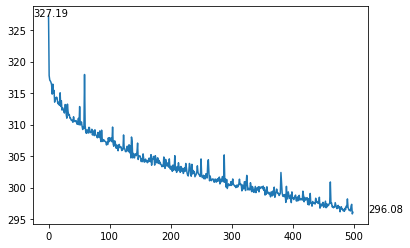

In [41]:
plt.plot(running_loss)
plt.annotate(f"{running_loss[0]:.2f}", xy=(0, running_loss[0]), xycoords=('axes fraction', 'data'))
plt.annotate(f"{running_loss[-1]:.2f}", xy=(1, running_loss[-1]), xycoords=('axes fraction', 'data'))
plt.show()

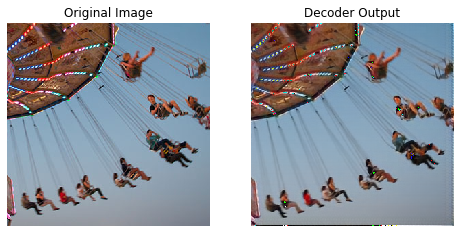

In [7]:
test_img = image_loader("sample_img.jpg")
output_img = AutoEncoder(test_img).cpu()
output_img = unloader(output_img.squeeze(0))
test_img = unloader(test_img.squeeze(0).cpu())
fig = plt.figure(figsize=(8,8))
fig.add_subplot(121).set_title('Original Image')
plt.axis('off')
plt.imshow(test_img)
fig.add_subplot(122).set_title('Decoder Output')
plt.axis('off')
plt.imshow(output_img)